# T81-558: Applications of Deep Neural Networks
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

**Kaggle Assignment: **

**Student Name: Jason Walker**

# Overview

## Description
This is one of the projects from the course T81-855: Applications of Deep Learning at Washington University in St. Louis. All students must create a Kaggle account and submit a solution. Once you have submitted your solution entry log into Blackboard (at WUSTL) and submit a single file telling me your Kaggle name on the leaderboard (you do not need to register to Kaggle with your real name). This competition will be visible to the public, so there may be non-student submissions as well as student.

The data set for this competition consists of a number of input columns that should be used to predict a stores sales. This is a regression problem. The inputs are a mixture of discrete and category values. The data set is from a simulation.

## Evaluation

The evaluation pages describes how submissions will be scored and how students should format their submissions. The scores are in RMSE.
Submission Format

For every store in the dataset, submission files should contain a sales volume.

The file should contain a header and have the following format:

```
100000,1.23
100001,1.123
100002,3.332
100003,1.53
...
```

# Data

## Data Description

The data contains data and costs for various office supplies. The data came from a simulation and do not directly correspond to any real-world items. See how well you can predict the cost of an item using the provided data. Feature engineering will likely help you. The *name* column may seem useless at first glance; however, it contains information that you can parse to help your predictions.
File descriptions
```
    id - The identifier/primary key.
    name - The name of this item.
    manufacturer - The manufacturer.
    pack - The number of items in this pack.
    weight - The weight of a pack of these items.
    height - The height of a pack of these items.
    width - The width of a pack of these items.
    length - The length of a pack of these items.
    cost - The cost for this item pack. This is what you are to predict (the target). 
```

# Helpful Functions

You will see these at the top of every module and assignment.  These are simply a set of reusable functions that we will make use of.  Each of them will be explained as the semester progresses.  They are explained in greater detail as the course progresses.  Class 4 contains a complete overview of these functions.

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

# Kaggle Code



In [2]:
import os
import re
import sklearn

import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, KFold
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

path = './data'

filename_test = os.path.join(path,"test.csv")
filename_train = os.path.join(path,"train.csv")
filename_sample = os.path.join(path,"sample.csv")
filename_submit = os.path.join(path,"submit.csv")
filename_checkpoint = os.path.join(path,"checkpoint.hdf5")

df_train = pd.read_csv(filename_train,na_values=['NA','?'])

np.random.seed(42) # Uncomment this line to get the same shuffle each time
df_train = df_train.reindex(np.random.permutation(df_train.index))
df_train.reset_index(inplace=True, drop=True)

# Encode Features

# Remove all rows where the specified column is +/- sd standard deviations
def extract_and_encode_features(df):
    color_regex='(?P<color>red|blue|green|yellow|orange|pink|black|brown|white)'
    df['color'] = df.name.str.extract(color_regex, flags=re.IGNORECASE, expand=False)

    quality_regex='(?P<quality>generic|high\squality)'
    df['quality'] = df.name.str.extract(quality_regex, flags=re.IGNORECASE, expand=False)

    size_regex='(?P<size>tiny|small|medium|large)'
    df['size'] = df.name.str.extract(size_regex, flags=re.IGNORECASE, expand=False)

    item_regex='(?P<item>paperclips|paperweights|ink\spens|pencils|stapler|tablets|thumbtacks|post\sit\snotes)'
    df['item'] = df.name.str.extract(item_regex, flags=re.IGNORECASE, expand=False)
    
    for column in ['pack','weight','height','width','length']:
        missing_median(df,column)
    
    #df.insert(1,'surface_area',(df['height']*df['width']*df['length']).astype(int))
    
    ## encode numeric features
    #for column in ['pack','weight','height','width','length','surface_area']:
    #    encode_numeric_zscore(df,column)

    # encode text/categorical features
    for column in ['manufacturer','color','quality','size','item']:
        encode_text_dummy(df,column)
  
extract_and_encode_features(df_train)

ids_train = df_train['id']
df_train.drop('id',1,inplace=True)

names_train = df_train['name']
df_train.drop('name',1,inplace=True)

x,y = to_xy(df_train,'cost')

# Used before KFold
#x_train, x_test, y_train, y_test = train_test_split(    
#    x, y, test_size=0.25, random_state=45)


/Users/jwalker/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Final score (RMSE): 32.5279541015625
['pack', 'weight', 'height', 'width', 'length', 'manufacturer-6% Solution', 'manufacturer-Deep Office Supplies', 'manufacturer-Duck Lake', 'manufacturer-Offices-R-Us', 'manufacturer-WizBang', 'color-Black', 'color-Blue', 'color-Brown', 'color-Green', 'color-Pink', 'color-Red', 'color-White', 'quality-Generic', 'quality-High Quality', 'size-Large', 'size-Medium', 'size-Small', 'size-Tiny', 'item-Ink Pens', 'item-Paperclips', 'item-Paperweights', 'item-Pencils', 'item-Post It Notes', 'item-Stapler', 'item-Tablets', 'item-Thumbtacks']


,coef,positive
item-Post It Notes,-60.369431,False
item-Thumbtacks,-57.847595,False
item-Pencils,-50.215904,False
item-Paperclips,-43.970024,False
color-Red,-39.540787,False
color-Green,-27.516720,False
color-Blue,-13.250540,False
height,-10.317136,False
length,-8.247688,False
width,-6.184750,False


Intercept: [ 84.28936005]


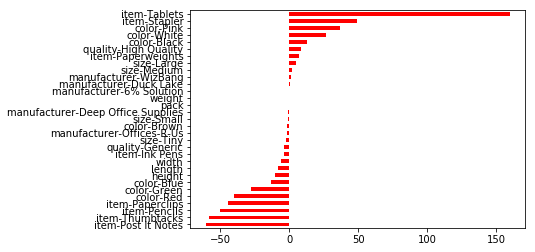

In [3]:
# Simple function to evaluate the coefficients of a regression
%matplotlib inline    
from IPython.display import display, HTML    

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))
    
# Create linear regression
regressor = sklearn.linear_model.LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")
print(names)
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)

Final score (RMSE): 32.51896667480469


,coef,positive
item-Thumbtacks,-49.421860,False
item-Post It Notes,-49.344654,False
item-Pencils,-44.134438,False
color-Red,-37.983204,False
item-Paperclips,-34.972664,False
color-Green,-25.736231,False
height,-17.168795,False
color-Blue,-11.625701,False
quality-Generic,-4.687774,False
manufacturer-Offices-R-Us,-0.996790,False


Intercept: [ 70.26249695]


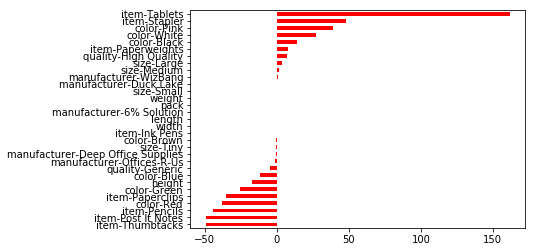

In [15]:


import sklearn
from sklearn.linear_model import Lasso

# Create linear regression
regressor = Lasso(random_state=0,alpha=0.01)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)



/Users/jwalker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jwalker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jwalker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jwalker/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di

(1e-08, 100000000.0)

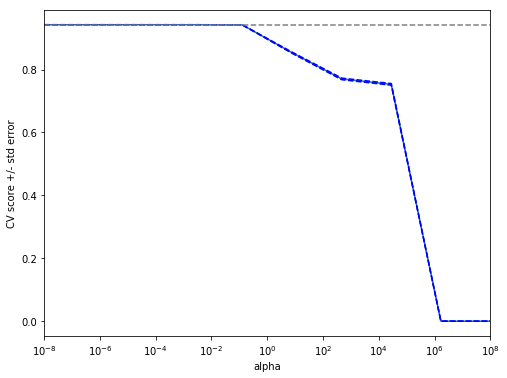

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

lasso = Lasso(random_state=42)
alphas = np.logspace(-8, 8, 10)

scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_val_score(lasso, x, y, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

Final score (RMSE): 32.519569396972656


/Users/jwalker/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2776476057685393e-11 / 5.960464477539063e-08
  RuntimeWarning)


,coef,positive
item-Post It Notes,-56.841797,False
item-Thumbtacks,-55.589020,False
item-Pencils,-49.602299,False
item-Paperclips,-41.850784,False
color-Red,-38.117607,False
color-Green,-25.877810,False
color-Blue,-11.786979,False
height,-9.410345,False
length,-7.374828,False
width,-5.693603,False


Intercept: [ 78.86076355]


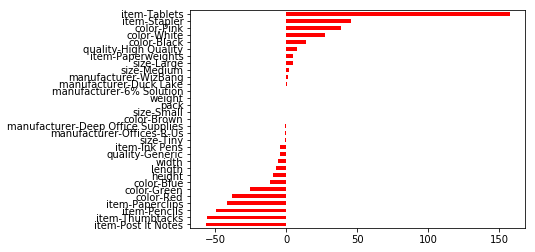

In [10]:
import sklearn
from sklearn.linear_model import Ridge

# Create linear regression
regressor = Ridge(alpha=1)

# Fit/train Ridge
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")

report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)

Final score (RMSE): 33.101341247558594


,coef,positive
item-Pencils,-40.795601,False
color-Red,-35.561138,False
item-Thumbtacks,-33.184319,False
color-Green,-24.621284,False
item-Paperweights,-23.317530,False
size-Large,-15.308939,False
item-Post It Notes,-12.960384,False
item-Ink Pens,-11.629585,False
color-Blue,-11.232443,False
item-Paperclips,-7.472833,False


Intercept: [ 14.47364044]


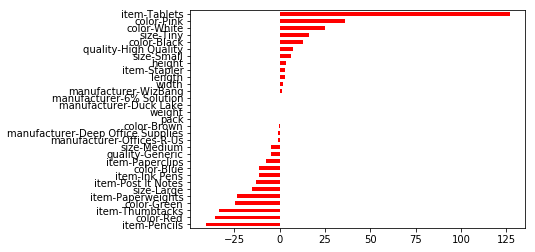

In [12]:
import sklearn
from sklearn.linear_model import ElasticNet

# Create linear regression
regressor = ElasticNet(alpha=0.01, l1_ratio=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")

report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

In [17]:
# Cross-Validate
kf = KFold(5)

checkpoint = ModelCheckpoint(filepath=filename_checkpoint, verbose=0, save_best_only=True)

# Turn off KFold
#if (0):
oos_y = []
oos_pred = []
fold = 0
    
for train, test in kf.split(x):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu')) # Hidden 1
    #model.add(Dropout(0.01)) # Dropout Layer
    model.add(Dense(50, activation='relu')) # Hidden 2
    model.add(Dense(25, 
                    kernel_regularizer=regularizers.l2(0.01), #L2 regularization
                    activity_regularizer=regularizers.l1(0.01), #L1 Lasso regularization
                    activation='relu')) # Hidden 3 
    model.add(Dense(10, activation='relu')) # Hidden 4
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=1000, verbose=1, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpoint],verbose=1,epochs=10000)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)        

    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))


Fold #1
Train on 8000 samples, validate on 2000 samples
Epoch 1/10000
8000/8000 [==============================] - 1s 133us/step - loss: 5659.2567 - val_loss: 4107.3521
Epoch 2/10000
8000/8000 [==============================] - 0s 55us/step - loss: 4779.3982 - val_loss: 4016.6760
Epoch 3/10000
8000/8000 [==============================] - 0s 56us/step - loss: 4744.6900 - val_loss: 3766.0933
Epoch 4/10000
8000/8000 [==============================] - 0s 56us/step - loss: 4407.7363 - val_loss: 3726.1054
Epoch 5/10000
8000/8000 [==============================] - 1s 65us/step - loss: 4390.4114 - val_loss: 3598.3143
Epoch 6/10000
8000/8000 [==============================] - 1s 67us/step - loss: 4279.8354 - val_loss: 3572.0842
Epoch 7/10000
8000/8000 [==============================] - 1s 64us/step - loss: 4246.6302 - val_loss: 3479.0055
Epoch 8/10000
8000/8000 [==============================] - 0s 58us/step - loss: 4034.8926 - val_loss: 3195.6319
Epoch 9/10000
8000/8000 [======================

Epoch 74/10000
8000/8000 [==============================] - 1s 67us/step - loss: 381.8733 - val_loss: 881.9468
Epoch 75/10000
8000/8000 [==============================] - 1s 70us/step - loss: 340.3723 - val_loss: 249.7436
Epoch 76/10000
8000/8000 [==============================] - 1s 80us/step - loss: 311.8190 - val_loss: 280.8514
Epoch 77/10000
8000/8000 [==============================] - 1s 73us/step - loss: 351.3682 - val_loss: 249.7712
Epoch 78/10000
8000/8000 [==============================] - 1s 66us/step - loss: 307.6452 - val_loss: 469.1609
Epoch 79/10000
8000/8000 [==============================] - 1s 70us/step - loss: 355.7113 - val_loss: 244.2583
Epoch 80/10000
8000/8000 [==============================] - 1s 91us/step - loss: 434.9029 - val_loss: 342.3024
Epoch 81/10000
8000/8000 [==============================] - 1s 71us/step - loss: 364.3188 - val_loss: 256.2639
Epoch 82/10000
8000/8000 [==============================] - 1s 65us/step - loss: 359.3189 - val_loss: 265.2827
E

8000/8000 [==============================] - 0s 61us/step - loss: 260.1289 - val_loss: 240.9845
Epoch 148/10000
8000/8000 [==============================] - 0s 61us/step - loss: 261.1529 - val_loss: 204.5672
Epoch 149/10000
8000/8000 [==============================] - 1s 65us/step - loss: 255.3661 - val_loss: 351.4143
Epoch 150/10000
8000/8000 [==============================] - 1s 71us/step - loss: 298.3389 - val_loss: 242.1885
Epoch 151/10000
8000/8000 [==============================] - 1s 65us/step - loss: 258.0382 - val_loss: 196.3030
Epoch 152/10000
8000/8000 [==============================] - 1s 105us/step - loss: 246.2309 - val_loss: 292.8368
Epoch 153/10000
8000/8000 [==============================] - 1s 76us/step - loss: 269.2809 - val_loss: 196.3768
Epoch 154/10000
8000/8000 [==============================] - 0s 62us/step - loss: 241.9543 - val_loss: 877.5647
Epoch 155/10000
8000/8000 [==============================] - 0s 59us/step - loss: 258.4714 - val_loss: 365.3691
Epoch 1

8000/8000 [==============================] - 1s 76us/step - loss: 211.2625 - val_loss: 181.6720
Epoch 221/10000
8000/8000 [==============================] - 1s 95us/step - loss: 194.2549 - val_loss: 172.4646
Epoch 222/10000
8000/8000 [==============================] - 1s 71us/step - loss: 188.3251 - val_loss: 167.8340
Epoch 223/10000
8000/8000 [==============================] - 0s 60us/step - loss: 270.6398 - val_loss: 272.0801
Epoch 224/10000
8000/8000 [==============================] - 1s 63us/step - loss: 205.0109 - val_loss: 164.1966
Epoch 225/10000
8000/8000 [==============================] - 0s 57us/step - loss: 216.2264 - val_loss: 206.1613
Epoch 226/10000
8000/8000 [==============================] - 0s 51us/step - loss: 167.1683 - val_loss: 161.9350
Epoch 227/10000
8000/8000 [==============================] - 0s 48us/step - loss: 227.6050 - val_loss: 189.6599
Epoch 228/10000
8000/8000 [==============================] - 1s 81us/step - loss: 357.5911 - val_loss: 182.5592
Epoch 22

Epoch 293/10000
8000/8000 [==============================] - 0s 46us/step - loss: 193.6149 - val_loss: 196.2476
Epoch 294/10000
8000/8000 [==============================] - 0s 57us/step - loss: 189.9553 - val_loss: 270.0288
Epoch 295/10000
8000/8000 [==============================] - 1s 94us/step - loss: 188.4434 - val_loss: 174.6447
Epoch 296/10000
8000/8000 [==============================] - 0s 54us/step - loss: 179.5154 - val_loss: 327.0443
Epoch 297/10000
8000/8000 [==============================] - 0s 52us/step - loss: 201.9131 - val_loss: 368.8547
Epoch 298/10000
8000/8000 [==============================] - 0s 47us/step - loss: 200.5616 - val_loss: 210.2083
Epoch 299/10000
8000/8000 [==============================] - 0s 47us/step - loss: 183.3984 - val_loss: 189.1323
Epoch 300/10000
8000/8000 [==============================] - 1s 66us/step - loss: 189.6512 - val_loss: 205.0889
Epoch 301/10000
8000/8000 [==============================] - 0s 53us/step - loss: 178.2010 - val_loss: 1

8000/8000 [==============================] - 1s 85us/step - loss: 155.0305 - val_loss: 148.3629
Epoch 367/10000
8000/8000 [==============================] - 0s 59us/step - loss: 172.4777 - val_loss: 220.5127
Epoch 368/10000
8000/8000 [==============================] - 1s 67us/step - loss: 167.5395 - val_loss: 245.0039
Epoch 369/10000
8000/8000 [==============================] - 1s 71us/step - loss: 179.5156 - val_loss: 183.8823
Epoch 370/10000
8000/8000 [==============================] - 1s 95us/step - loss: 155.7823 - val_loss: 215.0990
Epoch 371/10000
8000/8000 [==============================] - 1s 91us/step - loss: 202.1413 - val_loss: 276.1087
Epoch 372/10000
8000/8000 [==============================] - 1s 65us/step - loss: 173.2266 - val_loss: 190.8855
Epoch 373/10000
8000/8000 [==============================] - 0s 55us/step - loss: 206.1829 - val_loss: 573.6679
Epoch 374/10000
8000/8000 [==============================] - 0s 61us/step - loss: 222.0837 - val_loss: 190.6337
Epoch 37

8000/8000 [==============================] - 0s 51us/step - loss: 183.4374 - val_loss: 147.5091
Epoch 440/10000
8000/8000 [==============================] - 0s 51us/step - loss: 177.6049 - val_loss: 154.1775
Epoch 441/10000
8000/8000 [==============================] - 0s 47us/step - loss: 161.5027 - val_loss: 151.9420
Epoch 442/10000
8000/8000 [==============================] - 0s 48us/step - loss: 151.7662 - val_loss: 216.2058
Epoch 443/10000
8000/8000 [==============================] - 0s 53us/step - loss: 158.5940 - val_loss: 164.2382
Epoch 444/10000
8000/8000 [==============================] - 0s 55us/step - loss: 169.0392 - val_loss: 167.7677
Epoch 445/10000
8000/8000 [==============================] - 0s 62us/step - loss: 183.9790 - val_loss: 173.3128
Epoch 446/10000
8000/8000 [==============================] - 0s 50us/step - loss: 155.3738 - val_loss: 143.3705
Epoch 447/10000
8000/8000 [==============================] - 0s 48us/step - loss: 139.9799 - val_loss: 161.6793
Epoch 44

8000/8000 [==============================] - 0s 48us/step - loss: 196.1257 - val_loss: 160.7237
Epoch 513/10000
8000/8000 [==============================] - 0s 50us/step - loss: 166.5210 - val_loss: 180.2157
Epoch 514/10000
8000/8000 [==============================] - 0s 52us/step - loss: 168.3978 - val_loss: 167.5517
Epoch 515/10000
8000/8000 [==============================] - 0s 49us/step - loss: 193.2633 - val_loss: 230.9079
Epoch 516/10000
8000/8000 [==============================] - 0s 49us/step - loss: 199.8426 - val_loss: 480.6429
Epoch 517/10000
8000/8000 [==============================] - 0s 49us/step - loss: 178.7264 - val_loss: 158.3207
Epoch 518/10000
8000/8000 [==============================] - 0s 47us/step - loss: 168.1665 - val_loss: 154.9163
Epoch 519/10000
8000/8000 [==============================] - 0s 47us/step - loss: 170.3273 - val_loss: 174.2055
Epoch 520/10000
8000/8000 [==============================] - 0s 48us/step - loss: 162.9292 - val_loss: 154.7843
Epoch 52

8000/8000 [==============================] - 0s 51us/step - loss: 146.3999 - val_loss: 152.5094
Epoch 586/10000
8000/8000 [==============================] - 0s 55us/step - loss: 165.0102 - val_loss: 1047.3710
Epoch 587/10000
8000/8000 [==============================] - 0s 58us/step - loss: 377.7747 - val_loss: 174.7993
Epoch 588/10000
8000/8000 [==============================] - 1s 67us/step - loss: 154.0442 - val_loss: 146.0418
Epoch 589/10000
8000/8000 [==============================] - 0s 56us/step - loss: 150.3874 - val_loss: 194.9476
Epoch 590/10000
8000/8000 [==============================] - 0s 57us/step - loss: 148.8402 - val_loss: 146.0324
Epoch 591/10000
8000/8000 [==============================] - 0s 57us/step - loss: 160.8979 - val_loss: 140.2740
Epoch 592/10000
8000/8000 [==============================] - 0s 57us/step - loss: 145.8217 - val_loss: 146.6886
Epoch 593/10000
8000/8000 [==============================] - 0s 51us/step - loss: 149.8661 - val_loss: 151.4192
Epoch 5

8000/8000 [==============================] - 0s 61us/step - loss: 140.1791 - val_loss: 162.6031
Epoch 659/10000
8000/8000 [==============================] - 0s 51us/step - loss: 138.4518 - val_loss: 159.5170
Epoch 660/10000
8000/8000 [==============================] - 1s 67us/step - loss: 160.3914 - val_loss: 150.6339
Epoch 661/10000
8000/8000 [==============================] - 1s 65us/step - loss: 146.3444 - val_loss: 158.0685
Epoch 662/10000
8000/8000 [==============================] - 0s 55us/step - loss: 237.0486 - val_loss: 146.7817
Epoch 663/10000
8000/8000 [==============================] - 0s 52us/step - loss: 139.8562 - val_loss: 163.7527
Epoch 664/10000
8000/8000 [==============================] - 1s 66us/step - loss: 154.7265 - val_loss: 157.2468
Epoch 665/10000
8000/8000 [==============================] - 0s 49us/step - loss: 151.2780 - val_loss: 173.0168
Epoch 666/10000
8000/8000 [==============================] - 0s 57us/step - loss: 147.7707 - val_loss: 152.5220
Epoch 66

8000/8000 [==============================] - 0s 47us/step - loss: 146.4164 - val_loss: 158.5436
Epoch 732/10000
8000/8000 [==============================] - 0s 47us/step - loss: 193.2756 - val_loss: 435.9396
Epoch 733/10000
8000/8000 [==============================] - 0s 50us/step - loss: 165.3554 - val_loss: 171.9212
Epoch 734/10000
8000/8000 [==============================] - 0s 47us/step - loss: 136.5731 - val_loss: 144.7380
Epoch 735/10000
8000/8000 [==============================] - 0s 46us/step - loss: 143.2922 - val_loss: 148.5905
Epoch 736/10000
8000/8000 [==============================] - 0s 50us/step - loss: 141.6594 - val_loss: 192.0791
Epoch 737/10000
8000/8000 [==============================] - 0s 47us/step - loss: 151.7392 - val_loss: 235.8696
Epoch 738/10000
8000/8000 [==============================] - 0s 51us/step - loss: 136.8750 - val_loss: 219.0713
Epoch 739/10000
8000/8000 [==============================] - 0s 49us/step - loss: 167.3798 - val_loss: 237.7531
Epoch 74

Epoch 804/10000
8000/8000 [==============================] - 0s 57us/step - loss: 152.2448 - val_loss: 233.9766
Epoch 805/10000
8000/8000 [==============================] - 0s 53us/step - loss: 159.7059 - val_loss: 161.7496
Epoch 806/10000
8000/8000 [==============================] - 0s 55us/step - loss: 165.2148 - val_loss: 205.3306
Epoch 807/10000
8000/8000 [==============================] - 0s 60us/step - loss: 154.8091 - val_loss: 209.7706
Epoch 808/10000
8000/8000 [==============================] - 1s 65us/step - loss: 166.3138 - val_loss: 150.1080
Epoch 809/10000
8000/8000 [==============================] - 0s 59us/step - loss: 192.0148 - val_loss: 244.3949
Epoch 810/10000
8000/8000 [==============================] - 0s 58us/step - loss: 147.4316 - val_loss: 226.6142
Epoch 811/10000
8000/8000 [==============================] - 0s 53us/step - loss: 245.2078 - val_loss: 193.0356
Epoch 812/10000
8000/8000 [==============================] - 0s 57us/step - loss: 150.3576 - val_loss: 1

8000/8000 [==============================] - 0s 53us/step - loss: 133.0366 - val_loss: 139.8938
Epoch 878/10000
8000/8000 [==============================] - 0s 55us/step - loss: 140.5009 - val_loss: 136.4173
Epoch 879/10000
8000/8000 [==============================] - 0s 52us/step - loss: 140.5521 - val_loss: 141.9411
Epoch 880/10000
8000/8000 [==============================] - 0s 56us/step - loss: 172.6756 - val_loss: 168.7276
Epoch 881/10000
8000/8000 [==============================] - 1s 63us/step - loss: 147.4233 - val_loss: 136.8179
Epoch 882/10000
8000/8000 [==============================] - 1s 72us/step - loss: 138.9784 - val_loss: 144.5194
Epoch 883/10000
8000/8000 [==============================] - 1s 74us/step - loss: 147.3169 - val_loss: 143.5545
Epoch 884/10000
8000/8000 [==============================] - 0s 57us/step - loss: 148.1284 - val_loss: 144.9717
Epoch 885/10000
8000/8000 [==============================] - 1s 69us/step - loss: 157.8576 - val_loss: 172.4646
Epoch 88

Epoch 950/10000
8000/8000 [==============================] - 1s 63us/step - loss: 152.5802 - val_loss: 179.2478
Epoch 951/10000
8000/8000 [==============================] - 1s 95us/step - loss: 143.6007 - val_loss: 156.3426
Epoch 952/10000
8000/8000 [==============================] - 0s 50us/step - loss: 166.5400 - val_loss: 144.6683
Epoch 953/10000
8000/8000 [==============================] - 0s 58us/step - loss: 140.2662 - val_loss: 137.9833
Epoch 954/10000
8000/8000 [==============================] - 1s 64us/step - loss: 142.8746 - val_loss: 140.3128
Epoch 955/10000
8000/8000 [==============================] - 0s 57us/step - loss: 138.1204 - val_loss: 148.6215
Epoch 956/10000
8000/8000 [==============================] - 0s 47us/step - loss: 148.6009 - val_loss: 151.0985
Epoch 957/10000
8000/8000 [==============================] - 0s 45us/step - loss: 152.5832 - val_loss: 153.0651
Epoch 958/10000
8000/8000 [==============================] - 0s 56us/step - loss: 142.5767 - val_loss: 2

Epoch 1023/10000
8000/8000 [==============================] - 0s 51us/step - loss: 129.2162 - val_loss: 181.0599
Epoch 1024/10000
8000/8000 [==============================] - 0s 53us/step - loss: 142.7119 - val_loss: 142.2321
Epoch 1025/10000
8000/8000 [==============================] - 0s 53us/step - loss: 137.3675 - val_loss: 152.9897
Epoch 1026/10000
8000/8000 [==============================] - 0s 49us/step - loss: 140.9233 - val_loss: 138.3237
Epoch 1027/10000
8000/8000 [==============================] - 0s 51us/step - loss: 134.3234 - val_loss: 137.3770
Epoch 1028/10000
8000/8000 [==============================] - 0s 52us/step - loss: 149.6673 - val_loss: 148.7112
Epoch 1029/10000
8000/8000 [==============================] - 0s 51us/step - loss: 143.9220 - val_loss: 228.8074
Epoch 1030/10000
8000/8000 [==============================] - 0s 56us/step - loss: 146.9817 - val_loss: 152.4184
Epoch 1031/10000
8000/8000 [==============================] - 1s 68us/step - loss: 143.9797 - va

8000/8000 [==============================] - 0s 48us/step - loss: 125.8559 - val_loss: 151.6734
Epoch 1096/10000
8000/8000 [==============================] - 0s 48us/step - loss: 129.9916 - val_loss: 136.5782
Epoch 1097/10000
8000/8000 [==============================] - 0s 49us/step - loss: 134.0946 - val_loss: 210.6612
Epoch 1098/10000
8000/8000 [==============================] - 0s 51us/step - loss: 143.4913 - val_loss: 135.9842
Epoch 1099/10000
8000/8000 [==============================] - 0s 47us/step - loss: 141.9294 - val_loss: 148.8276
Epoch 1100/10000
8000/8000 [==============================] - 0s 49us/step - loss: 146.9090 - val_loss: 144.6759
Epoch 1101/10000
8000/8000 [==============================] - 0s 51us/step - loss: 145.4500 - val_loss: 280.1955
Epoch 1102/10000
8000/8000 [==============================] - 0s 46us/step - loss: 155.2344 - val_loss: 162.1579
Epoch 1103/10000
8000/8000 [==============================] - 0s 49us/step - loss: 133.1207 - val_loss: 139.6785


8000/8000 [==============================] - 0s 50us/step - loss: 143.4668 - val_loss: 144.4523
Epoch 1168/10000
8000/8000 [==============================] - 0s 49us/step - loss: 143.5833 - val_loss: 155.8493
Epoch 1169/10000
8000/8000 [==============================] - 0s 47us/step - loss: 134.0992 - val_loss: 172.6933
Epoch 1170/10000
8000/8000 [==============================] - 0s 50us/step - loss: 142.4725 - val_loss: 188.8383
Epoch 1171/10000
8000/8000 [==============================] - 0s 54us/step - loss: 193.5673 - val_loss: 154.6676
Epoch 1172/10000
8000/8000 [==============================] - 0s 48us/step - loss: 128.3226 - val_loss: 143.7839
Epoch 1173/10000
8000/8000 [==============================] - 0s 49us/step - loss: 127.6698 - val_loss: 135.0443
Epoch 1174/10000
8000/8000 [==============================] - 0s 52us/step - loss: 129.6454 - val_loss: 135.7876
Epoch 1175/10000
8000/8000 [==============================] - 1s 68us/step - loss: 139.2668 - val_loss: 321.0959


8000/8000 [==============================] - 0s 53us/step - loss: 135.6170 - val_loss: 140.8500
Epoch 1240/10000
8000/8000 [==============================] - 0s 49us/step - loss: 137.2125 - val_loss: 186.0560
Epoch 1241/10000
8000/8000 [==============================] - 0s 53us/step - loss: 144.0409 - val_loss: 150.0220
Epoch 1242/10000
8000/8000 [==============================] - 0s 52us/step - loss: 157.8921 - val_loss: 134.6951
Epoch 1243/10000
8000/8000 [==============================] - 0s 54us/step - loss: 138.0818 - val_loss: 145.3401
Epoch 1244/10000
8000/8000 [==============================] - 0s 52us/step - loss: 136.3715 - val_loss: 138.3309
Epoch 1245/10000
8000/8000 [==============================] - 0s 53us/step - loss: 141.7041 - val_loss: 168.9576
Epoch 1246/10000
8000/8000 [==============================] - 0s 48us/step - loss: 133.0509 - val_loss: 144.1819
Epoch 1247/10000
8000/8000 [==============================] - 1s 64us/step - loss: 134.9220 - val_loss: 139.1263


8000/8000 [==============================] - 0s 46us/step - loss: 130.6291 - val_loss: 148.2177
Epoch 1312/10000
8000/8000 [==============================] - 0s 51us/step - loss: 131.4698 - val_loss: 207.3092
Epoch 1313/10000
8000/8000 [==============================] - 0s 52us/step - loss: 154.5860 - val_loss: 145.6658
Epoch 1314/10000
8000/8000 [==============================] - 0s 50us/step - loss: 140.5825 - val_loss: 138.1936
Epoch 1315/10000
8000/8000 [==============================] - 0s 51us/step - loss: 136.0738 - val_loss: 147.3442
Epoch 1316/10000
8000/8000 [==============================] - 0s 51us/step - loss: 135.0614 - val_loss: 138.7693
Epoch 1317/10000
8000/8000 [==============================] - 0s 51us/step - loss: 127.1559 - val_loss: 144.1958
Epoch 1318/10000
8000/8000 [==============================] - 0s 48us/step - loss: 127.9034 - val_loss: 188.4024
Epoch 1319/10000
8000/8000 [==============================] - 1s 66us/step - loss: 141.5561 - val_loss: 225.2661


8000/8000 [==============================] - 0s 53us/step - loss: 123.2215 - val_loss: 185.2390
Epoch 1384/10000
8000/8000 [==============================] - 0s 52us/step - loss: 136.6213 - val_loss: 134.3060
Epoch 1385/10000
8000/8000 [==============================] - 0s 47us/step - loss: 128.8405 - val_loss: 142.8166
Epoch 1386/10000
8000/8000 [==============================] - 0s 48us/step - loss: 126.6457 - val_loss: 147.9097
Epoch 1387/10000
8000/8000 [==============================] - 0s 48us/step - loss: 129.2811 - val_loss: 158.1994
Epoch 1388/10000
8000/8000 [==============================] - 0s 51us/step - loss: 126.5694 - val_loss: 142.5753
Epoch 1389/10000
8000/8000 [==============================] - 0s 59us/step - loss: 138.9225 - val_loss: 154.5009
Epoch 1390/10000
8000/8000 [==============================] - 1s 65us/step - loss: 207.5259 - val_loss: 135.2869
Epoch 1391/10000
8000/8000 [==============================] - 1s 71us/step - loss: 130.3690 - val_loss: 146.6597


8000/8000 [==============================] - 0s 47us/step - loss: 287.0952 - val_loss: 136.1523
Epoch 1456/10000
8000/8000 [==============================] - 0s 46us/step - loss: 124.2506 - val_loss: 137.9912
Epoch 1457/10000
8000/8000 [==============================] - 0s 49us/step - loss: 126.1633 - val_loss: 139.2192
Epoch 1458/10000
8000/8000 [==============================] - 0s 49us/step - loss: 126.4185 - val_loss: 145.8754
Epoch 1459/10000
8000/8000 [==============================] - 0s 49us/step - loss: 127.6242 - val_loss: 138.4709
Epoch 1460/10000
8000/8000 [==============================] - 0s 51us/step - loss: 126.2537 - val_loss: 160.4692
Epoch 1461/10000
8000/8000 [==============================] - 0s 49us/step - loss: 135.0032 - val_loss: 136.5237
Epoch 1462/10000
8000/8000 [==============================] - 0s 46us/step - loss: 129.4878 - val_loss: 134.2954
Epoch 1463/10000
8000/8000 [==============================] - 0s 60us/step - loss: 129.5606 - val_loss: 152.5647


8000/8000 [==============================] - 0s 52us/step - loss: 128.6174 - val_loss: 148.2637
Epoch 1528/10000
8000/8000 [==============================] - 0s 51us/step - loss: 138.3989 - val_loss: 161.9445
Epoch 1529/10000
8000/8000 [==============================] - 0s 54us/step - loss: 129.8989 - val_loss: 160.0754
Epoch 1530/10000
8000/8000 [==============================] - 0s 52us/step - loss: 131.5087 - val_loss: 138.9909
Epoch 1531/10000
8000/8000 [==============================] - 0s 50us/step - loss: 133.2392 - val_loss: 160.3688
Epoch 1532/10000
8000/8000 [==============================] - 0s 47us/step - loss: 161.0128 - val_loss: 149.5334
Epoch 1533/10000
8000/8000 [==============================] - 0s 47us/step - loss: 128.2254 - val_loss: 138.1235
Epoch 1534/10000
8000/8000 [==============================] - 0s 48us/step - loss: 139.2230 - val_loss: 138.2229
Epoch 1535/10000
8000/8000 [==============================] - 0s 50us/step - loss: 127.9394 - val_loss: 137.5682


8000/8000 [==============================] - 0s 56us/step - loss: 131.1500 - val_loss: 139.5138
Epoch 1600/10000
8000/8000 [==============================] - 0s 46us/step - loss: 136.9746 - val_loss: 178.3241
Epoch 1601/10000
8000/8000 [==============================] - 0s 47us/step - loss: 141.2876 - val_loss: 249.6989
Epoch 1602/10000
8000/8000 [==============================] - 0s 60us/step - loss: 131.4337 - val_loss: 149.7386
Epoch 1603/10000
8000/8000 [==============================] - 0s 47us/step - loss: 146.4513 - val_loss: 134.5290
Epoch 1604/10000
8000/8000 [==============================] - 0s 47us/step - loss: 137.2425 - val_loss: 183.9893
Epoch 1605/10000
8000/8000 [==============================] - 0s 60us/step - loss: 137.8535 - val_loss: 141.4674
Epoch 1606/10000
8000/8000 [==============================] - 0s 52us/step - loss: 127.8547 - val_loss: 199.0329
Epoch 1607/10000
8000/8000 [==============================] - 0s 54us/step - loss: 133.4964 - val_loss: 141.0237


8000/8000 [==============================] - 0s 50us/step - loss: 127.1727 - val_loss: 149.9104
Epoch 1672/10000
8000/8000 [==============================] - 0s 56us/step - loss: 128.3547 - val_loss: 149.8528
Epoch 1673/10000
8000/8000 [==============================] - 0s 52us/step - loss: 134.2787 - val_loss: 147.3359
Epoch 1674/10000
8000/8000 [==============================] - 0s 48us/step - loss: 130.8141 - val_loss: 136.7745
Epoch 1675/10000
8000/8000 [==============================] - 0s 49us/step - loss: 128.4797 - val_loss: 143.6077
Epoch 1676/10000
8000/8000 [==============================] - 0s 46us/step - loss: 133.4406 - val_loss: 147.7479
Epoch 1677/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.9168 - val_loss: 201.9826
Epoch 1678/10000
8000/8000 [==============================] - 0s 47us/step - loss: 138.6660 - val_loss: 141.9263
Epoch 1679/10000
8000/8000 [==============================] - 0s 49us/step - loss: 136.9073 - val_loss: 145.2083


8000/8000 [==============================] - 0s 51us/step - loss: 173.6870 - val_loss: 183.3746
Epoch 1744/10000
8000/8000 [==============================] - 0s 51us/step - loss: 124.9587 - val_loss: 138.1237
Epoch 1745/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.9288 - val_loss: 134.4847
Epoch 1746/10000
8000/8000 [==============================] - 0s 47us/step - loss: 131.9781 - val_loss: 169.3844
Epoch 1747/10000
8000/8000 [==============================] - 0s 49us/step - loss: 138.8283 - val_loss: 261.8246
Epoch 1748/10000
8000/8000 [==============================] - 0s 51us/step - loss: 132.0175 - val_loss: 144.5860
Epoch 1749/10000
8000/8000 [==============================] - 0s 51us/step - loss: 127.3517 - val_loss: 134.8939
Epoch 1750/10000
8000/8000 [==============================] - 0s 51us/step - loss: 128.4150 - val_loss: 134.8346
Epoch 1751/10000
8000/8000 [==============================] - 0s 49us/step - loss: 130.2013 - val_loss: 146.5113


8000/8000 [==============================] - 0s 45us/step - loss: 143.8281 - val_loss: 142.2427
Epoch 1816/10000
8000/8000 [==============================] - 0s 47us/step - loss: 132.4629 - val_loss: 144.4728
Epoch 1817/10000
8000/8000 [==============================] - 0s 46us/step - loss: 142.6426 - val_loss: 137.2285
Epoch 1818/10000
8000/8000 [==============================] - 0s 46us/step - loss: 130.3195 - val_loss: 135.3261
Epoch 1819/10000
8000/8000 [==============================] - 0s 47us/step - loss: 131.7864 - val_loss: 159.3973
Epoch 1820/10000
8000/8000 [==============================] - 0s 46us/step - loss: 143.3476 - val_loss: 148.0366
Epoch 1821/10000
8000/8000 [==============================] - 0s 46us/step - loss: 134.0063 - val_loss: 171.1986
Epoch 1822/10000
8000/8000 [==============================] - 0s 50us/step - loss: 135.0298 - val_loss: 186.8996
Epoch 1823/10000
8000/8000 [==============================] - 0s 47us/step - loss: 128.5955 - val_loss: 157.9248


8000/8000 [==============================] - 0s 45us/step - loss: 133.0729 - val_loss: 132.2549
Epoch 1888/10000
8000/8000 [==============================] - 0s 51us/step - loss: 126.1732 - val_loss: 135.6713
Epoch 1889/10000
8000/8000 [==============================] - 0s 53us/step - loss: 126.7090 - val_loss: 137.4983
Epoch 1890/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.7033 - val_loss: 138.5725
Epoch 1891/10000
8000/8000 [==============================] - 0s 50us/step - loss: 134.9989 - val_loss: 144.6254
Epoch 1892/10000
8000/8000 [==============================] - 0s 59us/step - loss: 126.2524 - val_loss: 158.7329
Epoch 1893/10000
8000/8000 [==============================] - 0s 54us/step - loss: 127.8649 - val_loss: 135.7690
Epoch 1894/10000
8000/8000 [==============================] - 0s 46us/step - loss: 130.3005 - val_loss: 138.9481
Epoch 1895/10000
8000/8000 [==============================] - 0s 47us/step - loss: 128.3151 - val_loss: 134.5559


8000/8000 [==============================] - 0s 49us/step - loss: 134.5185 - val_loss: 164.4161
Epoch 1960/10000
8000/8000 [==============================] - 0s 50us/step - loss: 127.9370 - val_loss: 130.3107
Epoch 1961/10000
8000/8000 [==============================] - 0s 49us/step - loss: 132.2703 - val_loss: 164.2486
Epoch 1962/10000
8000/8000 [==============================] - 0s 53us/step - loss: 126.6051 - val_loss: 139.3670
Epoch 1963/10000
8000/8000 [==============================] - 0s 55us/step - loss: 175.6769 - val_loss: 133.3000
Epoch 1964/10000
8000/8000 [==============================] - 0s 47us/step - loss: 121.2498 - val_loss: 142.3054
Epoch 1965/10000
8000/8000 [==============================] - 0s 49us/step - loss: 126.3766 - val_loss: 146.1015
Epoch 1966/10000
8000/8000 [==============================] - 0s 46us/step - loss: 126.6548 - val_loss: 142.4869
Epoch 1967/10000
8000/8000 [==============================] - 0s 50us/step - loss: 129.6904 - val_loss: 133.6707


8000/8000 [==============================] - 0s 48us/step - loss: 121.0780 - val_loss: 168.7211
Epoch 2032/10000
8000/8000 [==============================] - 0s 51us/step - loss: 154.7505 - val_loss: 145.7485
Epoch 2033/10000
8000/8000 [==============================] - 0s 52us/step - loss: 127.0834 - val_loss: 155.5430
Epoch 2034/10000
8000/8000 [==============================] - 0s 53us/step - loss: 121.8395 - val_loss: 159.9081
Epoch 2035/10000
8000/8000 [==============================] - 1s 64us/step - loss: 180.8494 - val_loss: 144.0576
Epoch 2036/10000
8000/8000 [==============================] - 1s 70us/step - loss: 123.3789 - val_loss: 135.3421
Epoch 2037/10000
8000/8000 [==============================] - 0s 53us/step - loss: 123.7951 - val_loss: 175.9962
Epoch 2038/10000
8000/8000 [==============================] - 0s 54us/step - loss: 123.9952 - val_loss: 134.6518
Epoch 2039/10000
8000/8000 [==============================] - 0s 53us/step - loss: 123.5580 - val_loss: 146.6766


8000/8000 [==============================] - 0s 48us/step - loss: 231.9256 - val_loss: 142.2939
Epoch 2104/10000
8000/8000 [==============================] - 0s 48us/step - loss: 123.7833 - val_loss: 136.9315
Epoch 2105/10000
8000/8000 [==============================] - 0s 53us/step - loss: 123.2629 - val_loss: 135.9655
Epoch 2106/10000
8000/8000 [==============================] - 0s 55us/step - loss: 128.3384 - val_loss: 136.3723
Epoch 2107/10000
8000/8000 [==============================] - 0s 52us/step - loss: 136.6940 - val_loss: 159.6241
Epoch 2108/10000
8000/8000 [==============================] - 0s 50us/step - loss: 122.4373 - val_loss: 135.3776
Epoch 2109/10000
8000/8000 [==============================] - 0s 54us/step - loss: 128.6029 - val_loss: 137.1626
Epoch 2110/10000
8000/8000 [==============================] - 0s 50us/step - loss: 132.7347 - val_loss: 154.0111
Epoch 2111/10000
8000/8000 [==============================] - 0s 51us/step - loss: 126.3830 - val_loss: 145.2534


8000/8000 [==============================] - 0s 55us/step - loss: 126.2245 - val_loss: 149.1003
Epoch 2176/10000
8000/8000 [==============================] - 0s 50us/step - loss: 127.5320 - val_loss: 162.5440
Epoch 2177/10000
8000/8000 [==============================] - 0s 48us/step - loss: 137.0510 - val_loss: 155.3020
Epoch 2178/10000
8000/8000 [==============================] - 0s 57us/step - loss: 126.8677 - val_loss: 131.0592
Epoch 2179/10000
8000/8000 [==============================] - 0s 49us/step - loss: 127.9392 - val_loss: 134.3472
Epoch 2180/10000
8000/8000 [==============================] - 0s 55us/step - loss: 129.8145 - val_loss: 143.0349
Epoch 2181/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.9160 - val_loss: 139.7496
Epoch 2182/10000
8000/8000 [==============================] - 0s 46us/step - loss: 120.6792 - val_loss: 164.0088
Epoch 2183/10000
8000/8000 [==============================] - 0s 53us/step - loss: 126.7087 - val_loss: 162.7993


8000/8000 [==============================] - 0s 48us/step - loss: 130.2567 - val_loss: 137.7940
Epoch 2248/10000
8000/8000 [==============================] - 0s 54us/step - loss: 134.0068 - val_loss: 140.8647
Epoch 2249/10000
8000/8000 [==============================] - 0s 56us/step - loss: 134.9341 - val_loss: 135.7677
Epoch 2250/10000
8000/8000 [==============================] - 0s 51us/step - loss: 124.5544 - val_loss: 183.2621
Epoch 2251/10000
8000/8000 [==============================] - 0s 50us/step - loss: 131.4143 - val_loss: 133.1779
Epoch 2252/10000
8000/8000 [==============================] - 0s 52us/step - loss: 123.7536 - val_loss: 151.5667
Epoch 2253/10000
8000/8000 [==============================] - 0s 47us/step - loss: 151.7902 - val_loss: 139.3677
Epoch 2254/10000
8000/8000 [==============================] - 0s 48us/step - loss: 125.6430 - val_loss: 132.7678
Epoch 2255/10000
8000/8000 [==============================] - 0s 50us/step - loss: 124.0311 - val_loss: 172.6283


8000/8000 [==============================] - 0s 49us/step - loss: 169.0017 - val_loss: 136.6516
Epoch 2320/10000
8000/8000 [==============================] - 0s 54us/step - loss: 127.5451 - val_loss: 143.1127
Epoch 2321/10000
8000/8000 [==============================] - 0s 53us/step - loss: 126.2490 - val_loss: 134.5117
Epoch 2322/10000
8000/8000 [==============================] - 0s 48us/step - loss: 125.3156 - val_loss: 130.6247
Epoch 2323/10000
8000/8000 [==============================] - 0s 48us/step - loss: 126.2158 - val_loss: 139.0067
Epoch 2324/10000
8000/8000 [==============================] - 0s 46us/step - loss: 130.9184 - val_loss: 139.6656
Epoch 2325/10000
8000/8000 [==============================] - 0s 59us/step - loss: 120.1853 - val_loss: 135.3646
Epoch 2326/10000
8000/8000 [==============================] - 0s 61us/step - loss: 141.4747 - val_loss: 133.9288
Epoch 2327/10000
8000/8000 [==============================] - 0s 53us/step - loss: 126.0331 - val_loss: 135.9113


8000/8000 [==============================] - 0s 50us/step - loss: 122.9851 - val_loss: 146.9282
Epoch 2392/10000
8000/8000 [==============================] - 0s 52us/step - loss: 125.0721 - val_loss: 139.7419
Epoch 2393/10000
8000/8000 [==============================] - 0s 59us/step - loss: 133.5806 - val_loss: 136.3055
Epoch 2394/10000
8000/8000 [==============================] - 0s 54us/step - loss: 123.6695 - val_loss: 228.0570
Epoch 2395/10000
8000/8000 [==============================] - 0s 50us/step - loss: 126.3856 - val_loss: 136.1019
Epoch 2396/10000
8000/8000 [==============================] - 0s 55us/step - loss: 125.4796 - val_loss: 146.5138
Epoch 2397/10000
8000/8000 [==============================] - 0s 50us/step - loss: 124.5844 - val_loss: 142.7522
Epoch 2398/10000
8000/8000 [==============================] - 0s 49us/step - loss: 134.4730 - val_loss: 184.2864
Epoch 2399/10000
8000/8000 [==============================] - 0s 50us/step - loss: 216.1650 - val_loss: 221.4891


8000/8000 [==============================] - 0s 49us/step - loss: 128.2882 - val_loss: 146.0065
Epoch 2464/10000
8000/8000 [==============================] - 0s 49us/step - loss: 124.8318 - val_loss: 134.1175
Epoch 2465/10000
8000/8000 [==============================] - 0s 49us/step - loss: 144.0846 - val_loss: 141.1169
Epoch 2466/10000
8000/8000 [==============================] - 0s 49us/step - loss: 123.1286 - val_loss: 158.1314
Epoch 2467/10000
8000/8000 [==============================] - 0s 50us/step - loss: 124.9022 - val_loss: 140.2750
Epoch 2468/10000
8000/8000 [==============================] - 0s 49us/step - loss: 123.5946 - val_loss: 145.9546
Epoch 2469/10000
8000/8000 [==============================] - 0s 52us/step - loss: 131.5056 - val_loss: 141.4449
Epoch 2470/10000
8000/8000 [==============================] - 0s 48us/step - loss: 122.9024 - val_loss: 150.7619
Epoch 2471/10000
8000/8000 [==============================] - 0s 50us/step - loss: 126.1343 - val_loss: 174.3219


8000/8000 [==============================] - 0s 52us/step - loss: 124.8867 - val_loss: 148.3147
Epoch 2536/10000
8000/8000 [==============================] - 0s 56us/step - loss: 120.5528 - val_loss: 131.4178
Epoch 2537/10000
8000/8000 [==============================] - 0s 52us/step - loss: 129.2647 - val_loss: 132.4908
Epoch 2538/10000
8000/8000 [==============================] - 0s 52us/step - loss: 125.1107 - val_loss: 133.9241
Epoch 2539/10000
8000/8000 [==============================] - 0s 54us/step - loss: 231.8717 - val_loss: 1069.6065
Epoch 2540/10000
8000/8000 [==============================] - 0s 56us/step - loss: 138.2287 - val_loss: 137.8930
Epoch 2541/10000
8000/8000 [==============================] - 0s 51us/step - loss: 121.0062 - val_loss: 133.0988
Epoch 2542/10000
8000/8000 [==============================] - 0s 48us/step - loss: 120.8237 - val_loss: 142.3036
Epoch 2543/10000
8000/8000 [==============================] - 0s 49us/step - loss: 120.1284 - val_loss: 162.0285

8000/8000 [==============================] - 1s 65us/step - loss: 128.5132 - val_loss: 138.8870
Epoch 2608/10000
8000/8000 [==============================] - 0s 56us/step - loss: 121.8579 - val_loss: 196.8660
Epoch 2609/10000
8000/8000 [==============================] - 0s 49us/step - loss: 124.9272 - val_loss: 172.5638
Epoch 2610/10000
8000/8000 [==============================] - 0s 52us/step - loss: 124.2328 - val_loss: 140.8070
Epoch 2611/10000
8000/8000 [==============================] - 0s 54us/step - loss: 125.8076 - val_loss: 202.1352
Epoch 2612/10000
8000/8000 [==============================] - 0s 55us/step - loss: 123.8542 - val_loss: 135.8613
Epoch 2613/10000
8000/8000 [==============================] - 0s 58us/step - loss: 123.8484 - val_loss: 138.8612
Epoch 2614/10000
8000/8000 [==============================] - 0s 59us/step - loss: 135.8993 - val_loss: 145.5631
Epoch 2615/10000
8000/8000 [==============================] - 0s 54us/step - loss: 120.6378 - val_loss: 144.5239


8000/8000 [==============================] - 0s 50us/step - loss: 123.3866 - val_loss: 134.6036
Epoch 2680/10000
8000/8000 [==============================] - 0s 51us/step - loss: 121.9040 - val_loss: 139.6191
Epoch 2681/10000
8000/8000 [==============================] - 0s 49us/step - loss: 119.1369 - val_loss: 140.3457
Epoch 2682/10000
8000/8000 [==============================] - 0s 49us/step - loss: 118.0299 - val_loss: 152.0714
Epoch 2683/10000
8000/8000 [==============================] - 0s 53us/step - loss: 129.5408 - val_loss: 148.1990
Epoch 2684/10000
8000/8000 [==============================] - 0s 50us/step - loss: 124.8209 - val_loss: 145.6749
Epoch 2685/10000
8000/8000 [==============================] - 0s 52us/step - loss: 124.1849 - val_loss: 128.7723
Epoch 2686/10000
8000/8000 [==============================] - 0s 48us/step - loss: 127.3945 - val_loss: 155.4988
Epoch 2687/10000
8000/8000 [==============================] - 0s 52us/step - loss: 121.0355 - val_loss: 142.8971


8000/8000 [==============================] - 0s 51us/step - loss: 123.9993 - val_loss: 138.1870
Epoch 2752/10000
8000/8000 [==============================] - 0s 49us/step - loss: 125.8451 - val_loss: 163.9004
Epoch 2753/10000
8000/8000 [==============================] - 0s 48us/step - loss: 124.2906 - val_loss: 136.6778
Epoch 2754/10000
8000/8000 [==============================] - 0s 48us/step - loss: 131.1403 - val_loss: 149.2109
Epoch 2755/10000
8000/8000 [==============================] - 0s 51us/step - loss: 132.1128 - val_loss: 138.2256
Epoch 2756/10000
8000/8000 [==============================] - 0s 48us/step - loss: 120.9112 - val_loss: 166.5629
Epoch 2757/10000
8000/8000 [==============================] - 0s 49us/step - loss: 124.8126 - val_loss: 193.3170
Epoch 2758/10000
8000/8000 [==============================] - 0s 49us/step - loss: 128.1608 - val_loss: 136.6560
Epoch 2759/10000
8000/8000 [==============================] - 0s 46us/step - loss: 124.1974 - val_loss: 157.8774


8000/8000 [==============================] - 0s 51us/step - loss: 120.1835 - val_loss: 143.8991
Epoch 2824/10000
8000/8000 [==============================] - 0s 48us/step - loss: 122.1102 - val_loss: 160.9531
Epoch 2825/10000
8000/8000 [==============================] - 0s 50us/step - loss: 121.1046 - val_loss: 133.4370
Epoch 2826/10000
8000/8000 [==============================] - 0s 46us/step - loss: 131.2105 - val_loss: 131.4976
Epoch 2827/10000
8000/8000 [==============================] - 0s 49us/step - loss: 134.8819 - val_loss: 141.5133
Epoch 2828/10000
8000/8000 [==============================] - 0s 48us/step - loss: 120.6874 - val_loss: 139.0820
Epoch 2829/10000
8000/8000 [==============================] - 0s 50us/step - loss: 121.9204 - val_loss: 146.3576
Epoch 2830/10000
8000/8000 [==============================] - 1s 65us/step - loss: 125.1628 - val_loss: 144.0930
Epoch 2831/10000
8000/8000 [==============================] - 0s 57us/step - loss: 123.8260 - val_loss: 235.6694


8000/8000 [==============================] - 0s 59us/step - loss: 131.1667 - val_loss: 132.2576
Epoch 2896/10000
8000/8000 [==============================] - 0s 57us/step - loss: 122.9485 - val_loss: 172.2712
Epoch 2897/10000
8000/8000 [==============================] - 0s 56us/step - loss: 127.7826 - val_loss: 161.0081
Epoch 2898/10000
8000/8000 [==============================] - 0s 54us/step - loss: 118.6726 - val_loss: 154.4677
Epoch 2899/10000
8000/8000 [==============================] - 0s 53us/step - loss: 125.7450 - val_loss: 133.2257
Epoch 2900/10000
8000/8000 [==============================] - 0s 53us/step - loss: 152.8265 - val_loss: 135.8270
Epoch 2901/10000
8000/8000 [==============================] - 0s 49us/step - loss: 122.3117 - val_loss: 133.7357
Epoch 2902/10000
8000/8000 [==============================] - 0s 53us/step - loss: 123.9351 - val_loss: 168.2919
Epoch 2903/10000
8000/8000 [==============================] - 0s 51us/step - loss: 122.2949 - val_loss: 131.2210


8000/8000 [==============================] - 0s 61us/step - loss: 123.2778 - val_loss: 142.2599
Epoch 2968/10000
8000/8000 [==============================] - 1s 84us/step - loss: 128.3415 - val_loss: 140.5613
Epoch 2969/10000
8000/8000 [==============================] - 1s 89us/step - loss: 121.6741 - val_loss: 130.9582
Epoch 2970/10000
8000/8000 [==============================] - 1s 81us/step - loss: 118.5871 - val_loss: 134.2189
Epoch 2971/10000
8000/8000 [==============================] - 0s 59us/step - loss: 123.8465 - val_loss: 132.7871
Epoch 2972/10000
8000/8000 [==============================] - 0s 54us/step - loss: 123.9936 - val_loss: 159.4855
Epoch 2973/10000
8000/8000 [==============================] - 1s 74us/step - loss: 130.3236 - val_loss: 140.0158
Epoch 2974/10000
8000/8000 [==============================] - 1s 65us/step - loss: 119.6662 - val_loss: 132.5099
Epoch 2975/10000
8000/8000 [==============================] - 1s 69us/step - loss: 132.0505 - val_loss: 136.9952


8000/8000 [==============================] - 1s 84us/step - loss: 122.3107 - val_loss: 133.7447
Epoch 3040/10000
8000/8000 [==============================] - 1s 67us/step - loss: 125.4093 - val_loss: 153.0168
Epoch 3041/10000
8000/8000 [==============================] - 0s 53us/step - loss: 123.6648 - val_loss: 131.0436
Epoch 3042/10000
8000/8000 [==============================] - 0s 55us/step - loss: 122.8499 - val_loss: 142.6748
Epoch 3043/10000
8000/8000 [==============================] - 0s 53us/step - loss: 126.6192 - val_loss: 150.4479
Epoch 3044/10000
8000/8000 [==============================] - 0s 53us/step - loss: 124.2195 - val_loss: 132.4279
Epoch 3045/10000
8000/8000 [==============================] - 0s 54us/step - loss: 122.9051 - val_loss: 142.0909
Epoch 3046/10000
8000/8000 [==============================] - 0s 56us/step - loss: 121.4678 - val_loss: 175.7351
Epoch 3047/10000
8000/8000 [==============================] - 0s 57us/step - loss: 126.4692 - val_loss: 152.3553


8000/8000 [==============================] - 0s 47us/step - loss: 122.2399 - val_loss: 140.9279
Epoch 3112/10000
8000/8000 [==============================] - 0s 48us/step - loss: 122.3311 - val_loss: 134.0067
Epoch 3113/10000
8000/8000 [==============================] - 0s 48us/step - loss: 141.5342 - val_loss: 159.2881
Epoch 3114/10000
8000/8000 [==============================] - 0s 51us/step - loss: 124.1181 - val_loss: 213.9790
Epoch 3115/10000
8000/8000 [==============================] - 1s 64us/step - loss: 127.8777 - val_loss: 127.5775
Epoch 3116/10000
8000/8000 [==============================] - 0s 61us/step - loss: 119.9153 - val_loss: 138.1361
Epoch 3117/10000
8000/8000 [==============================] - 1s 63us/step - loss: 120.6921 - val_loss: 143.9447
Epoch 3118/10000
8000/8000 [==============================] - 0s 49us/step - loss: 122.1323 - val_loss: 138.0410
Epoch 3119/10000
8000/8000 [==============================] - 0s 51us/step - loss: 121.7819 - val_loss: 139.9638


8000/8000 [==============================] - 1s 116us/step - loss: 122.1923 - val_loss: 136.5729
Epoch 3184/10000
8000/8000 [==============================] - 1s 94us/step - loss: 120.9566 - val_loss: 141.4202
Epoch 3185/10000
8000/8000 [==============================] - 0s 60us/step - loss: 120.4596 - val_loss: 140.6251
Epoch 3186/10000
8000/8000 [==============================] - 0s 51us/step - loss: 123.2932 - val_loss: 134.1276
Epoch 3187/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.0792 - val_loss: 171.4358
Epoch 3188/10000
8000/8000 [==============================] - 0s 48us/step - loss: 121.9048 - val_loss: 131.6245
Epoch 3189/10000
8000/8000 [==============================] - 0s 54us/step - loss: 121.3644 - val_loss: 172.4311
Epoch 3190/10000
8000/8000 [==============================] - 1s 87us/step - loss: 130.5400 - val_loss: 142.9940
Epoch 3191/10000
8000/8000 [==============================] - 0s 60us/step - loss: 123.5221 - val_loss: 139.5344

8000/8000 [==============================] - 1s 65us/step - loss: 123.0918 - val_loss: 132.8602
Epoch 3256/10000
8000/8000 [==============================] - 0s 58us/step - loss: 123.2085 - val_loss: 133.8129
Epoch 3257/10000
8000/8000 [==============================] - 0s 57us/step - loss: 163.3287 - val_loss: 302.3838
Epoch 3258/10000
8000/8000 [==============================] - 1s 123us/step - loss: 131.9942 - val_loss: 175.8968
Epoch 3259/10000
8000/8000 [==============================] - 1s 83us/step - loss: 123.2588 - val_loss: 143.8636
Epoch 3260/10000
8000/8000 [==============================] - 0s 54us/step - loss: 119.8352 - val_loss: 183.7749
Epoch 3261/10000
8000/8000 [==============================] - 0s 54us/step - loss: 123.0229 - val_loss: 153.0255
Epoch 3262/10000
8000/8000 [==============================] - 0s 47us/step - loss: 118.6391 - val_loss: 131.1770
Epoch 3263/10000
8000/8000 [==============================] - 0s 56us/step - loss: 121.2246 - val_loss: 137.2789

8000/8000 [==============================] - 0s 55us/step - loss: 148.4380 - val_loss: 155.8512
Epoch 3328/10000
8000/8000 [==============================] - 0s 58us/step - loss: 136.5776 - val_loss: 145.3706
Epoch 3329/10000
8000/8000 [==============================] - 1s 65us/step - loss: 136.6161 - val_loss: 185.3796
Epoch 3330/10000
8000/8000 [==============================] - 1s 74us/step - loss: 134.6025 - val_loss: 138.1291
Epoch 3331/10000
8000/8000 [==============================] - 0s 55us/step - loss: 140.8998 - val_loss: 156.5037
Epoch 3332/10000
8000/8000 [==============================] - 0s 59us/step - loss: 139.4629 - val_loss: 149.8078
Epoch 3333/10000
8000/8000 [==============================] - 0s 55us/step - loss: 133.6594 - val_loss: 168.9362
Epoch 3334/10000
8000/8000 [==============================] - 1s 67us/step - loss: 164.6973 - val_loss: 160.5648
Epoch 3335/10000
8000/8000 [==============================] - 1s 65us/step - loss: 132.3981 - val_loss: 163.5090


8000/8000 [==============================] - 0s 49us/step - loss: 123.5123 - val_loss: 152.6890
Epoch 3400/10000
8000/8000 [==============================] - 0s 50us/step - loss: 123.8476 - val_loss: 137.9467
Epoch 3401/10000
8000/8000 [==============================] - 0s 48us/step - loss: 122.7084 - val_loss: 131.5498
Epoch 3402/10000
8000/8000 [==============================] - 0s 47us/step - loss: 122.9406 - val_loss: 129.2825
Epoch 3403/10000
8000/8000 [==============================] - 0s 49us/step - loss: 127.8157 - val_loss: 132.0907
Epoch 3404/10000
8000/8000 [==============================] - 0s 48us/step - loss: 124.1609 - val_loss: 133.9665
Epoch 3405/10000
8000/8000 [==============================] - 0s 48us/step - loss: 130.5551 - val_loss: 170.5607
Epoch 3406/10000
8000/8000 [==============================] - 0s 48us/step - loss: 129.6584 - val_loss: 180.2145
Epoch 3407/10000
8000/8000 [==============================] - 0s 47us/step - loss: 131.2179 - val_loss: 167.3212


8000/8000 [==============================] - 1s 71us/step - loss: 133.0863 - val_loss: 173.7844
Epoch 3472/10000
8000/8000 [==============================] - 0s 54us/step - loss: 128.8550 - val_loss: 137.7768
Epoch 3473/10000
8000/8000 [==============================] - 0s 52us/step - loss: 132.5144 - val_loss: 130.6585
Epoch 3474/10000
8000/8000 [==============================] - 1s 63us/step - loss: 127.2236 - val_loss: 134.8344
Epoch 3475/10000
8000/8000 [==============================] - 0s 54us/step - loss: 127.4335 - val_loss: 169.8473
Epoch 3476/10000
8000/8000 [==============================] - 0s 52us/step - loss: 153.8266 - val_loss: 212.3504
Epoch 3477/10000
8000/8000 [==============================] - 0s 51us/step - loss: 124.7829 - val_loss: 140.6194
Epoch 3478/10000
8000/8000 [==============================] - 0s 54us/step - loss: 121.1784 - val_loss: 133.8143
Epoch 3479/10000
8000/8000 [==============================] - 0s 54us/step - loss: 128.3071 - val_loss: 131.0219


8000/8000 [==============================] - 0s 55us/step - loss: 132.7048 - val_loss: 138.9801
Epoch 3544/10000
8000/8000 [==============================] - 0s 53us/step - loss: 121.1517 - val_loss: 146.4220
Epoch 3545/10000
8000/8000 [==============================] - 0s 54us/step - loss: 128.4549 - val_loss: 131.7933
Epoch 3546/10000
8000/8000 [==============================] - 0s 53us/step - loss: 123.7242 - val_loss: 170.7872
Epoch 3547/10000
8000/8000 [==============================] - 0s 53us/step - loss: 126.1454 - val_loss: 225.5554
Epoch 3548/10000
8000/8000 [==============================] - 0s 51us/step - loss: 151.4426 - val_loss: 152.7900
Epoch 3549/10000
8000/8000 [==============================] - 0s 54us/step - loss: 127.7192 - val_loss: 171.0359
Epoch 3550/10000
8000/8000 [==============================] - 0s 53us/step - loss: 128.4107 - val_loss: 139.3326
Epoch 3551/10000
8000/8000 [==============================] - 0s 53us/step - loss: 121.9078 - val_loss: 144.1753


8000/8000 [==============================] - 1s 73us/step - loss: 123.9736 - val_loss: 138.8357
Epoch 3616/10000
8000/8000 [==============================] - 1s 64us/step - loss: 128.8446 - val_loss: 131.0824
Epoch 3617/10000
8000/8000 [==============================] - 1s 67us/step - loss: 119.5279 - val_loss: 134.2252
Epoch 3618/10000
8000/8000 [==============================] - 0s 53us/step - loss: 137.5958 - val_loss: 140.5329
Epoch 3619/10000
8000/8000 [==============================] - 0s 53us/step - loss: 130.8988 - val_loss: 149.5974
Epoch 3620/10000
8000/8000 [==============================] - 0s 55us/step - loss: 119.8789 - val_loss: 162.4999
Epoch 3621/10000
8000/8000 [==============================] - 0s 54us/step - loss: 127.5785 - val_loss: 134.6222
Epoch 3622/10000
8000/8000 [==============================] - 0s 54us/step - loss: 121.2266 - val_loss: 142.4900
Epoch 3623/10000
8000/8000 [==============================] - 0s 57us/step - loss: 126.8859 - val_loss: 146.7368


8000/8000 [==============================] - 1s 66us/step - loss: 122.6609 - val_loss: 132.9979
Epoch 3688/10000
8000/8000 [==============================] - 1s 65us/step - loss: 126.1929 - val_loss: 140.2455
Epoch 3689/10000
8000/8000 [==============================] - 0s 52us/step - loss: 124.1887 - val_loss: 156.0892
Epoch 3690/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.7337 - val_loss: 141.9570
Epoch 3691/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.3135 - val_loss: 144.9412
Epoch 3692/10000
8000/8000 [==============================] - 0s 48us/step - loss: 118.1262 - val_loss: 129.0023
Epoch 3693/10000
8000/8000 [==============================] - 0s 48us/step - loss: 126.3725 - val_loss: 147.4984
Epoch 3694/10000
8000/8000 [==============================] - 0s 49us/step - loss: 127.7358 - val_loss: 136.4522
Epoch 3695/10000
8000/8000 [==============================] - 0s 48us/step - loss: 126.8222 - val_loss: 134.8688


8000/8000 [==============================] - 0s 62us/step - loss: 125.0846 - val_loss: 144.7262
Epoch 3760/10000
8000/8000 [==============================] - 0s 55us/step - loss: 124.8490 - val_loss: 131.5543
Epoch 3761/10000
8000/8000 [==============================] - 0s 54us/step - loss: 131.9115 - val_loss: 137.5139
Epoch 3762/10000
8000/8000 [==============================] - 0s 55us/step - loss: 122.8410 - val_loss: 132.8133
Epoch 3763/10000
8000/8000 [==============================] - 0s 57us/step - loss: 118.0548 - val_loss: 139.0861
Epoch 3764/10000
8000/8000 [==============================] - 0s 58us/step - loss: 124.0824 - val_loss: 132.7464
Epoch 3765/10000
8000/8000 [==============================] - 0s 55us/step - loss: 119.6539 - val_loss: 135.3192
Epoch 3766/10000
8000/8000 [==============================] - 0s 55us/step - loss: 127.6894 - val_loss: 186.6791
Epoch 3767/10000
8000/8000 [==============================] - 0s 54us/step - loss: 122.8787 - val_loss: 143.4060


8000/8000 [==============================] - 0s 54us/step - loss: 120.3381 - val_loss: 134.5204
Epoch 3832/10000
8000/8000 [==============================] - 0s 52us/step - loss: 122.1131 - val_loss: 167.1655
Epoch 3833/10000
8000/8000 [==============================] - 0s 58us/step - loss: 119.8776 - val_loss: 147.2176
Epoch 3834/10000
8000/8000 [==============================] - 0s 53us/step - loss: 125.8223 - val_loss: 152.3308
Epoch 3835/10000
8000/8000 [==============================] - 0s 52us/step - loss: 122.0146 - val_loss: 151.2013
Epoch 3836/10000
8000/8000 [==============================] - 0s 53us/step - loss: 126.5389 - val_loss: 148.3303
Epoch 3837/10000
8000/8000 [==============================] - 0s 51us/step - loss: 122.7158 - val_loss: 134.1569
Epoch 3838/10000
8000/8000 [==============================] - 0s 52us/step - loss: 126.8318 - val_loss: 142.6873
Epoch 3839/10000
8000/8000 [==============================] - 0s 53us/step - loss: 122.7925 - val_loss: 149.1176


8000/8000 [==============================] - 0s 53us/step - loss: 1266.8734 - val_loss: 900.1804
Epoch 17/10000
8000/8000 [==============================] - 0s 52us/step - loss: 1039.0353 - val_loss: 929.4529
Epoch 18/10000
8000/8000 [==============================] - 0s 53us/step - loss: 1012.2202 - val_loss: 695.1793
Epoch 19/10000
8000/8000 [==============================] - 0s 53us/step - loss: 828.9213 - val_loss: 573.3917
Epoch 20/10000
8000/8000 [==============================] - 0s 52us/step - loss: 614.3627 - val_loss: 542.9640
Epoch 21/10000
8000/8000 [==============================] - 0s 61us/step - loss: 742.7885 - val_loss: 522.1774
Epoch 22/10000
8000/8000 [==============================] - 0s 59us/step - loss: 746.7913 - val_loss: 1422.6935
Epoch 23/10000
8000/8000 [==============================] - 0s 54us/step - loss: 827.1248 - val_loss: 502.0278
Epoch 24/10000
8000/8000 [==============================] - 0s 58us/step - loss: 607.2851 - val_loss: 441.1708
Epoch 25/100

Epoch 90/10000
8000/8000 [==============================] - 0s 60us/step - loss: 314.3367 - val_loss: 261.5448
Epoch 91/10000
8000/8000 [==============================] - 1s 72us/step - loss: 335.7835 - val_loss: 494.8856
Epoch 92/10000
8000/8000 [==============================] - 1s 70us/step - loss: 266.1813 - val_loss: 334.7089
Epoch 93/10000
8000/8000 [==============================] - 0s 61us/step - loss: 324.0198 - val_loss: 536.4770
Epoch 94/10000
8000/8000 [==============================] - 0s 58us/step - loss: 289.9255 - val_loss: 264.5023
Epoch 95/10000
8000/8000 [==============================] - 0s 55us/step - loss: 258.1371 - val_loss: 289.8194
Epoch 96/10000
8000/8000 [==============================] - 0s 52us/step - loss: 336.4551 - val_loss: 703.5591
Epoch 97/10000
8000/8000 [==============================] - 0s 53us/step - loss: 465.2419 - val_loss: 483.2678
Epoch 98/10000
8000/8000 [==============================] - 0s 52us/step - loss: 243.4643 - val_loss: 205.2874
E

8000/8000 [==============================] - 0s 54us/step - loss: 240.4890 - val_loss: 244.1803
Epoch 164/10000
8000/8000 [==============================] - 0s 58us/step - loss: 217.9634 - val_loss: 226.5238
Epoch 165/10000
8000/8000 [==============================] - 0s 56us/step - loss: 233.2238 - val_loss: 383.3598
Epoch 166/10000
8000/8000 [==============================] - 0s 53us/step - loss: 205.4898 - val_loss: 279.7155
Epoch 167/10000
8000/8000 [==============================] - 0s 54us/step - loss: 233.2985 - val_loss: 185.3653
Epoch 168/10000
8000/8000 [==============================] - 0s 52us/step - loss: 215.2205 - val_loss: 194.3087
Epoch 169/10000
8000/8000 [==============================] - 0s 52us/step - loss: 251.4927 - val_loss: 281.6853
Epoch 170/10000
8000/8000 [==============================] - 0s 54us/step - loss: 343.5936 - val_loss: 227.3159
Epoch 171/10000
8000/8000 [==============================] - 0s 51us/step - loss: 233.3225 - val_loss: 200.4871
Epoch 17

8000/8000 [==============================] - 0s 58us/step - loss: 235.0582 - val_loss: 165.0668
Epoch 237/10000
8000/8000 [==============================] - 1s 72us/step - loss: 214.8739 - val_loss: 313.3995
Epoch 238/10000
8000/8000 [==============================] - 0s 59us/step - loss: 179.9982 - val_loss: 257.5328
Epoch 239/10000
8000/8000 [==============================] - 0s 59us/step - loss: 175.1707 - val_loss: 277.6190
Epoch 240/10000
8000/8000 [==============================] - 0s 58us/step - loss: 261.8931 - val_loss: 170.9140
Epoch 241/10000
8000/8000 [==============================] - 1s 87us/step - loss: 178.9130 - val_loss: 175.9714
Epoch 242/10000
8000/8000 [==============================] - 1s 102us/step - loss: 161.0249 - val_loss: 206.9523
Epoch 243/10000
8000/8000 [==============================] - 0s 59us/step - loss: 202.1041 - val_loss: 421.7792
Epoch 244/10000
8000/8000 [==============================] - 1s 63us/step - loss: 197.6908 - val_loss: 181.6158
Epoch 2

8000/8000 [==============================] - 1s 113us/step - loss: 301.4446 - val_loss: 174.1176
Epoch 310/10000
8000/8000 [==============================] - 0s 56us/step - loss: 273.1356 - val_loss: 212.4725
Epoch 311/10000
8000/8000 [==============================] - 0s 55us/step - loss: 156.2313 - val_loss: 190.8728
Epoch 312/10000
8000/8000 [==============================] - 0s 46us/step - loss: 197.0217 - val_loss: 248.3593
Epoch 313/10000
8000/8000 [==============================] - 0s 47us/step - loss: 184.0251 - val_loss: 218.7075
Epoch 314/10000
8000/8000 [==============================] - 0s 47us/step - loss: 181.6481 - val_loss: 179.0829
Epoch 315/10000
8000/8000 [==============================] - 0s 46us/step - loss: 172.2220 - val_loss: 314.2150
Epoch 316/10000
8000/8000 [==============================] - 0s 47us/step - loss: 158.7167 - val_loss: 152.6633
Epoch 317/10000
8000/8000 [==============================] - 0s 49us/step - loss: 163.4673 - val_loss: 156.3817
Epoch 3

8000/8000 [==============================] - 0s 46us/step - loss: 161.1600 - val_loss: 281.1464
Epoch 383/10000
8000/8000 [==============================] - 0s 46us/step - loss: 189.0838 - val_loss: 168.5035
Epoch 384/10000
8000/8000 [==============================] - 0s 46us/step - loss: 152.4267 - val_loss: 297.7912
Epoch 385/10000
8000/8000 [==============================] - 0s 45us/step - loss: 155.7000 - val_loss: 192.6905
Epoch 386/10000
8000/8000 [==============================] - 0s 47us/step - loss: 398.3345 - val_loss: 217.5278
Epoch 387/10000
8000/8000 [==============================] - 0s 49us/step - loss: 198.0706 - val_loss: 194.1535
Epoch 388/10000
8000/8000 [==============================] - 0s 47us/step - loss: 184.1326 - val_loss: 149.0357
Epoch 389/10000
8000/8000 [==============================] - 0s 46us/step - loss: 139.2173 - val_loss: 155.2715
Epoch 390/10000
8000/8000 [==============================] - 0s 47us/step - loss: 148.4029 - val_loss: 149.8284
Epoch 39

8000/8000 [==============================] - 0s 46us/step - loss: 142.3701 - val_loss: 171.8470
Epoch 456/10000
8000/8000 [==============================] - 0s 47us/step - loss: 162.4157 - val_loss: 163.9612
Epoch 457/10000
8000/8000 [==============================] - 0s 47us/step - loss: 154.1819 - val_loss: 163.3738
Epoch 458/10000
8000/8000 [==============================] - 0s 47us/step - loss: 146.7434 - val_loss: 168.3394
Epoch 459/10000
8000/8000 [==============================] - 0s 45us/step - loss: 161.4498 - val_loss: 163.3092
Epoch 460/10000
8000/8000 [==============================] - 0s 47us/step - loss: 177.7274 - val_loss: 157.1736
Epoch 461/10000
8000/8000 [==============================] - 0s 46us/step - loss: 154.9552 - val_loss: 208.1927
Epoch 462/10000
8000/8000 [==============================] - 0s 46us/step - loss: 144.1439 - val_loss: 171.3711
Epoch 463/10000
8000/8000 [==============================] - 0s 46us/step - loss: 145.1035 - val_loss: 189.0934
Epoch 46

8000/8000 [==============================] - 0s 48us/step - loss: 140.6658 - val_loss: 351.0766
Epoch 529/10000
8000/8000 [==============================] - 0s 55us/step - loss: 156.2199 - val_loss: 145.0141
Epoch 530/10000
8000/8000 [==============================] - 0s 55us/step - loss: 138.6262 - val_loss: 167.9757
Epoch 531/10000
8000/8000 [==============================] - 0s 49us/step - loss: 290.6341 - val_loss: 156.0932
Epoch 532/10000
8000/8000 [==============================] - 0s 46us/step - loss: 141.3511 - val_loss: 295.2122
Epoch 533/10000
8000/8000 [==============================] - 0s 46us/step - loss: 142.0662 - val_loss: 154.3970
Epoch 534/10000
8000/8000 [==============================] - 0s 48us/step - loss: 140.1448 - val_loss: 140.3597
Epoch 535/10000
8000/8000 [==============================] - 0s 48us/step - loss: 137.4691 - val_loss: 153.2276
Epoch 536/10000
8000/8000 [==============================] - 0s 47us/step - loss: 152.6974 - val_loss: 151.4750
Epoch 53

8000/8000 [==============================] - 0s 46us/step - loss: 132.8282 - val_loss: 149.9111
Epoch 602/10000
8000/8000 [==============================] - 0s 45us/step - loss: 146.9184 - val_loss: 143.1021
Epoch 603/10000
8000/8000 [==============================] - 0s 46us/step - loss: 139.8267 - val_loss: 168.6486
Epoch 604/10000
8000/8000 [==============================] - 0s 47us/step - loss: 151.3908 - val_loss: 223.0030
Epoch 605/10000
8000/8000 [==============================] - 0s 45us/step - loss: 150.3189 - val_loss: 143.7067
Epoch 606/10000
8000/8000 [==============================] - 0s 46us/step - loss: 134.6484 - val_loss: 140.5492
Epoch 607/10000
8000/8000 [==============================] - 0s 46us/step - loss: 138.9819 - val_loss: 152.4436
Epoch 608/10000
8000/8000 [==============================] - 0s 48us/step - loss: 149.5273 - val_loss: 214.1255
Epoch 609/10000
8000/8000 [==============================] - 0s 52us/step - loss: 134.3415 - val_loss: 166.7249
Epoch 61

8000/8000 [==============================] - 0s 45us/step - loss: 138.3084 - val_loss: 149.3965
Epoch 675/10000
8000/8000 [==============================] - 0s 48us/step - loss: 138.6362 - val_loss: 148.8554
Epoch 676/10000
8000/8000 [==============================] - 0s 45us/step - loss: 136.8122 - val_loss: 156.3223
Epoch 677/10000
8000/8000 [==============================] - 0s 46us/step - loss: 142.5968 - val_loss: 146.4863
Epoch 678/10000
8000/8000 [==============================] - 0s 46us/step - loss: 351.8270 - val_loss: 141.2192
Epoch 679/10000
8000/8000 [==============================] - 0s 46us/step - loss: 127.0576 - val_loss: 212.1876
Epoch 680/10000
8000/8000 [==============================] - 0s 47us/step - loss: 132.4026 - val_loss: 170.1325
Epoch 681/10000
8000/8000 [==============================] - 0s 46us/step - loss: 159.0465 - val_loss: 185.3359
Epoch 682/10000
8000/8000 [==============================] - 0s 46us/step - loss: 139.8941 - val_loss: 143.5451
Epoch 68

8000/8000 [==============================] - 0s 46us/step - loss: 133.2940 - val_loss: 173.4074
Epoch 748/10000
8000/8000 [==============================] - 0s 47us/step - loss: 138.5781 - val_loss: 164.3929
Epoch 749/10000
8000/8000 [==============================] - 0s 46us/step - loss: 135.4120 - val_loss: 147.8230
Epoch 750/10000
8000/8000 [==============================] - 0s 45us/step - loss: 139.4216 - val_loss: 145.5061
Epoch 751/10000
8000/8000 [==============================] - 0s 46us/step - loss: 152.0600 - val_loss: 178.0948
Epoch 752/10000
8000/8000 [==============================] - 0s 48us/step - loss: 148.0327 - val_loss: 153.3567
Epoch 753/10000
8000/8000 [==============================] - 0s 48us/step - loss: 136.0353 - val_loss: 196.7195
Epoch 754/10000
8000/8000 [==============================] - 0s 48us/step - loss: 144.7675 - val_loss: 161.3643
Epoch 755/10000
8000/8000 [==============================] - 0s 48us/step - loss: 161.2140 - val_loss: 165.4970
Epoch 75

8000/8000 [==============================] - 0s 46us/step - loss: 133.1685 - val_loss: 144.0795
Epoch 821/10000
8000/8000 [==============================] - 0s 45us/step - loss: 135.1800 - val_loss: 167.9841
Epoch 822/10000
8000/8000 [==============================] - 0s 47us/step - loss: 182.4695 - val_loss: 149.9734
Epoch 823/10000
8000/8000 [==============================] - 0s 47us/step - loss: 135.8896 - val_loss: 142.8955
Epoch 824/10000
8000/8000 [==============================] - 0s 45us/step - loss: 135.0679 - val_loss: 143.9479
Epoch 825/10000
8000/8000 [==============================] - 0s 48us/step - loss: 136.7598 - val_loss: 172.7230
Epoch 826/10000
8000/8000 [==============================] - 0s 48us/step - loss: 142.1902 - val_loss: 167.4777
Epoch 827/10000
8000/8000 [==============================] - 0s 46us/step - loss: 140.1434 - val_loss: 153.6226
Epoch 828/10000
8000/8000 [==============================] - 0s 46us/step - loss: 154.8870 - val_loss: 152.5496
Epoch 82

8000/8000 [==============================] - 0s 46us/step - loss: 144.7855 - val_loss: 218.4796
Epoch 894/10000
8000/8000 [==============================] - 0s 46us/step - loss: 154.8128 - val_loss: 163.9943
Epoch 895/10000
8000/8000 [==============================] - 0s 46us/step - loss: 148.8594 - val_loss: 150.3173
Epoch 896/10000
8000/8000 [==============================] - 0s 46us/step - loss: 149.4479 - val_loss: 140.8417
Epoch 897/10000
8000/8000 [==============================] - 0s 48us/step - loss: 144.9908 - val_loss: 157.6628
Epoch 898/10000
8000/8000 [==============================] - 0s 46us/step - loss: 184.0340 - val_loss: 175.6372
Epoch 899/10000
8000/8000 [==============================] - 0s 47us/step - loss: 144.0616 - val_loss: 147.7503
Epoch 900/10000
8000/8000 [==============================] - 0s 46us/step - loss: 136.2101 - val_loss: 158.6384
Epoch 901/10000
8000/8000 [==============================] - 0s 45us/step - loss: 135.4535 - val_loss: 188.8211
Epoch 90

8000/8000 [==============================] - 0s 46us/step - loss: 133.1037 - val_loss: 152.5754
Epoch 967/10000
8000/8000 [==============================] - 0s 48us/step - loss: 138.1271 - val_loss: 162.7142
Epoch 968/10000
8000/8000 [==============================] - 0s 44us/step - loss: 136.5575 - val_loss: 139.8328
Epoch 969/10000
8000/8000 [==============================] - 0s 46us/step - loss: 138.7798 - val_loss: 147.2641
Epoch 970/10000
8000/8000 [==============================] - 0s 47us/step - loss: 134.2962 - val_loss: 266.9657
Epoch 971/10000
8000/8000 [==============================] - 0s 47us/step - loss: 152.1174 - val_loss: 241.4463
Epoch 972/10000
8000/8000 [==============================] - 0s 45us/step - loss: 133.5878 - val_loss: 144.0496
Epoch 973/10000
8000/8000 [==============================] - 0s 47us/step - loss: 134.2786 - val_loss: 181.1998
Epoch 974/10000
8000/8000 [==============================] - 0s 47us/step - loss: 170.6229 - val_loss: 161.9720
Epoch 97

Epoch 1039/10000
8000/8000 [==============================] - 0s 46us/step - loss: 161.8509 - val_loss: 181.1661
Epoch 1040/10000
8000/8000 [==============================] - 0s 47us/step - loss: 161.3250 - val_loss: 160.5378
Epoch 1041/10000
8000/8000 [==============================] - 0s 49us/step - loss: 158.9568 - val_loss: 159.3017
Epoch 1042/10000
8000/8000 [==============================] - 0s 50us/step - loss: 159.1082 - val_loss: 154.2059
Epoch 1043/10000
8000/8000 [==============================] - 0s 49us/step - loss: 192.5409 - val_loss: 213.6056
Epoch 1044/10000
8000/8000 [==============================] - 0s 48us/step - loss: 159.9374 - val_loss: 256.0189
Epoch 1045/10000
8000/8000 [==============================] - 0s 48us/step - loss: 166.2434 - val_loss: 224.2092
Epoch 1046/10000
8000/8000 [==============================] - 0s 45us/step - loss: 150.9370 - val_loss: 193.3425
Epoch 1047/10000
8000/8000 [==============================] - 0s 46us/step - loss: 173.2396 - va

8000/8000 [==============================] - 0s 55us/step - loss: 143.8214 - val_loss: 143.7196
Epoch 1112/10000
8000/8000 [==============================] - 0s 57us/step - loss: 135.8368 - val_loss: 184.2214
Epoch 1113/10000
8000/8000 [==============================] - 0s 54us/step - loss: 136.8019 - val_loss: 142.7031
Epoch 1114/10000
8000/8000 [==============================] - 0s 45us/step - loss: 134.9879 - val_loss: 163.0920
Epoch 1115/10000
8000/8000 [==============================] - 0s 46us/step - loss: 137.8697 - val_loss: 151.9029
Epoch 1116/10000
8000/8000 [==============================] - 0s 46us/step - loss: 141.6988 - val_loss: 159.6825
Epoch 1117/10000
8000/8000 [==============================] - 0s 46us/step - loss: 146.6124 - val_loss: 150.8949
Epoch 1118/10000
8000/8000 [==============================] - 0s 46us/step - loss: 143.2445 - val_loss: 159.6202
Epoch 1119/10000
8000/8000 [==============================] - 0s 46us/step - loss: 142.3458 - val_loss: 182.1222


8000/8000 [==============================] - 0s 47us/step - loss: 142.6533 - val_loss: 209.1618
Epoch 1184/10000
8000/8000 [==============================] - 0s 46us/step - loss: 132.6372 - val_loss: 163.6789
Epoch 1185/10000
8000/8000 [==============================] - 0s 46us/step - loss: 342.2839 - val_loss: 2108.7031
Epoch 1186/10000
8000/8000 [==============================] - 0s 45us/step - loss: 438.2684 - val_loss: 246.7978
Epoch 1187/10000
8000/8000 [==============================] - 0s 46us/step - loss: 220.8615 - val_loss: 183.6448
Epoch 1188/10000
8000/8000 [==============================] - 0s 46us/step - loss: 181.0838 - val_loss: 176.6144
Epoch 1189/10000
8000/8000 [==============================] - 0s 56us/step - loss: 178.2076 - val_loss: 199.7608
Epoch 1190/10000
8000/8000 [==============================] - 0s 55us/step - loss: 162.7142 - val_loss: 163.5033
Epoch 1191/10000
8000/8000 [==============================] - 0s 59us/step - loss: 154.0273 - val_loss: 170.9043

8000/8000 [==============================] - 0s 47us/step - loss: 142.4168 - val_loss: 143.3291
Epoch 1256/10000
8000/8000 [==============================] - 0s 47us/step - loss: 134.2248 - val_loss: 151.8790
Epoch 1257/10000
8000/8000 [==============================] - 0s 46us/step - loss: 131.9330 - val_loss: 151.2017
Epoch 1258/10000
8000/8000 [==============================] - 0s 46us/step - loss: 137.7302 - val_loss: 168.2117
Epoch 1259/10000
8000/8000 [==============================] - 0s 46us/step - loss: 142.4297 - val_loss: 208.0011
Epoch 1260/10000
8000/8000 [==============================] - 0s 46us/step - loss: 203.2120 - val_loss: 479.4000
Epoch 1261/10000
8000/8000 [==============================] - 0s 46us/step - loss: 146.8185 - val_loss: 178.1254
Epoch 1262/10000
8000/8000 [==============================] - 0s 45us/step - loss: 135.4935 - val_loss: 145.1071
Epoch 1263/10000
8000/8000 [==============================] - 0s 46us/step - loss: 136.0303 - val_loss: 154.9562


8000/8000 [==============================] - 0s 48us/step - loss: 125.1595 - val_loss: 142.9366
Epoch 1328/10000
8000/8000 [==============================] - 0s 45us/step - loss: 129.9871 - val_loss: 173.1028
Epoch 1329/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.1774 - val_loss: 145.8229
Epoch 1330/10000
8000/8000 [==============================] - 0s 46us/step - loss: 140.2777 - val_loss: 147.2202
Epoch 1331/10000
8000/8000 [==============================] - 0s 46us/step - loss: 139.0233 - val_loss: 163.2891
Epoch 1332/10000
8000/8000 [==============================] - 0s 46us/step - loss: 219.9746 - val_loss: 513.3108
Epoch 1333/10000
8000/8000 [==============================] - 0s 46us/step - loss: 145.4456 - val_loss: 155.6205
Epoch 1334/10000
8000/8000 [==============================] - 0s 46us/step - loss: 126.5626 - val_loss: 152.9400
Epoch 1335/10000
8000/8000 [==============================] - 0s 47us/step - loss: 134.7225 - val_loss: 167.6791


8000/8000 [==============================] - 0s 52us/step - loss: 153.3275 - val_loss: 168.5711
Epoch 1400/10000
8000/8000 [==============================] - 0s 48us/step - loss: 134.8517 - val_loss: 149.1285
Epoch 1401/10000
8000/8000 [==============================] - 0s 47us/step - loss: 142.9005 - val_loss: 182.5769
Epoch 1402/10000
8000/8000 [==============================] - 0s 47us/step - loss: 136.3222 - val_loss: 150.8188
Epoch 1403/10000
8000/8000 [==============================] - 0s 46us/step - loss: 133.0878 - val_loss: 142.5548
Epoch 1404/10000
8000/8000 [==============================] - 0s 46us/step - loss: 143.6423 - val_loss: 160.5163
Epoch 1405/10000
8000/8000 [==============================] - 0s 48us/step - loss: 148.4051 - val_loss: 139.4525
Epoch 1406/10000
8000/8000 [==============================] - 0s 46us/step - loss: 137.6356 - val_loss: 163.0280
Epoch 1407/10000
8000/8000 [==============================] - 0s 47us/step - loss: 162.8130 - val_loss: 151.1624


8000/8000 [==============================] - 0s 45us/step - loss: 182.3529 - val_loss: 170.4413
Epoch 1472/10000
8000/8000 [==============================] - 0s 46us/step - loss: 152.8247 - val_loss: 153.9663
Epoch 1473/10000
8000/8000 [==============================] - 0s 46us/step - loss: 153.8095 - val_loss: 159.1184
Epoch 1474/10000
8000/8000 [==============================] - 0s 46us/step - loss: 159.0523 - val_loss: 151.2240
Epoch 1475/10000
8000/8000 [==============================] - 0s 47us/step - loss: 156.1767 - val_loss: 171.5197
Epoch 1476/10000
8000/8000 [==============================] - 0s 46us/step - loss: 154.5484 - val_loss: 163.3540
Epoch 1477/10000
8000/8000 [==============================] - 0s 46us/step - loss: 148.5264 - val_loss: 154.6896
Epoch 1478/10000
8000/8000 [==============================] - 0s 45us/step - loss: 155.9299 - val_loss: 174.8450
Epoch 1479/10000
8000/8000 [==============================] - 0s 46us/step - loss: 148.3323 - val_loss: 156.9004


8000/8000 [==============================] - 0s 46us/step - loss: 134.8691 - val_loss: 143.0163
Epoch 1544/10000
8000/8000 [==============================] - 0s 47us/step - loss: 133.0154 - val_loss: 215.8282
Epoch 1545/10000
8000/8000 [==============================] - 0s 47us/step - loss: 189.7525 - val_loss: 144.4627
Epoch 1546/10000
8000/8000 [==============================] - 0s 47us/step - loss: 137.2411 - val_loss: 153.1850
Epoch 1547/10000
8000/8000 [==============================] - 0s 46us/step - loss: 137.8254 - val_loss: 172.8961
Epoch 1548/10000
8000/8000 [==============================] - 0s 47us/step - loss: 130.4893 - val_loss: 192.9428
Epoch 1549/10000
8000/8000 [==============================] - 0s 46us/step - loss: 148.5685 - val_loss: 142.8518
Epoch 1550/10000
8000/8000 [==============================] - 0s 47us/step - loss: 133.4090 - val_loss: 146.6466
Epoch 1551/10000
8000/8000 [==============================] - 0s 46us/step - loss: 134.7621 - val_loss: 151.3044


8000/8000 [==============================] - 0s 49us/step - loss: 134.9730 - val_loss: 165.4149
Epoch 1616/10000
8000/8000 [==============================] - 0s 48us/step - loss: 139.8156 - val_loss: 195.7049
Epoch 1617/10000
8000/8000 [==============================] - 0s 48us/step - loss: 132.1108 - val_loss: 161.0863
Epoch 1618/10000
8000/8000 [==============================] - 0s 47us/step - loss: 139.3106 - val_loss: 149.3632
Epoch 1619/10000
8000/8000 [==============================] - 0s 49us/step - loss: 136.4065 - val_loss: 194.7079
Epoch 1620/10000
8000/8000 [==============================] - 0s 51us/step - loss: 136.4761 - val_loss: 148.3993
Epoch 1621/10000
8000/8000 [==============================] - 0s 48us/step - loss: 128.8504 - val_loss: 141.6019
Epoch 1622/10000
8000/8000 [==============================] - 0s 50us/step - loss: 131.1160 - val_loss: 185.9620
Epoch 1623/10000
8000/8000 [==============================] - 0s 49us/step - loss: 140.3863 - val_loss: 156.0569


8000/8000 [==============================] - 0s 48us/step - loss: 131.0883 - val_loss: 148.3615
Epoch 1688/10000
8000/8000 [==============================] - 0s 47us/step - loss: 128.9161 - val_loss: 189.4073
Epoch 1689/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.6513 - val_loss: 141.2224
Epoch 1690/10000
8000/8000 [==============================] - 0s 48us/step - loss: 134.2361 - val_loss: 143.1817
Epoch 1691/10000
8000/8000 [==============================] - 0s 46us/step - loss: 131.0211 - val_loss: 139.1760
Epoch 1692/10000
8000/8000 [==============================] - 0s 49us/step - loss: 132.2382 - val_loss: 155.1660
Epoch 1693/10000
8000/8000 [==============================] - 0s 49us/step - loss: 144.2678 - val_loss: 150.6052
Epoch 1694/10000
8000/8000 [==============================] - 0s 51us/step - loss: 125.9368 - val_loss: 174.5341
Epoch 1695/10000
8000/8000 [==============================] - 0s 47us/step - loss: 135.8794 - val_loss: 169.3224


8000/8000 [==============================] - 0s 47us/step - loss: 125.5132 - val_loss: 139.8862
Epoch 1760/10000
8000/8000 [==============================] - 0s 46us/step - loss: 131.8453 - val_loss: 163.4039
Epoch 1761/10000
8000/8000 [==============================] - 0s 47us/step - loss: 131.9462 - val_loss: 147.9618
Epoch 1762/10000
8000/8000 [==============================] - 0s 46us/step - loss: 131.9271 - val_loss: 170.5818
Epoch 1763/10000
8000/8000 [==============================] - 0s 46us/step - loss: 127.4277 - val_loss: 198.9130
Epoch 1764/10000
8000/8000 [==============================] - 0s 46us/step - loss: 171.8023 - val_loss: 880.6952
Epoch 1765/10000
8000/8000 [==============================] - 0s 47us/step - loss: 152.9517 - val_loss: 152.3877
Epoch 1766/10000
8000/8000 [==============================] - 0s 45us/step - loss: 125.4341 - val_loss: 159.5247
Epoch 1767/10000
8000/8000 [==============================] - 0s 46us/step - loss: 126.9050 - val_loss: 147.0468


8000/8000 [==============================] - 0s 46us/step - loss: 130.5201 - val_loss: 182.5403
Epoch 1832/10000
8000/8000 [==============================] - 0s 47us/step - loss: 136.8353 - val_loss: 196.5633
Epoch 1833/10000
8000/8000 [==============================] - 0s 50us/step - loss: 126.6492 - val_loss: 145.4865
Epoch 1834/10000
8000/8000 [==============================] - 0s 46us/step - loss: 128.6840 - val_loss: 138.8743
Epoch 1835/10000
8000/8000 [==============================] - 0s 47us/step - loss: 128.9181 - val_loss: 142.8699
Epoch 1836/10000
8000/8000 [==============================] - 0s 48us/step - loss: 127.4454 - val_loss: 138.3162
Epoch 1837/10000
8000/8000 [==============================] - 0s 46us/step - loss: 129.6901 - val_loss: 158.6940
Epoch 1838/10000
8000/8000 [==============================] - 0s 47us/step - loss: 139.7873 - val_loss: 199.8013
Epoch 1839/10000
8000/8000 [==============================] - 0s 46us/step - loss: 134.3934 - val_loss: 148.1378


8000/8000 [==============================] - 0s 46us/step - loss: 125.0884 - val_loss: 172.6101
Epoch 1904/10000
8000/8000 [==============================] - 0s 45us/step - loss: 307.9646 - val_loss: 152.6508
Epoch 1905/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.5406 - val_loss: 141.6308
Epoch 1906/10000
8000/8000 [==============================] - 0s 46us/step - loss: 123.1035 - val_loss: 162.6863
Epoch 1907/10000
8000/8000 [==============================] - 0s 51us/step - loss: 121.5614 - val_loss: 180.4280
Epoch 1908/10000
8000/8000 [==============================] - 0s 50us/step - loss: 120.3736 - val_loss: 141.0858
Epoch 1909/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.1888 - val_loss: 153.8584
Epoch 1910/10000
8000/8000 [==============================] - 0s 46us/step - loss: 121.1919 - val_loss: 154.1751
Epoch 1911/10000
8000/8000 [==============================] - 0s 46us/step - loss: 125.0981 - val_loss: 142.2213


8000/8000 [==============================] - 0s 46us/step - loss: 139.9568 - val_loss: 154.2121
Epoch 1976/10000
8000/8000 [==============================] - 0s 47us/step - loss: 141.3538 - val_loss: 197.1145
Epoch 1977/10000
8000/8000 [==============================] - 0s 48us/step - loss: 139.3360 - val_loss: 183.1775
Epoch 1978/10000
8000/8000 [==============================] - 0s 56us/step - loss: 137.1441 - val_loss: 201.9303
Epoch 1979/10000
8000/8000 [==============================] - 0s 58us/step - loss: 138.1528 - val_loss: 158.7475
Epoch 1980/10000
8000/8000 [==============================] - 0s 55us/step - loss: 131.8751 - val_loss: 233.5277
Epoch 1981/10000
8000/8000 [==============================] - 0s 54us/step - loss: 136.9262 - val_loss: 349.6543
Epoch 1982/10000
8000/8000 [==============================] - 0s 46us/step - loss: 138.3307 - val_loss: 146.0146
Epoch 1983/10000
8000/8000 [==============================] - 0s 46us/step - loss: 149.0829 - val_loss: 220.8697


8000/8000 [==============================] - 0s 45us/step - loss: 131.9359 - val_loss: 155.2543
Epoch 2048/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.9120 - val_loss: 141.1801
Epoch 2049/10000
8000/8000 [==============================] - 0s 46us/step - loss: 129.6765 - val_loss: 142.5843
Epoch 2050/10000
8000/8000 [==============================] - 0s 48us/step - loss: 139.2620 - val_loss: 143.0874
Epoch 2051/10000
8000/8000 [==============================] - 0s 48us/step - loss: 125.6173 - val_loss: 220.0539
Epoch 2052/10000
8000/8000 [==============================] - 0s 51us/step - loss: 133.4532 - val_loss: 227.2437
Epoch 2053/10000
8000/8000 [==============================] - 0s 50us/step - loss: 149.5089 - val_loss: 143.9241
Epoch 2054/10000
8000/8000 [==============================] - 0s 57us/step - loss: 128.1659 - val_loss: 143.4314
Epoch 2055/10000
8000/8000 [==============================] - 0s 48us/step - loss: 133.4191 - val_loss: 252.3253


8000/8000 [==============================] - 0s 60us/step - loss: 133.3126 - val_loss: 137.4162
Epoch 2120/10000
8000/8000 [==============================] - 0s 61us/step - loss: 129.5333 - val_loss: 147.6308
Epoch 2121/10000
8000/8000 [==============================] - 0s 58us/step - loss: 127.8815 - val_loss: 140.0303
Epoch 2122/10000
8000/8000 [==============================] - 1s 65us/step - loss: 124.5827 - val_loss: 164.4258
Epoch 2123/10000
8000/8000 [==============================] - 0s 52us/step - loss: 137.8692 - val_loss: 147.5480
Epoch 2124/10000
8000/8000 [==============================] - 0s 52us/step - loss: 130.5711 - val_loss: 149.1005
Epoch 2125/10000
8000/8000 [==============================] - 0s 50us/step - loss: 127.1414 - val_loss: 147.5264
Epoch 2126/10000
8000/8000 [==============================] - 0s 55us/step - loss: 126.6393 - val_loss: 138.3380
Epoch 2127/10000
8000/8000 [==============================] - 0s 51us/step - loss: 136.3119 - val_loss: 138.8405


8000/8000 [==============================] - 0s 47us/step - loss: 135.9942 - val_loss: 144.3406
Epoch 2192/10000
8000/8000 [==============================] - 0s 46us/step - loss: 131.7060 - val_loss: 134.4438
Epoch 2193/10000
8000/8000 [==============================] - 0s 46us/step - loss: 195.5202 - val_loss: 141.3111
Epoch 2194/10000
8000/8000 [==============================] - 0s 45us/step - loss: 122.0490 - val_loss: 151.9204
Epoch 2195/10000
8000/8000 [==============================] - 0s 46us/step - loss: 121.7554 - val_loss: 164.2282
Epoch 2196/10000
8000/8000 [==============================] - 0s 45us/step - loss: 132.3296 - val_loss: 139.0647
Epoch 2197/10000
8000/8000 [==============================] - 0s 46us/step - loss: 123.3113 - val_loss: 154.3893
Epoch 2198/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.5508 - val_loss: 140.2270
Epoch 2199/10000
8000/8000 [==============================] - 0s 45us/step - loss: 127.1668 - val_loss: 153.2028


8000/8000 [==============================] - 0s 46us/step - loss: 123.4290 - val_loss: 162.2671
Epoch 2264/10000
8000/8000 [==============================] - 0s 47us/step - loss: 133.0530 - val_loss: 170.2565
Epoch 2265/10000
8000/8000 [==============================] - 0s 45us/step - loss: 128.8603 - val_loss: 167.1539
Epoch 2266/10000
8000/8000 [==============================] - 0s 46us/step - loss: 137.0709 - val_loss: 152.0104
Epoch 2267/10000
8000/8000 [==============================] - 0s 45us/step - loss: 123.7444 - val_loss: 142.3519
Epoch 2268/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.2431 - val_loss: 154.5826
Epoch 2269/10000
8000/8000 [==============================] - 0s 47us/step - loss: 121.6110 - val_loss: 141.7200
Epoch 2270/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.9417 - val_loss: 157.2468
Epoch 2271/10000
8000/8000 [==============================] - 0s 45us/step - loss: 130.2100 - val_loss: 138.2897


8000/8000 [==============================] - 0s 47us/step - loss: 122.4584 - val_loss: 186.2156
Epoch 2336/10000
8000/8000 [==============================] - 0s 46us/step - loss: 140.8009 - val_loss: 142.6306
Epoch 2337/10000
8000/8000 [==============================] - 0s 46us/step - loss: 123.8315 - val_loss: 147.6954
Epoch 2338/10000
8000/8000 [==============================] - 0s 46us/step - loss: 134.1945 - val_loss: 159.6109
Epoch 2339/10000
8000/8000 [==============================] - 0s 48us/step - loss: 127.0828 - val_loss: 139.7525
Epoch 2340/10000
8000/8000 [==============================] - 0s 46us/step - loss: 126.0150 - val_loss: 180.1034
Epoch 2341/10000
8000/8000 [==============================] - 0s 46us/step - loss: 126.3405 - val_loss: 140.8700
Epoch 2342/10000
8000/8000 [==============================] - 0s 45us/step - loss: 131.1882 - val_loss: 136.4625
Epoch 2343/10000
8000/8000 [==============================] - 0s 46us/step - loss: 130.9508 - val_loss: 172.9390


8000/8000 [==============================] - 0s 50us/step - loss: 125.0528 - val_loss: 145.8154
Epoch 2408/10000
8000/8000 [==============================] - 0s 49us/step - loss: 125.0878 - val_loss: 147.7801
Epoch 2409/10000
8000/8000 [==============================] - 0s 48us/step - loss: 198.1347 - val_loss: 150.5262
Epoch 2410/10000
8000/8000 [==============================] - 0s 46us/step - loss: 120.8049 - val_loss: 158.3621
Epoch 2411/10000
8000/8000 [==============================] - 0s 45us/step - loss: 119.2525 - val_loss: 138.8270
Epoch 2412/10000
8000/8000 [==============================] - 0s 46us/step - loss: 118.9065 - val_loss: 184.2262
Epoch 2413/10000
8000/8000 [==============================] - 0s 45us/step - loss: 120.3103 - val_loss: 141.1844
Epoch 2414/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.1315 - val_loss: 159.1288
Epoch 2415/10000
8000/8000 [==============================] - 0s 45us/step - loss: 125.4056 - val_loss: 140.2457


8000/8000 [==============================] - 0s 46us/step - loss: 122.2913 - val_loss: 152.4940
Epoch 2480/10000
8000/8000 [==============================] - 0s 47us/step - loss: 121.4033 - val_loss: 168.6014
Epoch 2481/10000
8000/8000 [==============================] - 0s 46us/step - loss: 141.0593 - val_loss: 145.1436
Epoch 2482/10000
8000/8000 [==============================] - 0s 45us/step - loss: 126.3442 - val_loss: 146.8341
Epoch 2483/10000
8000/8000 [==============================] - 0s 48us/step - loss: 125.8383 - val_loss: 193.9775
Epoch 2484/10000
8000/8000 [==============================] - 0s 47us/step - loss: 136.6226 - val_loss: 146.1910
Epoch 2485/10000
8000/8000 [==============================] - 0s 47us/step - loss: 135.0589 - val_loss: 169.7064
Epoch 2486/10000
8000/8000 [==============================] - 0s 46us/step - loss: 122.6611 - val_loss: 143.8574
Epoch 2487/10000
8000/8000 [==============================] - 0s 46us/step - loss: 122.9784 - val_loss: 160.2808


8000/8000 [==============================] - 0s 45us/step - loss: 119.7588 - val_loss: 175.4803
Epoch 2552/10000
8000/8000 [==============================] - 0s 48us/step - loss: 120.2941 - val_loss: 144.0342
Epoch 2553/10000
8000/8000 [==============================] - 0s 46us/step - loss: 126.0805 - val_loss: 154.2879
Epoch 2554/10000
8000/8000 [==============================] - 0s 46us/step - loss: 131.5139 - val_loss: 146.2280
Epoch 2555/10000
8000/8000 [==============================] - 0s 45us/step - loss: 126.1813 - val_loss: 145.7803
Epoch 2556/10000
8000/8000 [==============================] - 0s 46us/step - loss: 129.4677 - val_loss: 143.5615
Epoch 2557/10000
8000/8000 [==============================] - 0s 48us/step - loss: 125.2128 - val_loss: 227.1023
Epoch 2558/10000
8000/8000 [==============================] - 0s 46us/step - loss: 136.7204 - val_loss: 190.2830
Epoch 2559/10000
8000/8000 [==============================] - 0s 47us/step - loss: 120.0995 - val_loss: 212.3617


8000/8000 [==============================] - 0s 47us/step - loss: 186.3974 - val_loss: 142.6123
Epoch 2624/10000
8000/8000 [==============================] - 0s 46us/step - loss: 120.4963 - val_loss: 155.1211
Epoch 2625/10000
8000/8000 [==============================] - 0s 46us/step - loss: 126.6994 - val_loss: 157.0036
Epoch 2626/10000
8000/8000 [==============================] - 0s 46us/step - loss: 121.7235 - val_loss: 144.7320
Epoch 2627/10000
8000/8000 [==============================] - 0s 47us/step - loss: 125.3614 - val_loss: 186.0340
Epoch 2628/10000
8000/8000 [==============================] - 0s 45us/step - loss: 126.3261 - val_loss: 183.7991
Epoch 2629/10000
8000/8000 [==============================] - 0s 46us/step - loss: 124.4469 - val_loss: 137.3792
Epoch 2630/10000
8000/8000 [==============================] - 0s 45us/step - loss: 125.5481 - val_loss: 146.1530
Epoch 2631/10000
8000/8000 [==============================] - 0s 48us/step - loss: 130.3217 - val_loss: 173.5754


8000/8000 [==============================] - 0s 47us/step - loss: 127.6592 - val_loss: 153.2551
Epoch 2696/10000
8000/8000 [==============================] - 0s 46us/step - loss: 123.4959 - val_loss: 181.0412
Epoch 2697/10000
8000/8000 [==============================] - 0s 45us/step - loss: 123.9756 - val_loss: 142.1913
Epoch 2698/10000
8000/8000 [==============================] - 0s 45us/step - loss: 121.9894 - val_loss: 148.6919
Epoch 2699/10000
8000/8000 [==============================] - 0s 46us/step - loss: 119.4291 - val_loss: 155.0917
Epoch 2700/10000
8000/8000 [==============================] - 0s 46us/step - loss: 131.4240 - val_loss: 146.6219
Epoch 2701/10000
8000/8000 [==============================] - 0s 47us/step - loss: 136.1229 - val_loss: 138.6498
Epoch 2702/10000
8000/8000 [==============================] - 0s 45us/step - loss: 130.6514 - val_loss: 139.6522
Epoch 2703/10000
8000/8000 [==============================] - 0s 46us/step - loss: 125.0792 - val_loss: 150.5562


8000/8000 [==============================] - 0s 51us/step - loss: 128.2057 - val_loss: 195.9094
Epoch 2768/10000
8000/8000 [==============================] - 0s 48us/step - loss: 126.7895 - val_loss: 281.3399
Epoch 2769/10000
8000/8000 [==============================] - 0s 46us/step - loss: 124.0248 - val_loss: 159.4263
Epoch 2770/10000
8000/8000 [==============================] - 0s 46us/step - loss: 120.3739 - val_loss: 147.6832
Epoch 2771/10000
8000/8000 [==============================] - 0s 47us/step - loss: 120.5732 - val_loss: 141.1734
Epoch 2772/10000
8000/8000 [==============================] - 0s 47us/step - loss: 128.1670 - val_loss: 152.9764
Epoch 2773/10000
8000/8000 [==============================] - 0s 46us/step - loss: 122.4095 - val_loss: 148.9409
Epoch 2774/10000
8000/8000 [==============================] - 0s 48us/step - loss: 122.8710 - val_loss: 149.3095
Epoch 2775/10000
8000/8000 [==============================] - 0s 46us/step - loss: 127.8365 - val_loss: 138.1790


8000/8000 [==============================] - 1s 79us/step - loss: 123.0518 - val_loss: 182.0283
Epoch 2840/10000
8000/8000 [==============================] - 1s 68us/step - loss: 123.0458 - val_loss: 152.7623
Epoch 2841/10000
8000/8000 [==============================] - 0s 55us/step - loss: 121.0330 - val_loss: 141.9867
Epoch 2842/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.3335 - val_loss: 165.2597
Epoch 2843/10000
8000/8000 [==============================] - 0s 57us/step - loss: 126.0466 - val_loss: 156.9476
Epoch 2844/10000
8000/8000 [==============================] - 0s 55us/step - loss: 119.5711 - val_loss: 157.1322
Epoch 2845/10000
8000/8000 [==============================] - 0s 59us/step - loss: 129.1600 - val_loss: 152.8347
Epoch 2846/10000
8000/8000 [==============================] - 0s 60us/step - loss: 126.7907 - val_loss: 159.6190
Epoch 2847/10000
8000/8000 [==============================] - 0s 59us/step - loss: 125.6886 - val_loss: 179.2089


8000/8000 [==============================] - 0s 49us/step - loss: 127.3768 - val_loss: 167.4667
Epoch 2912/10000
8000/8000 [==============================] - 0s 53us/step - loss: 125.9196 - val_loss: 138.7667
Epoch 2913/10000
8000/8000 [==============================] - 0s 57us/step - loss: 115.5926 - val_loss: 141.8524
Epoch 2914/10000
8000/8000 [==============================] - 0s 55us/step - loss: 126.2563 - val_loss: 171.7344
Epoch 2915/10000
8000/8000 [==============================] - 0s 47us/step - loss: 120.2987 - val_loss: 182.4233
Epoch 2916/10000
8000/8000 [==============================] - 0s 45us/step - loss: 123.9011 - val_loss: 186.6856
Epoch 2917/10000
8000/8000 [==============================] - 0s 47us/step - loss: 122.1206 - val_loss: 163.1055
Epoch 2918/10000
8000/8000 [==============================] - 0s 46us/step - loss: 127.6722 - val_loss: 156.2137
Epoch 2919/10000
8000/8000 [==============================] - 0s 48us/step - loss: 135.4933 - val_loss: 136.3882


8000/8000 [==============================] - 0s 45us/step - loss: 126.2361 - val_loss: 140.4604
Epoch 2984/10000
8000/8000 [==============================] - 0s 49us/step - loss: 129.3026 - val_loss: 145.1792
Epoch 2985/10000
8000/8000 [==============================] - 0s 56us/step - loss: 149.0552 - val_loss: 152.6080
Epoch 2986/10000
8000/8000 [==============================] - 0s 54us/step - loss: 120.5414 - val_loss: 177.2769
Epoch 2987/10000
8000/8000 [==============================] - 0s 59us/step - loss: 127.3586 - val_loss: 148.8887
Epoch 2988/10000
8000/8000 [==============================] - 0s 52us/step - loss: 125.4166 - val_loss: 155.1809
Epoch 2989/10000
8000/8000 [==============================] - 0s 50us/step - loss: 120.9053 - val_loss: 155.4797
Epoch 2990/10000
8000/8000 [==============================] - 0s 51us/step - loss: 122.6993 - val_loss: 158.3274
Epoch 2991/10000
8000/8000 [==============================] - 0s 46us/step - loss: 121.6539 - val_loss: 136.8337


8000/8000 [==============================] - 0s 45us/step - loss: 120.7317 - val_loss: 144.5579
Epoch 3056/10000
8000/8000 [==============================] - 0s 46us/step - loss: 119.0348 - val_loss: 142.4676
Epoch 3057/10000
8000/8000 [==============================] - 0s 46us/step - loss: 121.6109 - val_loss: 150.4888
Epoch 3058/10000
8000/8000 [==============================] - 0s 49us/step - loss: 129.2397 - val_loss: 165.1721
Epoch 3059/10000
8000/8000 [==============================] - 0s 46us/step - loss: 122.3912 - val_loss: 146.7456
Epoch 3060/10000
8000/8000 [==============================] - 0s 46us/step - loss: 120.8512 - val_loss: 209.9490
Epoch 3061/10000
8000/8000 [==============================] - 0s 48us/step - loss: 127.1073 - val_loss: 149.2235
Epoch 3062/10000
8000/8000 [==============================] - 0s 46us/step - loss: 119.6238 - val_loss: 152.1175
Epoch 3063/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.0935 - val_loss: 142.6492


8000/8000 [==============================] - 0s 46us/step - loss: 121.4930 - val_loss: 150.7622
Epoch 3128/10000
8000/8000 [==============================] - 0s 47us/step - loss: 120.1602 - val_loss: 151.4441
Epoch 3129/10000
8000/8000 [==============================] - 0s 46us/step - loss: 121.5896 - val_loss: 137.7328
Epoch 3130/10000
8000/8000 [==============================] - 0s 46us/step - loss: 132.3376 - val_loss: 142.3301
Epoch 3131/10000
8000/8000 [==============================] - 0s 47us/step - loss: 120.5603 - val_loss: 228.2866
Epoch 3132/10000
8000/8000 [==============================] - 0s 51us/step - loss: 133.6663 - val_loss: 142.8075
Epoch 3133/10000
8000/8000 [==============================] - 0s 46us/step - loss: 122.8804 - val_loss: 140.9742
Epoch 3134/10000
8000/8000 [==============================] - 0s 46us/step - loss: 123.5326 - val_loss: 150.1988
Epoch 3135/10000
8000/8000 [==============================] - 0s 47us/step - loss: 132.4321 - val_loss: 146.8972


8000/8000 [==============================] - 0s 50us/step - loss: 4195.1876 - val_loss: 4237.9962
Epoch 7/10000
8000/8000 [==============================] - 0s 52us/step - loss: 4081.5812 - val_loss: 4097.1410
Epoch 8/10000
8000/8000 [==============================] - 0s 48us/step - loss: 4006.4373 - val_loss: 4399.8570
Epoch 9/10000
8000/8000 [==============================] - 0s 46us/step - loss: 3745.3051 - val_loss: 3975.5179
Epoch 10/10000
8000/8000 [==============================] - 0s 47us/step - loss: 3524.4532 - val_loss: 4797.7876
Epoch 11/10000
8000/8000 [==============================] - 0s 46us/step - loss: 3352.9014 - val_loss: 3456.7541
Epoch 12/10000
8000/8000 [==============================] - 0s 47us/step - loss: 2961.0821 - val_loss: 2182.5165
Epoch 13/10000
8000/8000 [==============================] - 0s 46us/step - loss: 2850.2453 - val_loss: 2279.6850
Epoch 14/10000
8000/8000 [==============================] - 0s 47us/step - loss: 2173.2031 - val_loss: 1553.7651
E

8000/8000 [==============================] - 0s 50us/step - loss: 344.2915 - val_loss: 270.8164
Epoch 80/10000
8000/8000 [==============================] - 0s 49us/step - loss: 281.9827 - val_loss: 360.7637
Epoch 81/10000
8000/8000 [==============================] - 0s 53us/step - loss: 343.0150 - val_loss: 360.9103
Epoch 82/10000
8000/8000 [==============================] - 0s 48us/step - loss: 398.0903 - val_loss: 224.1369
Epoch 83/10000
8000/8000 [==============================] - 0s 51us/step - loss: 330.5668 - val_loss: 292.5060
Epoch 84/10000
8000/8000 [==============================] - 0s 47us/step - loss: 285.1592 - val_loss: 236.8731
Epoch 85/10000
8000/8000 [==============================] - 0s 51us/step - loss: 296.2915 - val_loss: 234.0042
Epoch 86/10000
8000/8000 [==============================] - 0s 47us/step - loss: 326.4437 - val_loss: 405.4657
Epoch 87/10000
8000/8000 [==============================] - 0s 49us/step - loss: 457.0131 - val_loss: 268.6222
Epoch 88/10000
8

8000/8000 [==============================] - 0s 47us/step - loss: 244.5241 - val_loss: 169.1971
Epoch 153/10000
8000/8000 [==============================] - 0s 47us/step - loss: 219.3442 - val_loss: 234.9127
Epoch 154/10000
8000/8000 [==============================] - 0s 47us/step - loss: 209.3323 - val_loss: 691.3083
Epoch 155/10000
8000/8000 [==============================] - 0s 46us/step - loss: 271.8995 - val_loss: 204.0335
Epoch 156/10000
8000/8000 [==============================] - 0s 47us/step - loss: 218.9369 - val_loss: 296.8753
Epoch 157/10000
8000/8000 [==============================] - 0s 46us/step - loss: 219.6599 - val_loss: 170.1540
Epoch 158/10000
8000/8000 [==============================] - 0s 47us/step - loss: 218.2632 - val_loss: 364.0696
Epoch 159/10000
8000/8000 [==============================] - 0s 48us/step - loss: 363.0383 - val_loss: 266.1924
Epoch 160/10000
8000/8000 [==============================] - 0s 47us/step - loss: 244.7190 - val_loss: 170.3005
Epoch 16

8000/8000 [==============================] - 0s 47us/step - loss: 195.7777 - val_loss: 224.7216
Epoch 226/10000
8000/8000 [==============================] - 0s 46us/step - loss: 189.6805 - val_loss: 167.3901
Epoch 227/10000
8000/8000 [==============================] - 0s 47us/step - loss: 192.9784 - val_loss: 149.0135
Epoch 228/10000
8000/8000 [==============================] - 0s 46us/step - loss: 166.4678 - val_loss: 181.7081
Epoch 229/10000
8000/8000 [==============================] - 0s 47us/step - loss: 216.0053 - val_loss: 231.7371
Epoch 230/10000
8000/8000 [==============================] - 0s 46us/step - loss: 200.6463 - val_loss: 193.2665
Epoch 231/10000
8000/8000 [==============================] - 0s 46us/step - loss: 234.4355 - val_loss: 288.6092
Epoch 232/10000
8000/8000 [==============================] - 0s 46us/step - loss: 194.0000 - val_loss: 214.5148
Epoch 233/10000
8000/8000 [==============================] - 0s 47us/step - loss: 167.5387 - val_loss: 204.0224
Epoch 23

8000/8000 [==============================] - 0s 47us/step - loss: 352.3815 - val_loss: 162.1328
Epoch 299/10000
8000/8000 [==============================] - 0s 46us/step - loss: 164.5160 - val_loss: 180.9469
Epoch 300/10000
8000/8000 [==============================] - 0s 47us/step - loss: 157.5463 - val_loss: 158.0304
Epoch 301/10000
8000/8000 [==============================] - 0s 47us/step - loss: 193.2382 - val_loss: 316.7664
Epoch 302/10000
8000/8000 [==============================] - 0s 51us/step - loss: 161.2354 - val_loss: 153.4497
Epoch 303/10000
8000/8000 [==============================] - 0s 49us/step - loss: 162.6104 - val_loss: 152.1016
Epoch 304/10000
8000/8000 [==============================] - 0s 48us/step - loss: 153.1506 - val_loss: 237.2734
Epoch 305/10000
8000/8000 [==============================] - 0s 47us/step - loss: 217.1530 - val_loss: 164.1253
Epoch 306/10000
8000/8000 [==============================] - 0s 47us/step - loss: 162.9570 - val_loss: 182.0841
Epoch 30

8000/8000 [==============================] - 0s 47us/step - loss: 156.0438 - val_loss: 142.0753
Epoch 372/10000
8000/8000 [==============================] - 0s 48us/step - loss: 151.6231 - val_loss: 138.5959
Epoch 373/10000
8000/8000 [==============================] - 0s 48us/step - loss: 161.5189 - val_loss: 189.9624
Epoch 374/10000
8000/8000 [==============================] - 0s 48us/step - loss: 231.4184 - val_loss: 148.1915
Epoch 375/10000
8000/8000 [==============================] - 0s 45us/step - loss: 145.6597 - val_loss: 156.4489
Epoch 376/10000
8000/8000 [==============================] - 0s 47us/step - loss: 162.6881 - val_loss: 150.9344
Epoch 377/10000
8000/8000 [==============================] - 0s 46us/step - loss: 143.3900 - val_loss: 135.2915
Epoch 378/10000
8000/8000 [==============================] - 0s 48us/step - loss: 149.0593 - val_loss: 167.5629
Epoch 379/10000
8000/8000 [==============================] - 0s 47us/step - loss: 158.6161 - val_loss: 139.6011
Epoch 38

8000/8000 [==============================] - 0s 46us/step - loss: 180.5444 - val_loss: 141.2789
Epoch 445/10000
8000/8000 [==============================] - 0s 46us/step - loss: 146.3411 - val_loss: 139.0625
Epoch 446/10000
8000/8000 [==============================] - 0s 46us/step - loss: 160.0959 - val_loss: 208.1497
Epoch 447/10000
8000/8000 [==============================] - 0s 46us/step - loss: 162.4186 - val_loss: 167.2770
Epoch 448/10000
8000/8000 [==============================] - 0s 46us/step - loss: 154.9369 - val_loss: 134.5863
Epoch 449/10000
8000/8000 [==============================] - 0s 49us/step - loss: 146.6869 - val_loss: 198.9172
Epoch 450/10000
8000/8000 [==============================] - 0s 47us/step - loss: 173.9929 - val_loss: 132.6311
Epoch 451/10000
8000/8000 [==============================] - 0s 48us/step - loss: 138.4044 - val_loss: 141.6149
Epoch 452/10000
8000/8000 [==============================] - 0s 48us/step - loss: 144.4922 - val_loss: 172.7693
Epoch 45

8000/8000 [==============================] - 0s 49us/step - loss: 183.9607 - val_loss: 245.5413
Epoch 518/10000
8000/8000 [==============================] - 0s 47us/step - loss: 198.5310 - val_loss: 485.6630
Epoch 519/10000
8000/8000 [==============================] - 0s 47us/step - loss: 170.6179 - val_loss: 196.9720
Epoch 520/10000
8000/8000 [==============================] - 0s 47us/step - loss: 171.6147 - val_loss: 172.8800
Epoch 521/10000
8000/8000 [==============================] - 0s 46us/step - loss: 166.6357 - val_loss: 172.8900
Epoch 522/10000
8000/8000 [==============================] - 0s 47us/step - loss: 163.3845 - val_loss: 164.2434
Epoch 523/10000
8000/8000 [==============================] - 0s 46us/step - loss: 179.3764 - val_loss: 162.1003
Epoch 524/10000
8000/8000 [==============================] - 0s 47us/step - loss: 172.9282 - val_loss: 172.7125
Epoch 525/10000
8000/8000 [==============================] - 0s 46us/step - loss: 180.2158 - val_loss: 158.6133
Epoch 52

8000/8000 [==============================] - 0s 47us/step - loss: 203.1112 - val_loss: 313.6513
Epoch 591/10000
8000/8000 [==============================] - 0s 47us/step - loss: 161.7225 - val_loss: 147.3780
Epoch 592/10000
8000/8000 [==============================] - 0s 46us/step - loss: 153.9303 - val_loss: 148.4218
Epoch 593/10000
8000/8000 [==============================] - 0s 47us/step - loss: 149.6174 - val_loss: 146.2566
Epoch 594/10000
8000/8000 [==============================] - 0s 46us/step - loss: 150.2356 - val_loss: 137.6825
Epoch 595/10000
8000/8000 [==============================] - 0s 47us/step - loss: 151.4447 - val_loss: 143.9474
Epoch 596/10000
8000/8000 [==============================] - 0s 46us/step - loss: 142.5377 - val_loss: 142.7866
Epoch 597/10000
8000/8000 [==============================] - 0s 46us/step - loss: 141.7517 - val_loss: 135.9879
Epoch 598/10000
8000/8000 [==============================] - 0s 48us/step - loss: 144.8695 - val_loss: 207.6905
Epoch 59

8000/8000 [==============================] - 0s 47us/step - loss: 145.3010 - val_loss: 160.4995
Epoch 664/10000
8000/8000 [==============================] - 0s 46us/step - loss: 160.8697 - val_loss: 293.3002
Epoch 665/10000
8000/8000 [==============================] - 0s 47us/step - loss: 151.6245 - val_loss: 156.8383
Epoch 666/10000
8000/8000 [==============================] - 0s 46us/step - loss: 169.2598 - val_loss: 144.9215
Epoch 667/10000
8000/8000 [==============================] - 0s 47us/step - loss: 158.3995 - val_loss: 146.4048
Epoch 668/10000
8000/8000 [==============================] - 0s 49us/step - loss: 147.6671 - val_loss: 153.3225
Epoch 669/10000
8000/8000 [==============================] - 0s 46us/step - loss: 152.5146 - val_loss: 192.4166
Epoch 670/10000
8000/8000 [==============================] - 0s 47us/step - loss: 148.8859 - val_loss: 149.4224
Epoch 671/10000
8000/8000 [==============================] - 0s 46us/step - loss: 160.4599 - val_loss: 156.9707
Epoch 67

8000/8000 [==============================] - 0s 60us/step - loss: 138.7372 - val_loss: 136.8840
Epoch 737/10000
8000/8000 [==============================] - 0s 46us/step - loss: 133.7820 - val_loss: 141.1853
Epoch 738/10000
8000/8000 [==============================] - 0s 47us/step - loss: 150.3486 - val_loss: 149.9301
Epoch 739/10000
8000/8000 [==============================] - 0s 46us/step - loss: 149.6931 - val_loss: 149.6750
Epoch 740/10000
8000/8000 [==============================] - 0s 47us/step - loss: 139.3473 - val_loss: 148.5829
Epoch 741/10000
8000/8000 [==============================] - 0s 46us/step - loss: 148.8722 - val_loss: 189.4452
Epoch 742/10000
8000/8000 [==============================] - 0s 47us/step - loss: 144.3848 - val_loss: 160.4176
Epoch 743/10000
8000/8000 [==============================] - 0s 46us/step - loss: 138.0169 - val_loss: 197.8400
Epoch 744/10000
8000/8000 [==============================] - 0s 46us/step - loss: 160.3135 - val_loss: 157.6051
Epoch 74

8000/8000 [==============================] - 0s 49us/step - loss: 148.9917 - val_loss: 131.1124
Epoch 810/10000
8000/8000 [==============================] - 0s 48us/step - loss: 270.8767 - val_loss: 196.5741
Epoch 811/10000
8000/8000 [==============================] - 0s 47us/step - loss: 139.3511 - val_loss: 145.2934
Epoch 812/10000
8000/8000 [==============================] - 0s 53us/step - loss: 130.4937 - val_loss: 139.3441
Epoch 813/10000
8000/8000 [==============================] - 0s 59us/step - loss: 130.3088 - val_loss: 144.0385
Epoch 814/10000
8000/8000 [==============================] - 0s 59us/step - loss: 136.0430 - val_loss: 162.8738
Epoch 815/10000
8000/8000 [==============================] - 0s 55us/step - loss: 139.4940 - val_loss: 169.4552
Epoch 816/10000
8000/8000 [==============================] - 0s 48us/step - loss: 160.3692 - val_loss: 137.5218
Epoch 817/10000
8000/8000 [==============================] - 0s 46us/step - loss: 147.3918 - val_loss: 134.4022
Epoch 81

8000/8000 [==============================] - 0s 46us/step - loss: 163.2811 - val_loss: 179.3605
Epoch 883/10000
8000/8000 [==============================] - 0s 47us/step - loss: 157.3969 - val_loss: 273.7138
Epoch 884/10000
8000/8000 [==============================] - 0s 48us/step - loss: 165.0598 - val_loss: 146.5813
Epoch 885/10000
8000/8000 [==============================] - 0s 46us/step - loss: 158.6274 - val_loss: 225.6067
Epoch 886/10000
8000/8000 [==============================] - 0s 47us/step - loss: 168.2842 - val_loss: 150.5395
Epoch 887/10000
8000/8000 [==============================] - 0s 47us/step - loss: 156.2533 - val_loss: 229.0959
Epoch 888/10000
8000/8000 [==============================] - 0s 47us/step - loss: 158.8895 - val_loss: 148.3066
Epoch 889/10000
8000/8000 [==============================] - 0s 46us/step - loss: 148.1877 - val_loss: 179.9443
Epoch 890/10000
8000/8000 [==============================] - 0s 49us/step - loss: 205.6413 - val_loss: 208.9853
Epoch 89

8000/8000 [==============================] - 0s 55us/step - loss: 147.7041 - val_loss: 148.0499
Epoch 956/10000
8000/8000 [==============================] - 0s 47us/step - loss: 133.4894 - val_loss: 212.1604
Epoch 957/10000
8000/8000 [==============================] - 0s 49us/step - loss: 137.2402 - val_loss: 150.1615
Epoch 958/10000
8000/8000 [==============================] - 0s 46us/step - loss: 172.7532 - val_loss: 170.4683
Epoch 959/10000
8000/8000 [==============================] - 0s 47us/step - loss: 140.9094 - val_loss: 158.4669
Epoch 960/10000
8000/8000 [==============================] - 0s 46us/step - loss: 148.0817 - val_loss: 133.3167
Epoch 961/10000
8000/8000 [==============================] - 0s 47us/step - loss: 142.4443 - val_loss: 138.4919
Epoch 962/10000
8000/8000 [==============================] - 0s 49us/step - loss: 143.8566 - val_loss: 135.1528
Epoch 963/10000
8000/8000 [==============================] - 0s 46us/step - loss: 226.3729 - val_loss: 139.1617
Epoch 96

8000/8000 [==============================] - 0s 47us/step - loss: 175.0944 - val_loss: 230.5596
Epoch 1029/10000
8000/8000 [==============================] - 0s 46us/step - loss: 164.3654 - val_loss: 172.1527
Epoch 1030/10000
8000/8000 [==============================] - 0s 47us/step - loss: 161.1497 - val_loss: 164.2726
Epoch 1031/10000
8000/8000 [==============================] - 0s 46us/step - loss: 182.2607 - val_loss: 142.9568
Epoch 1032/10000
8000/8000 [==============================] - 0s 47us/step - loss: 153.6977 - val_loss: 157.1869
Epoch 1033/10000
8000/8000 [==============================] - 0s 47us/step - loss: 155.5066 - val_loss: 191.4167
Epoch 1034/10000
8000/8000 [==============================] - 0s 47us/step - loss: 157.6117 - val_loss: 167.0934
Epoch 1035/10000
8000/8000 [==============================] - 0s 48us/step - loss: 150.9913 - val_loss: 176.3823
Epoch 1036/10000
8000/8000 [==============================] - 0s 47us/step - loss: 158.1191 - val_loss: 166.2961


8000/8000 [==============================] - 0s 47us/step - loss: 154.3442 - val_loss: 139.6651
Epoch 1101/10000
8000/8000 [==============================] - 0s 47us/step - loss: 132.6352 - val_loss: 153.0307
Epoch 1102/10000
8000/8000 [==============================] - 0s 46us/step - loss: 134.2839 - val_loss: 155.0385
Epoch 1103/10000
8000/8000 [==============================] - 0s 47us/step - loss: 146.6501 - val_loss: 163.8380
Epoch 1104/10000
8000/8000 [==============================] - 0s 45us/step - loss: 136.0330 - val_loss: 133.7202
Epoch 1105/10000
8000/8000 [==============================] - 0s 49us/step - loss: 141.1306 - val_loss: 149.9461
Epoch 1106/10000
8000/8000 [==============================] - 0s 46us/step - loss: 139.6582 - val_loss: 145.5276
Epoch 1107/10000
8000/8000 [==============================] - 0s 47us/step - loss: 142.9924 - val_loss: 150.8279
Epoch 1108/10000
8000/8000 [==============================] - 0s 46us/step - loss: 145.3083 - val_loss: 210.4863


8000/8000 [==============================] - 0s 47us/step - loss: 135.9402 - val_loss: 133.5729
Epoch 1173/10000
8000/8000 [==============================] - 0s 46us/step - loss: 140.1306 - val_loss: 133.9057
Epoch 1174/10000
8000/8000 [==============================] - 0s 46us/step - loss: 176.5350 - val_loss: 245.8994
Epoch 1175/10000
8000/8000 [==============================] - 0s 46us/step - loss: 190.2646 - val_loss: 151.1617
Epoch 1176/10000
8000/8000 [==============================] - 0s 47us/step - loss: 140.6477 - val_loss: 144.5432
Epoch 1177/10000
8000/8000 [==============================] - 0s 48us/step - loss: 134.7053 - val_loss: 144.1061
Epoch 1178/10000
8000/8000 [==============================] - 0s 48us/step - loss: 151.2970 - val_loss: 141.1216
Epoch 1179/10000
8000/8000 [==============================] - 0s 52us/step - loss: 140.0443 - val_loss: 142.4961
Epoch 1180/10000
8000/8000 [==============================] - 0s 49us/step - loss: 152.0681 - val_loss: 148.6825


8000/8000 [==============================] - 0s 47us/step - loss: 127.8190 - val_loss: 146.4198
Epoch 1245/10000
8000/8000 [==============================] - 0s 46us/step - loss: 133.7023 - val_loss: 168.0980
Epoch 1246/10000
8000/8000 [==============================] - 0s 50us/step - loss: 127.8045 - val_loss: 181.8796
Epoch 1247/10000
8000/8000 [==============================] - 0s 47us/step - loss: 135.6409 - val_loss: 186.8494
Epoch 1248/10000
8000/8000 [==============================] - 0s 47us/step - loss: 139.0308 - val_loss: 129.2389
Epoch 1249/10000
8000/8000 [==============================] - 0s 47us/step - loss: 132.5128 - val_loss: 130.6609
Epoch 1250/10000
8000/8000 [==============================] - 0s 48us/step - loss: 145.3116 - val_loss: 177.5290
Epoch 1251/10000
8000/8000 [==============================] - 0s 46us/step - loss: 129.3006 - val_loss: 128.2423
Epoch 1252/10000
8000/8000 [==============================] - 0s 47us/step - loss: 133.3896 - val_loss: 175.8553


8000/8000 [==============================] - 0s 46us/step - loss: 139.7279 - val_loss: 140.9905
Epoch 1317/10000
8000/8000 [==============================] - 0s 47us/step - loss: 139.1101 - val_loss: 138.3598
Epoch 1318/10000
8000/8000 [==============================] - 0s 46us/step - loss: 129.0876 - val_loss: 163.9811
Epoch 1319/10000
8000/8000 [==============================] - 0s 47us/step - loss: 144.7444 - val_loss: 135.1569
Epoch 1320/10000
8000/8000 [==============================] - 0s 48us/step - loss: 138.3487 - val_loss: 193.0545
Epoch 1321/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.3415 - val_loss: 182.6098
Epoch 1322/10000
8000/8000 [==============================] - 0s 48us/step - loss: 138.0275 - val_loss: 145.0520
Epoch 1323/10000
8000/8000 [==============================] - 0s 48us/step - loss: 133.8340 - val_loss: 190.9657
Epoch 1324/10000
8000/8000 [==============================] - 0s 47us/step - loss: 138.0806 - val_loss: 130.5419


8000/8000 [==============================] - 0s 46us/step - loss: 134.1330 - val_loss: 138.3157
Epoch 1389/10000
8000/8000 [==============================] - 0s 47us/step - loss: 135.7969 - val_loss: 133.6326
Epoch 1390/10000
8000/8000 [==============================] - 0s 49us/step - loss: 129.8317 - val_loss: 139.7828
Epoch 1391/10000
8000/8000 [==============================] - 0s 50us/step - loss: 129.4990 - val_loss: 146.9688
Epoch 1392/10000
8000/8000 [==============================] - 0s 47us/step - loss: 132.7342 - val_loss: 130.3964
Epoch 1393/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.6542 - val_loss: 183.9593
Epoch 1394/10000
8000/8000 [==============================] - 0s 47us/step - loss: 194.2177 - val_loss: 139.4564
Epoch 1395/10000
8000/8000 [==============================] - 0s 46us/step - loss: 123.7171 - val_loss: 128.7721
Epoch 1396/10000
8000/8000 [==============================] - 0s 47us/step - loss: 134.3935 - val_loss: 143.5074


8000/8000 [==============================] - 0s 46us/step - loss: 124.8796 - val_loss: 128.7335
Epoch 1461/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.1097 - val_loss: 144.8722
Epoch 1462/10000
8000/8000 [==============================] - 0s 47us/step - loss: 131.1780 - val_loss: 129.7487
Epoch 1463/10000
8000/8000 [==============================] - 0s 47us/step - loss: 132.9922 - val_loss: 131.8832
Epoch 1464/10000
8000/8000 [==============================] - 0s 46us/step - loss: 135.8821 - val_loss: 417.5082
Epoch 1465/10000
8000/8000 [==============================] - 0s 47us/step - loss: 162.9564 - val_loss: 136.4262
Epoch 1466/10000
8000/8000 [==============================] - 0s 46us/step - loss: 138.0396 - val_loss: 190.4266
Epoch 1467/10000
8000/8000 [==============================] - 0s 46us/step - loss: 134.5448 - val_loss: 130.9628
Epoch 1468/10000
8000/8000 [==============================] - 0s 48us/step - loss: 125.4557 - val_loss: 135.7472


8000/8000 [==============================] - 0s 51us/step - loss: 136.7431 - val_loss: 131.8958
Epoch 1533/10000
8000/8000 [==============================] - 0s 46us/step - loss: 134.2618 - val_loss: 168.8747
Epoch 1534/10000
8000/8000 [==============================] - 0s 47us/step - loss: 122.6414 - val_loss: 135.0517
Epoch 1535/10000
8000/8000 [==============================] - 0s 46us/step - loss: 131.6274 - val_loss: 159.1906
Epoch 1536/10000
8000/8000 [==============================] - 0s 47us/step - loss: 131.7803 - val_loss: 142.4564
Epoch 1537/10000
8000/8000 [==============================] - 0s 46us/step - loss: 129.2567 - val_loss: 135.3948
Epoch 1538/10000
8000/8000 [==============================] - 0s 46us/step - loss: 130.3214 - val_loss: 140.6543
Epoch 1539/10000
8000/8000 [==============================] - 0s 47us/step - loss: 135.4554 - val_loss: 133.4346
Epoch 1540/10000
8000/8000 [==============================] - 0s 46us/step - loss: 128.6580 - val_loss: 153.4604


8000/8000 [==============================] - 0s 52us/step - loss: 131.6928 - val_loss: 132.8294
Epoch 1605/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.5984 - val_loss: 133.1961
Epoch 1606/10000
8000/8000 [==============================] - 0s 49us/step - loss: 135.9464 - val_loss: 145.7947
Epoch 1607/10000
8000/8000 [==============================] - 0s 48us/step - loss: 132.1989 - val_loss: 135.0215
Epoch 1608/10000
8000/8000 [==============================] - 0s 46us/step - loss: 132.2776 - val_loss: 133.6552
Epoch 1609/10000
8000/8000 [==============================] - 0s 50us/step - loss: 134.9020 - val_loss: 166.6404
Epoch 1610/10000
8000/8000 [==============================] - 0s 48us/step - loss: 127.1047 - val_loss: 160.5145
Epoch 1611/10000
8000/8000 [==============================] - 0s 51us/step - loss: 127.8754 - val_loss: 162.3774
Epoch 1612/10000
8000/8000 [==============================] - 0s 48us/step - loss: 131.9221 - val_loss: 140.9959


8000/8000 [==============================] - 0s 54us/step - loss: 126.4452 - val_loss: 140.7039
Epoch 1677/10000
8000/8000 [==============================] - 0s 47us/step - loss: 136.3634 - val_loss: 135.1339
Epoch 1678/10000
8000/8000 [==============================] - 0s 46us/step - loss: 127.7512 - val_loss: 156.4239
Epoch 1679/10000
8000/8000 [==============================] - 0s 47us/step - loss: 135.6840 - val_loss: 149.7078
Epoch 1680/10000
8000/8000 [==============================] - 0s 49us/step - loss: 132.6620 - val_loss: 142.3223
Epoch 1681/10000
8000/8000 [==============================] - 0s 47us/step - loss: 135.1074 - val_loss: 153.4038
Epoch 1682/10000
8000/8000 [==============================] - 0s 48us/step - loss: 129.5209 - val_loss: 147.3993
Epoch 1683/10000
8000/8000 [==============================] - 0s 47us/step - loss: 128.5720 - val_loss: 127.1930
Epoch 1684/10000
8000/8000 [==============================] - 0s 48us/step - loss: 126.8336 - val_loss: 131.1255


8000/8000 [==============================] - 0s 48us/step - loss: 131.6134 - val_loss: 130.7678
Epoch 1749/10000
8000/8000 [==============================] - 0s 49us/step - loss: 131.4841 - val_loss: 156.6031
Epoch 1750/10000
8000/8000 [==============================] - 0s 49us/step - loss: 137.8624 - val_loss: 131.2420
Epoch 1751/10000
8000/8000 [==============================] - 0s 51us/step - loss: 123.2650 - val_loss: 144.9835
Epoch 1752/10000
8000/8000 [==============================] - 0s 57us/step - loss: 121.8323 - val_loss: 136.3806
Epoch 1753/10000
8000/8000 [==============================] - 0s 60us/step - loss: 128.0576 - val_loss: 180.3583
Epoch 1754/10000
8000/8000 [==============================] - 0s 55us/step - loss: 139.1085 - val_loss: 130.9943
Epoch 1755/10000
8000/8000 [==============================] - 0s 46us/step - loss: 149.0912 - val_loss: 136.5033
Epoch 1756/10000
8000/8000 [==============================] - 0s 46us/step - loss: 129.6607 - val_loss: 130.9426


8000/8000 [==============================] - 0s 46us/step - loss: 129.5491 - val_loss: 158.4809
Epoch 1821/10000
8000/8000 [==============================] - 0s 47us/step - loss: 131.9640 - val_loss: 134.4284
Epoch 1822/10000
8000/8000 [==============================] - 0s 46us/step - loss: 132.8711 - val_loss: 143.3034
Epoch 1823/10000
8000/8000 [==============================] - 0s 47us/step - loss: 130.9132 - val_loss: 133.2612
Epoch 1824/10000
8000/8000 [==============================] - 0s 46us/step - loss: 133.1370 - val_loss: 146.0402
Epoch 1825/10000
8000/8000 [==============================] - 0s 51us/step - loss: 141.8654 - val_loss: 130.6273
Epoch 1826/10000
8000/8000 [==============================] - 0s 49us/step - loss: 134.6768 - val_loss: 148.6943
Epoch 1827/10000
8000/8000 [==============================] - 0s 48us/step - loss: 128.2529 - val_loss: 219.4951
Epoch 1828/10000
8000/8000 [==============================] - 0s 49us/step - loss: 130.7535 - val_loss: 139.7300


8000/8000 [==============================] - 0s 46us/step - loss: 132.6538 - val_loss: 135.2186
Epoch 1893/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.0929 - val_loss: 138.6116
Epoch 1894/10000
8000/8000 [==============================] - 0s 46us/step - loss: 132.4516 - val_loss: 129.3449
Epoch 1895/10000
8000/8000 [==============================] - 0s 48us/step - loss: 131.7794 - val_loss: 133.1736
Epoch 1896/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.5100 - val_loss: 147.0523
Epoch 1897/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.0120 - val_loss: 152.9798
Epoch 1898/10000
8000/8000 [==============================] - 0s 46us/step - loss: 122.2884 - val_loss: 162.0677
Epoch 1899/10000
8000/8000 [==============================] - 0s 47us/step - loss: 128.9369 - val_loss: 153.3606
Epoch 1900/10000
8000/8000 [==============================] - 0s 46us/step - loss: 154.0491 - val_loss: 134.6688


8000/8000 [==============================] - 0s 48us/step - loss: 125.0055 - val_loss: 129.3854
Epoch 1965/10000
8000/8000 [==============================] - 0s 50us/step - loss: 139.4578 - val_loss: 150.5376
Epoch 1966/10000
8000/8000 [==============================] - 0s 47us/step - loss: 122.2540 - val_loss: 130.4251
Epoch 1967/10000
8000/8000 [==============================] - 0s 47us/step - loss: 128.7556 - val_loss: 182.7859
Epoch 1968/10000
8000/8000 [==============================] - 0s 46us/step - loss: 121.9733 - val_loss: 138.1523
Epoch 1969/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.9565 - val_loss: 160.4812
Epoch 1970/10000
8000/8000 [==============================] - 0s 46us/step - loss: 144.0032 - val_loss: 180.7084
Epoch 1971/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.9894 - val_loss: 145.2041
Epoch 1972/10000
8000/8000 [==============================] - 0s 46us/step - loss: 130.5937 - val_loss: 181.9336


8000/8000 [==============================] - 0s 46us/step - loss: 126.5701 - val_loss: 155.2807
Epoch 2037/10000
8000/8000 [==============================] - 0s 47us/step - loss: 120.3887 - val_loss: 145.3770
Epoch 2038/10000
8000/8000 [==============================] - 0s 46us/step - loss: 130.9032 - val_loss: 128.5811
Epoch 2039/10000
8000/8000 [==============================] - 0s 47us/step - loss: 128.1033 - val_loss: 132.0685
Epoch 2040/10000
8000/8000 [==============================] - 0s 47us/step - loss: 122.9877 - val_loss: 144.6505
Epoch 2041/10000
8000/8000 [==============================] - 0s 46us/step - loss: 127.9482 - val_loss: 139.5252
Epoch 2042/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.9655 - val_loss: 136.8101
Epoch 2043/10000
8000/8000 [==============================] - 0s 46us/step - loss: 119.8509 - val_loss: 219.4640
Epoch 2044/10000
8000/8000 [==============================] - 0s 47us/step - loss: 134.2390 - val_loss: 146.8498


8000/8000 [==============================] - 0s 46us/step - loss: 136.9055 - val_loss: 136.1375
Epoch 2109/10000
8000/8000 [==============================] - 0s 46us/step - loss: 123.0012 - val_loss: 128.5582
Epoch 2110/10000
8000/8000 [==============================] - 0s 48us/step - loss: 121.7689 - val_loss: 132.2114
Epoch 2111/10000
8000/8000 [==============================] - 0s 46us/step - loss: 120.4136 - val_loss: 133.0606
Epoch 2112/10000
8000/8000 [==============================] - 0s 46us/step - loss: 205.2083 - val_loss: 160.7556
Epoch 2113/10000
8000/8000 [==============================] - 0s 46us/step - loss: 122.3101 - val_loss: 161.9422
Epoch 2114/10000
8000/8000 [==============================] - 0s 45us/step - loss: 118.3263 - val_loss: 158.3899
Epoch 2115/10000
8000/8000 [==============================] - 0s 46us/step - loss: 127.0002 - val_loss: 137.8522
Epoch 2116/10000
8000/8000 [==============================] - 0s 47us/step - loss: 125.7645 - val_loss: 133.5705


8000/8000 [==============================] - 0s 47us/step - loss: 123.5227 - val_loss: 129.4481
Epoch 2181/10000
8000/8000 [==============================] - 0s 46us/step - loss: 123.3795 - val_loss: 153.7457
Epoch 2182/10000
8000/8000 [==============================] - 0s 46us/step - loss: 120.7470 - val_loss: 131.4846
Epoch 2183/10000
8000/8000 [==============================] - 0s 46us/step - loss: 125.7376 - val_loss: 159.8363
Epoch 2184/10000
8000/8000 [==============================] - 0s 48us/step - loss: 126.2844 - val_loss: 135.2460
Epoch 2185/10000
8000/8000 [==============================] - 0s 50us/step - loss: 122.7225 - val_loss: 140.0828
Epoch 2186/10000
8000/8000 [==============================] - 0s 48us/step - loss: 125.8849 - val_loss: 159.0792
Epoch 2187/10000
8000/8000 [==============================] - 0s 46us/step - loss: 136.2738 - val_loss: 130.7005
Epoch 2188/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.6728 - val_loss: 148.1833


8000/8000 [==============================] - 0s 47us/step - loss: 125.6371 - val_loss: 132.7302
Epoch 2253/10000
8000/8000 [==============================] - 0s 46us/step - loss: 125.4303 - val_loss: 131.2437
Epoch 2254/10000
8000/8000 [==============================] - 0s 46us/step - loss: 122.5605 - val_loss: 137.7740
Epoch 2255/10000
8000/8000 [==============================] - 0s 48us/step - loss: 127.8887 - val_loss: 134.5001
Epoch 2256/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.6012 - val_loss: 133.9367
Epoch 2257/10000
8000/8000 [==============================] - 0s 48us/step - loss: 136.5981 - val_loss: 127.9439
Epoch 2258/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.6848 - val_loss: 135.1222
Epoch 2259/10000
8000/8000 [==============================] - 0s 47us/step - loss: 133.5484 - val_loss: 143.4953
Epoch 2260/10000
8000/8000 [==============================] - 0s 46us/step - loss: 123.3091 - val_loss: 208.3501


8000/8000 [==============================] - 0s 47us/step - loss: 123.9629 - val_loss: 179.8800
Epoch 2325/10000
8000/8000 [==============================] - 0s 46us/step - loss: 127.4491 - val_loss: 133.5143
Epoch 2326/10000
8000/8000 [==============================] - 0s 48us/step - loss: 124.4926 - val_loss: 136.6154
Epoch 2327/10000
8000/8000 [==============================] - 0s 46us/step - loss: 132.5181 - val_loss: 169.5027
Epoch 2328/10000
8000/8000 [==============================] - 0s 47us/step - loss: 133.2370 - val_loss: 138.9154
Epoch 2329/10000
8000/8000 [==============================] - 0s 45us/step - loss: 121.1175 - val_loss: 150.2003
Epoch 2330/10000
8000/8000 [==============================] - 0s 46us/step - loss: 132.5352 - val_loss: 146.3533
Epoch 2331/10000
8000/8000 [==============================] - 0s 46us/step - loss: 130.5284 - val_loss: 130.4476
Epoch 2332/10000
8000/8000 [==============================] - 0s 49us/step - loss: 128.1110 - val_loss: 156.4723


8000/8000 [==============================] - 0s 47us/step - loss: 130.6878 - val_loss: 139.6018
Epoch 2397/10000
8000/8000 [==============================] - 0s 46us/step - loss: 128.4177 - val_loss: 149.8423
Epoch 2398/10000
8000/8000 [==============================] - 0s 47us/step - loss: 121.4375 - val_loss: 136.0395
Epoch 2399/10000
8000/8000 [==============================] - 0s 46us/step - loss: 124.0660 - val_loss: 149.0566
Epoch 2400/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.2769 - val_loss: 139.8004
Epoch 2401/10000
8000/8000 [==============================] - 0s 46us/step - loss: 118.8595 - val_loss: 140.9562
Epoch 2402/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.5902 - val_loss: 132.4163
Epoch 2403/10000
8000/8000 [==============================] - 0s 46us/step - loss: 124.3901 - val_loss: 139.7171
Epoch 2404/10000
8000/8000 [==============================] - 0s 47us/step - loss: 122.7015 - val_loss: 134.9076


8000/8000 [==============================] - 0s 48us/step - loss: 131.2674 - val_loss: 129.7339
Epoch 2469/10000
8000/8000 [==============================] - 0s 47us/step - loss: 121.8082 - val_loss: 161.3330
Epoch 2470/10000
8000/8000 [==============================] - 0s 46us/step - loss: 120.1625 - val_loss: 163.3155
Epoch 2471/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.8187 - val_loss: 152.2737
Epoch 2472/10000
8000/8000 [==============================] - 0s 46us/step - loss: 136.5456 - val_loss: 138.2830
Epoch 2473/10000
8000/8000 [==============================] - 0s 48us/step - loss: 134.2589 - val_loss: 161.1270
Epoch 2474/10000
8000/8000 [==============================] - 0s 46us/step - loss: 118.6633 - val_loss: 149.7968
Epoch 2475/10000
8000/8000 [==============================] - 0s 46us/step - loss: 134.1893 - val_loss: 138.0833
Epoch 2476/10000
8000/8000 [==============================] - 0s 46us/step - loss: 120.4347 - val_loss: 150.3369


8000/8000 [==============================] - 0s 59us/step - loss: 121.9405 - val_loss: 127.2059
Epoch 2541/10000
8000/8000 [==============================] - 0s 58us/step - loss: 129.4293 - val_loss: 157.1823
Epoch 2542/10000
8000/8000 [==============================] - 0s 55us/step - loss: 122.9115 - val_loss: 154.1885
Epoch 2543/10000
8000/8000 [==============================] - 0s 46us/step - loss: 118.9381 - val_loss: 145.0963
Epoch 2544/10000
8000/8000 [==============================] - 0s 46us/step - loss: 120.9372 - val_loss: 133.9574
Epoch 2545/10000
8000/8000 [==============================] - 0s 46us/step - loss: 135.0590 - val_loss: 133.6102
Epoch 2546/10000
8000/8000 [==============================] - 0s 47us/step - loss: 122.9298 - val_loss: 140.3848
Epoch 2547/10000
8000/8000 [==============================] - 0s 46us/step - loss: 122.7859 - val_loss: 150.7337
Epoch 2548/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.1127 - val_loss: 132.9039


8000/8000 [==============================] - 0s 46us/step - loss: 144.1378 - val_loss: 137.7747
Epoch 2613/10000
8000/8000 [==============================] - 0s 47us/step - loss: 118.9289 - val_loss: 132.2802
Epoch 2614/10000
8000/8000 [==============================] - 0s 46us/step - loss: 121.3099 - val_loss: 145.7294
Epoch 2615/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.5879 - val_loss: 153.3526
Epoch 2616/10000
8000/8000 [==============================] - 0s 46us/step - loss: 124.3146 - val_loss: 145.7374
Epoch 2617/10000
8000/8000 [==============================] - 0s 49us/step - loss: 126.3084 - val_loss: 150.5674
Epoch 2618/10000
8000/8000 [==============================] - 0s 62us/step - loss: 121.6301 - val_loss: 173.1639
Epoch 2619/10000
8000/8000 [==============================] - 0s 55us/step - loss: 120.3489 - val_loss: 139.2204
Epoch 2620/10000
8000/8000 [==============================] - 0s 60us/step - loss: 121.3834 - val_loss: 131.2733


8000/8000 [==============================] - 0s 48us/step - loss: 124.8797 - val_loss: 156.3454
Epoch 2685/10000
8000/8000 [==============================] - 0s 46us/step - loss: 121.5002 - val_loss: 137.7958
Epoch 2686/10000
8000/8000 [==============================] - 0s 47us/step - loss: 141.3435 - val_loss: 131.8868
Epoch 2687/10000
8000/8000 [==============================] - 0s 46us/step - loss: 125.7550 - val_loss: 138.9941
Epoch 2688/10000
8000/8000 [==============================] - 0s 52us/step - loss: 127.9778 - val_loss: 174.0386
Epoch 2689/10000
8000/8000 [==============================] - 0s 46us/step - loss: 120.8565 - val_loss: 136.1241
Epoch 2690/10000
8000/8000 [==============================] - 0s 47us/step - loss: 121.0570 - val_loss: 134.6816
Epoch 2691/10000
8000/8000 [==============================] - 0s 46us/step - loss: 125.4407 - val_loss: 202.3177
Epoch 2692/10000
8000/8000 [==============================] - 0s 51us/step - loss: 137.1689 - val_loss: 125.7764


8000/8000 [==============================] - 0s 46us/step - loss: 142.9028 - val_loss: 162.0591
Epoch 2757/10000
8000/8000 [==============================] - 0s 47us/step - loss: 128.2649 - val_loss: 163.9092
Epoch 2758/10000
8000/8000 [==============================] - 0s 48us/step - loss: 124.0272 - val_loss: 131.0618
Epoch 2759/10000
8000/8000 [==============================] - 0s 46us/step - loss: 121.0302 - val_loss: 153.5845
Epoch 2760/10000
8000/8000 [==============================] - 0s 47us/step - loss: 122.2009 - val_loss: 136.6840
Epoch 2761/10000
8000/8000 [==============================] - 0s 46us/step - loss: 121.6999 - val_loss: 131.6983
Epoch 2762/10000
8000/8000 [==============================] - 0s 50us/step - loss: 128.4678 - val_loss: 176.2184
Epoch 2763/10000
8000/8000 [==============================] - 0s 46us/step - loss: 122.4705 - val_loss: 151.9904
Epoch 2764/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.6178 - val_loss: 156.2344


8000/8000 [==============================] - 0s 47us/step - loss: 117.7941 - val_loss: 178.5214
Epoch 2829/10000
8000/8000 [==============================] - 0s 46us/step - loss: 122.6456 - val_loss: 170.1510
Epoch 2830/10000
8000/8000 [==============================] - 0s 47us/step - loss: 136.5178 - val_loss: 236.2234
Epoch 2831/10000
8000/8000 [==============================] - 0s 47us/step - loss: 140.9270 - val_loss: 167.3476
Epoch 2832/10000
8000/8000 [==============================] - 0s 48us/step - loss: 119.2936 - val_loss: 129.4156
Epoch 2833/10000
8000/8000 [==============================] - 0s 46us/step - loss: 118.1411 - val_loss: 139.2097
Epoch 2834/10000
8000/8000 [==============================] - 0s 47us/step - loss: 125.4310 - val_loss: 173.1823
Epoch 2835/10000
8000/8000 [==============================] - 0s 46us/step - loss: 126.4177 - val_loss: 139.4150
Epoch 2836/10000
8000/8000 [==============================] - 0s 47us/step - loss: 121.8248 - val_loss: 132.2475


8000/8000 [==============================] - 0s 46us/step - loss: 118.5331 - val_loss: 137.6012
Epoch 2901/10000
8000/8000 [==============================] - 0s 47us/step - loss: 138.5427 - val_loss: 141.5144
Epoch 2902/10000
8000/8000 [==============================] - 0s 46us/step - loss: 119.6250 - val_loss: 135.5831
Epoch 2903/10000
8000/8000 [==============================] - 0s 47us/step - loss: 118.8194 - val_loss: 138.3598
Epoch 2904/10000
8000/8000 [==============================] - 0s 46us/step - loss: 117.5484 - val_loss: 145.1681
Epoch 2905/10000
8000/8000 [==============================] - 0s 47us/step - loss: 115.5592 - val_loss: 143.5117
Epoch 2906/10000
8000/8000 [==============================] - 0s 46us/step - loss: 125.6229 - val_loss: 153.4036
Epoch 2907/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.0007 - val_loss: 145.9160
Epoch 2908/10000
8000/8000 [==============================] - 0s 46us/step - loss: 123.8481 - val_loss: 151.9891


8000/8000 [==============================] - 0s 47us/step - loss: 118.8998 - val_loss: 141.8188
Epoch 2973/10000
8000/8000 [==============================] - 0s 49us/step - loss: 122.9406 - val_loss: 144.0094
Epoch 2974/10000
8000/8000 [==============================] - 0s 46us/step - loss: 138.5753 - val_loss: 134.8091
Epoch 2975/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.8585 - val_loss: 131.5940
Epoch 2976/10000
8000/8000 [==============================] - 0s 46us/step - loss: 130.8169 - val_loss: 142.9213
Epoch 2977/10000
8000/8000 [==============================] - 0s 47us/step - loss: 118.6949 - val_loss: 136.1254
Epoch 2978/10000
8000/8000 [==============================] - 0s 46us/step - loss: 117.6694 - val_loss: 130.4181
Epoch 2979/10000
8000/8000 [==============================] - 0s 46us/step - loss: 118.5388 - val_loss: 158.8819
Epoch 2980/10000
8000/8000 [==============================] - 0s 46us/step - loss: 120.8813 - val_loss: 131.7141


8000/8000 [==============================] - 0s 48us/step - loss: 122.0846 - val_loss: 131.9940
Epoch 3045/10000
8000/8000 [==============================] - 0s 46us/step - loss: 123.5481 - val_loss: 136.9020
Epoch 3046/10000
8000/8000 [==============================] - 0s 47us/step - loss: 120.0703 - val_loss: 167.7727
Epoch 3047/10000
8000/8000 [==============================] - 0s 47us/step - loss: 123.3558 - val_loss: 140.0779
Epoch 3048/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.1512 - val_loss: 148.9201
Epoch 3049/10000
8000/8000 [==============================] - 0s 47us/step - loss: 117.7961 - val_loss: 151.0013
Epoch 3050/10000
8000/8000 [==============================] - 0s 48us/step - loss: 126.9554 - val_loss: 306.0113
Epoch 3051/10000
8000/8000 [==============================] - 0s 50us/step - loss: 136.3946 - val_loss: 128.4395
Epoch 3052/10000
8000/8000 [==============================] - 0s 47us/step - loss: 117.1722 - val_loss: 136.8398


8000/8000 [==============================] - 0s 52us/step - loss: 121.2627 - val_loss: 131.9693
Epoch 3117/10000
8000/8000 [==============================] - 0s 49us/step - loss: 121.9090 - val_loss: 133.1091
Epoch 3118/10000
8000/8000 [==============================] - 0s 46us/step - loss: 120.4574 - val_loss: 137.4269
Epoch 3119/10000
8000/8000 [==============================] - 0s 48us/step - loss: 117.8700 - val_loss: 142.0845
Epoch 3120/10000
8000/8000 [==============================] - 0s 46us/step - loss: 125.5495 - val_loss: 131.3152
Epoch 3121/10000
8000/8000 [==============================] - 0s 47us/step - loss: 119.3613 - val_loss: 146.3306
Epoch 3122/10000
8000/8000 [==============================] - 0s 46us/step - loss: 130.0593 - val_loss: 138.5224
Epoch 3123/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.1016 - val_loss: 132.5141
Epoch 3124/10000
8000/8000 [==============================] - 0s 46us/step - loss: 122.4273 - val_loss: 137.3748


8000/8000 [==============================] - 0s 49us/step - loss: 120.1048 - val_loss: 133.1144
Epoch 3189/10000
8000/8000 [==============================] - 0s 47us/step - loss: 125.3844 - val_loss: 132.9969
Epoch 3190/10000
8000/8000 [==============================] - 0s 47us/step - loss: 123.6361 - val_loss: 133.7496
Epoch 3191/10000
8000/8000 [==============================] - 0s 50us/step - loss: 120.7309 - val_loss: 132.4083
Epoch 3192/10000
8000/8000 [==============================] - 0s 48us/step - loss: 122.4299 - val_loss: 151.1306
Epoch 3193/10000
8000/8000 [==============================] - 0s 49us/step - loss: 122.5191 - val_loss: 136.4132
Epoch 3194/10000
8000/8000 [==============================] - 0s 48us/step - loss: 129.9636 - val_loss: 142.5120
Epoch 3195/10000
8000/8000 [==============================] - 0s 51us/step - loss: 119.3631 - val_loss: 130.9068
Epoch 3196/10000
8000/8000 [==============================] - 0s 48us/step - loss: 139.4433 - val_loss: 134.5743


8000/8000 [==============================] - 0s 46us/step - loss: 121.3840 - val_loss: 154.5529
Epoch 3261/10000
8000/8000 [==============================] - 0s 47us/step - loss: 118.5346 - val_loss: 149.5050
Epoch 3262/10000
8000/8000 [==============================] - 0s 48us/step - loss: 125.2435 - val_loss: 134.6787
Epoch 3263/10000
8000/8000 [==============================] - 0s 46us/step - loss: 157.3142 - val_loss: 172.5209
Epoch 3264/10000
8000/8000 [==============================] - 0s 48us/step - loss: 126.9543 - val_loss: 135.2366
Epoch 3265/10000
8000/8000 [==============================] - 0s 46us/step - loss: 118.7720 - val_loss: 134.4201
Epoch 3266/10000
8000/8000 [==============================] - 0s 47us/step - loss: 121.8632 - val_loss: 132.7621
Epoch 3267/10000
8000/8000 [==============================] - 0s 46us/step - loss: 123.7169 - val_loss: 135.0685
Epoch 3268/10000
8000/8000 [==============================] - 0s 47us/step - loss: 118.4765 - val_loss: 129.7496


8000/8000 [==============================] - 0s 47us/step - loss: 115.4849 - val_loss: 130.4718
Epoch 3333/10000
8000/8000 [==============================] - 0s 46us/step - loss: 117.8593 - val_loss: 143.2352
Epoch 3334/10000
8000/8000 [==============================] - 0s 49us/step - loss: 117.0453 - val_loss: 134.3330
Epoch 3335/10000
8000/8000 [==============================] - 0s 46us/step - loss: 118.7873 - val_loss: 149.8273
Epoch 3336/10000
8000/8000 [==============================] - 0s 46us/step - loss: 122.6543 - val_loss: 137.5997
Epoch 3337/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.2337 - val_loss: 135.5622
Epoch 3338/10000
8000/8000 [==============================] - 0s 45us/step - loss: 123.0152 - val_loss: 136.5725
Epoch 3339/10000
8000/8000 [==============================] - 0s 47us/step - loss: 120.7220 - val_loss: 159.9452
Epoch 3340/10000
8000/8000 [==============================] - 0s 49us/step - loss: 126.7675 - val_loss: 144.3136


8000/8000 [==============================] - 0s 47us/step - loss: 127.5279 - val_loss: 129.4712
Epoch 3405/10000
8000/8000 [==============================] - 0s 47us/step - loss: 115.4299 - val_loss: 154.3874
Epoch 3406/10000
8000/8000 [==============================] - 0s 47us/step - loss: 120.5307 - val_loss: 167.9071
Epoch 3407/10000
8000/8000 [==============================] - 0s 46us/step - loss: 126.9665 - val_loss: 149.4675
Epoch 3408/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.3668 - val_loss: 137.3668
Epoch 3409/10000
8000/8000 [==============================] - 0s 46us/step - loss: 133.5792 - val_loss: 152.9147
Epoch 3410/10000
8000/8000 [==============================] - 0s 47us/step - loss: 123.1675 - val_loss: 131.0194
Epoch 3411/10000
8000/8000 [==============================] - 0s 46us/step - loss: 127.2929 - val_loss: 168.7725
Epoch 3412/10000
8000/8000 [==============================] - 0s 52us/step - loss: 132.0554 - val_loss: 150.6254


8000/8000 [==============================] - 0s 47us/step - loss: 151.2510 - val_loss: 140.5124
Epoch 3477/10000
8000/8000 [==============================] - 0s 48us/step - loss: 116.9600 - val_loss: 136.9579
Epoch 3478/10000
8000/8000 [==============================] - 0s 58us/step - loss: 128.4816 - val_loss: 187.9146
Epoch 3479/10000
8000/8000 [==============================] - 0s 58us/step - loss: 125.0871 - val_loss: 155.0857
Epoch 3480/10000
8000/8000 [==============================] - 0s 60us/step - loss: 120.8321 - val_loss: 162.4742
Epoch 3481/10000
8000/8000 [==============================] - 0s 51us/step - loss: 122.3013 - val_loss: 148.4695
Epoch 3482/10000
8000/8000 [==============================] - 0s 47us/step - loss: 117.1348 - val_loss: 133.8361
Epoch 3483/10000
8000/8000 [==============================] - 0s 46us/step - loss: 123.4600 - val_loss: 151.8832
Epoch 3484/10000
8000/8000 [==============================] - 0s 47us/step - loss: 121.9743 - val_loss: 152.8731


8000/8000 [==============================] - 0s 46us/step - loss: 120.4861 - val_loss: 151.7195
Epoch 3549/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.3527 - val_loss: 131.6200
Epoch 3550/10000
8000/8000 [==============================] - 0s 46us/step - loss: 121.3745 - val_loss: 137.7374
Epoch 3551/10000
8000/8000 [==============================] - 0s 46us/step - loss: 124.9034 - val_loss: 132.0708
Epoch 3552/10000
8000/8000 [==============================] - 0s 47us/step - loss: 125.1898 - val_loss: 143.6563
Epoch 3553/10000
8000/8000 [==============================] - 0s 46us/step - loss: 122.6398 - val_loss: 133.8231
Epoch 3554/10000
8000/8000 [==============================] - 0s 47us/step - loss: 118.1636 - val_loss: 151.2580
Epoch 3555/10000
8000/8000 [==============================] - 0s 48us/step - loss: 117.6606 - val_loss: 145.0229
Epoch 3556/10000
8000/8000 [==============================] - 0s 48us/step - loss: 126.5103 - val_loss: 131.7535


8000/8000 [==============================] - 0s 47us/step - loss: 119.4298 - val_loss: 129.8709
Epoch 3621/10000
8000/8000 [==============================] - 0s 46us/step - loss: 117.5257 - val_loss: 139.8422
Epoch 3622/10000
8000/8000 [==============================] - 0s 46us/step - loss: 121.5005 - val_loss: 135.3998
Epoch 3623/10000
8000/8000 [==============================] - 0s 46us/step - loss: 122.2609 - val_loss: 130.1522
Epoch 3624/10000
8000/8000 [==============================] - 0s 47us/step - loss: 121.1699 - val_loss: 136.8727
Epoch 3625/10000
8000/8000 [==============================] - 0s 46us/step - loss: 118.4957 - val_loss: 132.6374
Epoch 3626/10000
8000/8000 [==============================] - 0s 52us/step - loss: 122.2886 - val_loss: 146.9412
Epoch 3627/10000
8000/8000 [==============================] - 0s 51us/step - loss: 124.1250 - val_loss: 195.4386
Epoch 3628/10000
8000/8000 [==============================] - 0s 45us/step - loss: 119.3110 - val_loss: 142.4298


8000/8000 [==============================] - 0s 48us/step - loss: 117.7731 - val_loss: 133.1703
Epoch 03692: early stopping
Fold score (RMSE): 11.324384689331055
Fold #4
Train on 8000 samples, validate on 2000 samples
Epoch 1/10000
8000/8000 [==============================] - 1s 125us/step - loss: 7101.6001 - val_loss: 5410.9119
Epoch 2/10000
8000/8000 [==============================] - 0s 47us/step - loss: 4927.0283 - val_loss: 4999.8705
Epoch 3/10000
8000/8000 [==============================] - 0s 47us/step - loss: 4556.3288 - val_loss: 4377.8522
Epoch 4/10000
8000/8000 [==============================] - 0s 47us/step - loss: 4421.5967 - val_loss: 4545.4695
Epoch 5/10000
8000/8000 [==============================] - 0s 47us/step - loss: 4365.4663 - val_loss: 4595.8445
Epoch 6/10000
8000/8000 [==============================] - 0s 50us/step - loss: 4205.4639 - val_loss: 4171.6242
Epoch 7/10000
8000/8000 [==============================] - 0s 46us/step - loss: 4098.6891 - val_loss: 4122.71

8000/8000 [==============================] - 0s 51us/step - loss: 370.8961 - val_loss: 220.2423
Epoch 73/10000
8000/8000 [==============================] - 0s 49us/step - loss: 324.9927 - val_loss: 649.6335
Epoch 74/10000
8000/8000 [==============================] - 0s 49us/step - loss: 374.9067 - val_loss: 216.1424
Epoch 75/10000
8000/8000 [==============================] - 0s 49us/step - loss: 325.2782 - val_loss: 478.6103
Epoch 76/10000
8000/8000 [==============================] - 0s 47us/step - loss: 387.1259 - val_loss: 318.0784
Epoch 77/10000
8000/8000 [==============================] - 0s 47us/step - loss: 335.8803 - val_loss: 383.3779
Epoch 78/10000
8000/8000 [==============================] - 0s 47us/step - loss: 366.8528 - val_loss: 305.8011
Epoch 79/10000
8000/8000 [==============================] - 0s 46us/step - loss: 355.9513 - val_loss: 191.8398
Epoch 80/10000
8000/8000 [==============================] - 0s 48us/step - loss: 377.8245 - val_loss: 248.1034
Epoch 81/10000
8

8000/8000 [==============================] - 0s 47us/step - loss: 235.7594 - val_loss: 296.4949
Epoch 146/10000
8000/8000 [==============================] - 0s 47us/step - loss: 235.6628 - val_loss: 304.0486
Epoch 147/10000
8000/8000 [==============================] - 0s 47us/step - loss: 240.5458 - val_loss: 163.9540
Epoch 148/10000
8000/8000 [==============================] - 0s 46us/step - loss: 243.9445 - val_loss: 177.4490
Epoch 149/10000
8000/8000 [==============================] - 0s 47us/step - loss: 266.2900 - val_loss: 186.6641
Epoch 150/10000
8000/8000 [==============================] - 0s 47us/step - loss: 435.4417 - val_loss: 272.7416
Epoch 151/10000
8000/8000 [==============================] - 0s 47us/step - loss: 330.6296 - val_loss: 234.9998
Epoch 152/10000
8000/8000 [==============================] - 0s 49us/step - loss: 260.0019 - val_loss: 165.2603
Epoch 153/10000
8000/8000 [==============================] - 0s 46us/step - loss: 228.5289 - val_loss: 175.1276
Epoch 15

8000/8000 [==============================] - 0s 47us/step - loss: 223.7524 - val_loss: 211.3459
Epoch 219/10000
8000/8000 [==============================] - 0s 48us/step - loss: 249.3432 - val_loss: 145.1129
Epoch 220/10000
8000/8000 [==============================] - 0s 47us/step - loss: 210.1454 - val_loss: 178.2657
Epoch 221/10000
8000/8000 [==============================] - 0s 48us/step - loss: 227.3425 - val_loss: 152.0390
Epoch 222/10000
8000/8000 [==============================] - 0s 47us/step - loss: 246.6054 - val_loss: 634.3067
Epoch 223/10000
8000/8000 [==============================] - 0s 47us/step - loss: 271.6900 - val_loss: 152.3550
Epoch 224/10000
8000/8000 [==============================] - 0s 47us/step - loss: 203.2192 - val_loss: 142.4523
Epoch 225/10000
8000/8000 [==============================] - 0s 47us/step - loss: 189.9167 - val_loss: 148.0394
Epoch 226/10000
8000/8000 [==============================] - 0s 48us/step - loss: 232.2207 - val_loss: 176.8706
Epoch 22

8000/8000 [==============================] - 0s 46us/step - loss: 201.9954 - val_loss: 199.9538
Epoch 292/10000
8000/8000 [==============================] - 0s 47us/step - loss: 220.6596 - val_loss: 239.1315
Epoch 293/10000
8000/8000 [==============================] - 0s 47us/step - loss: 194.5137 - val_loss: 150.1186
Epoch 294/10000
8000/8000 [==============================] - 0s 47us/step - loss: 201.7168 - val_loss: 137.2369
Epoch 295/10000
8000/8000 [==============================] - 0s 46us/step - loss: 176.2951 - val_loss: 216.4336
Epoch 296/10000
8000/8000 [==============================] - 0s 48us/step - loss: 315.6639 - val_loss: 144.4818
Epoch 297/10000
8000/8000 [==============================] - 0s 54us/step - loss: 186.4935 - val_loss: 159.1198
Epoch 298/10000
8000/8000 [==============================] - 0s 50us/step - loss: 171.9097 - val_loss: 131.0378
Epoch 299/10000
8000/8000 [==============================] - 0s 49us/step - loss: 200.0144 - val_loss: 166.6590
Epoch 30

8000/8000 [==============================] - 0s 47us/step - loss: 200.7595 - val_loss: 219.3727
Epoch 365/10000
8000/8000 [==============================] - 0s 47us/step - loss: 239.4977 - val_loss: 231.1762
Epoch 366/10000
8000/8000 [==============================] - 0s 46us/step - loss: 165.9890 - val_loss: 130.0065
Epoch 367/10000
8000/8000 [==============================] - 0s 49us/step - loss: 169.6295 - val_loss: 125.5042
Epoch 368/10000
8000/8000 [==============================] - 0s 46us/step - loss: 163.3228 - val_loss: 144.0085
Epoch 369/10000
8000/8000 [==============================] - 0s 47us/step - loss: 223.2802 - val_loss: 184.4870
Epoch 370/10000
8000/8000 [==============================] - 0s 46us/step - loss: 158.8240 - val_loss: 156.5337
Epoch 371/10000
8000/8000 [==============================] - 0s 47us/step - loss: 294.2405 - val_loss: 131.4012
Epoch 372/10000
8000/8000 [==============================] - 0s 46us/step - loss: 159.4262 - val_loss: 168.4923
Epoch 37

8000/8000 [==============================] - 0s 52us/step - loss: 168.4794 - val_loss: 175.3413
Epoch 438/10000
8000/8000 [==============================] - 0s 50us/step - loss: 226.4292 - val_loss: 158.1455
Epoch 439/10000
8000/8000 [==============================] - ETA: 0s - loss: 164.617 - 0s 51us/step - loss: 163.4071 - val_loss: 127.3744
Epoch 440/10000
8000/8000 [==============================] - 0s 51us/step - loss: 161.3563 - val_loss: 142.8985
Epoch 441/10000
8000/8000 [==============================] - 0s 47us/step - loss: 165.0296 - val_loss: 141.4571
Epoch 442/10000
8000/8000 [==============================] - 0s 47us/step - loss: 302.4784 - val_loss: 161.9153
Epoch 443/10000
8000/8000 [==============================] - 0s 53us/step - loss: 168.0885 - val_loss: 138.9689
Epoch 444/10000
8000/8000 [==============================] - 0s 48us/step - loss: 159.3391 - val_loss: 133.2471
Epoch 445/10000
8000/8000 [==============================] - 0s 50us/step - loss: 165.3379 - v

8000/8000 [==============================] - 1s 81us/step - loss: 155.9713 - val_loss: 142.9695
Epoch 511/10000
8000/8000 [==============================] - 0s 61us/step - loss: 193.8135 - val_loss: 149.9034
Epoch 512/10000
8000/8000 [==============================] - 1s 76us/step - loss: 159.1609 - val_loss: 137.3432
Epoch 513/10000
8000/8000 [==============================] - 1s 69us/step - loss: 146.4548 - val_loss: 122.9800
Epoch 514/10000
8000/8000 [==============================] - 1s 64us/step - loss: 166.2392 - val_loss: 152.1215
Epoch 515/10000
8000/8000 [==============================] - 0s 60us/step - loss: 262.2812 - val_loss: 117.0834
Epoch 516/10000
8000/8000 [==============================] - 1s 68us/step - loss: 152.4594 - val_loss: 127.0717
Epoch 517/10000
8000/8000 [==============================] - 1s 65us/step - loss: 156.0596 - val_loss: 142.5757
Epoch 518/10000
8000/8000 [==============================] - 0s 62us/step - loss: 156.3872 - val_loss: 133.5962
Epoch 51

8000/8000 [==============================] - 1s 156us/step - loss: 147.8100 - val_loss: 132.5264
Epoch 584/10000
8000/8000 [==============================] - 1s 150us/step - loss: 145.8618 - val_loss: 137.9893
Epoch 585/10000
8000/8000 [==============================] - 1s 115us/step - loss: 152.9296 - val_loss: 117.5342
Epoch 586/10000
8000/8000 [==============================] - 2s 217us/step - loss: 151.1574 - val_loss: 128.1675
Epoch 587/10000
8000/8000 [==============================] - 1s 108us/step - loss: 151.7575 - val_loss: 125.8427
Epoch 588/10000
8000/8000 [==============================] - 1s 74us/step - loss: 156.3494 - val_loss: 124.5831
Epoch 589/10000
8000/8000 [==============================] - 0s 54us/step - loss: 144.9069 - val_loss: 116.9912
Epoch 590/10000
8000/8000 [==============================] - 0s 51us/step - loss: 158.7313 - val_loss: 137.4470
Epoch 591/10000
8000/8000 [==============================] - 0s 50us/step - loss: 158.9372 - val_loss: 122.7592
Epo

8000/8000 [==============================] - 0s 51us/step - loss: 147.9457 - val_loss: 241.3473
Epoch 657/10000
8000/8000 [==============================] - 0s 51us/step - loss: 147.3005 - val_loss: 120.3174
Epoch 658/10000
8000/8000 [==============================] - ETA: 0s - loss: 154.151 - 0s 51us/step - loss: 154.5678 - val_loss: 126.5789
Epoch 659/10000
8000/8000 [==============================] - 0s 49us/step - loss: 193.5465 - val_loss: 118.6386
Epoch 660/10000
8000/8000 [==============================] - 0s 51us/step - loss: 164.5393 - val_loss: 136.0263
Epoch 661/10000
8000/8000 [==============================] - 0s 48us/step - loss: 180.0704 - val_loss: 119.7258
Epoch 662/10000
8000/8000 [==============================] - 0s 49us/step - loss: 143.4790 - val_loss: 120.6147
Epoch 663/10000
8000/8000 [==============================] - 0s 53us/step - loss: 145.3797 - val_loss: 118.3332
Epoch 664/10000
8000/8000 [==============================] - 0s 57us/step - loss: 151.9521 - v

8000/8000 [==============================] - 0s 49us/step - loss: 146.9024 - val_loss: 165.5288
Epoch 730/10000
8000/8000 [==============================] - 0s 51us/step - loss: 153.7280 - val_loss: 128.1574
Epoch 731/10000
8000/8000 [==============================] - 1s 63us/step - loss: 144.9973 - val_loss: 127.1869
Epoch 732/10000
8000/8000 [==============================] - 0s 48us/step - loss: 348.8271 - val_loss: 170.8297
Epoch 733/10000
8000/8000 [==============================] - 0s 52us/step - loss: 140.1877 - val_loss: 167.8594
Epoch 734/10000
8000/8000 [==============================] - 0s 51us/step - loss: 143.7929 - val_loss: 155.8320
Epoch 735/10000
8000/8000 [==============================] - 0s 55us/step - loss: 137.1895 - val_loss: 150.8041
Epoch 736/10000
8000/8000 [==============================] - 0s 52us/step - loss: 138.8330 - val_loss: 115.1485
Epoch 737/10000
8000/8000 [==============================] - 0s 55us/step - loss: 140.4104 - val_loss: 161.0549
Epoch 73

8000/8000 [==============================] - 0s 48us/step - loss: 141.2755 - val_loss: 139.1497
Epoch 803/10000
8000/8000 [==============================] - 0s 46us/step - loss: 150.2886 - val_loss: 137.2317
Epoch 804/10000
8000/8000 [==============================] - 0s 47us/step - loss: 157.2619 - val_loss: 149.1762
Epoch 805/10000
8000/8000 [==============================] - 0s 48us/step - loss: 146.8667 - val_loss: 181.3040
Epoch 806/10000
8000/8000 [==============================] - 0s 47us/step - loss: 145.1020 - val_loss: 135.6971
Epoch 807/10000
8000/8000 [==============================] - 0s 50us/step - loss: 186.5225 - val_loss: 194.5248
Epoch 808/10000
8000/8000 [==============================] - 0s 47us/step - loss: 149.6961 - val_loss: 125.8329
Epoch 809/10000
8000/8000 [==============================] - 0s 51us/step - loss: 154.0646 - val_loss: 166.4433
Epoch 810/10000
8000/8000 [==============================] - 0s 48us/step - loss: 134.1649 - val_loss: 118.1491
Epoch 81

8000/8000 [==============================] - 0s 46us/step - loss: 149.1855 - val_loss: 123.7314
Epoch 876/10000
8000/8000 [==============================] - 0s 48us/step - loss: 144.1729 - val_loss: 130.6762
Epoch 877/10000
8000/8000 [==============================] - 0s 46us/step - loss: 168.7604 - val_loss: 188.8085
Epoch 878/10000
8000/8000 [==============================] - 0s 48us/step - loss: 137.6954 - val_loss: 136.6228
Epoch 879/10000
8000/8000 [==============================] - 0s 47us/step - loss: 143.9133 - val_loss: 134.1240
Epoch 880/10000
8000/8000 [==============================] - 0s 47us/step - loss: 148.9229 - val_loss: 173.1165
Epoch 881/10000
8000/8000 [==============================] - 0s 46us/step - loss: 148.0215 - val_loss: 118.0099
Epoch 882/10000
8000/8000 [==============================] - 0s 48us/step - loss: 149.9976 - val_loss: 150.1591
Epoch 883/10000
8000/8000 [==============================] - 0s 52us/step - loss: 196.5045 - val_loss: 137.4148
Epoch 88

8000/8000 [==============================] - 0s 50us/step - loss: 149.6316 - val_loss: 132.1603
Epoch 949/10000
8000/8000 [==============================] - 0s 47us/step - loss: 148.1494 - val_loss: 122.5900
Epoch 950/10000
8000/8000 [==============================] - 0s 46us/step - loss: 148.4364 - val_loss: 127.3720
Epoch 951/10000
8000/8000 [==============================] - 0s 48us/step - loss: 149.6389 - val_loss: 134.5737
Epoch 952/10000
8000/8000 [==============================] - 0s 46us/step - loss: 145.3312 - val_loss: 128.1866
Epoch 953/10000
8000/8000 [==============================] - 0s 47us/step - loss: 151.5649 - val_loss: 129.3869
Epoch 954/10000
8000/8000 [==============================] - 0s 47us/step - loss: 185.0445 - val_loss: 182.5542
Epoch 955/10000
8000/8000 [==============================] - 0s 46us/step - loss: 149.9670 - val_loss: 252.7699
Epoch 956/10000
8000/8000 [==============================] - 0s 48us/step - loss: 187.5894 - val_loss: 119.2599
Epoch 95

8000/8000 [==============================] - 0s 49us/step - loss: 147.4418 - val_loss: 117.3450
Epoch 1022/10000
8000/8000 [==============================] - 0s 48us/step - loss: 156.2813 - val_loss: 187.5367
Epoch 1023/10000
8000/8000 [==============================] - 0s 49us/step - loss: 299.2732 - val_loss: 135.7541
Epoch 1024/10000
8000/8000 [==============================] - 0s 47us/step - loss: 141.6939 - val_loss: 133.4122
Epoch 1025/10000
8000/8000 [==============================] - 0s 48us/step - loss: 148.2339 - val_loss: 154.5732
Epoch 1026/10000
8000/8000 [==============================] - 0s 49us/step - loss: 136.3702 - val_loss: 124.3257
Epoch 1027/10000
8000/8000 [==============================] - 0s 50us/step - loss: 137.4474 - val_loss: 130.1031
Epoch 1028/10000
8000/8000 [==============================] - 0s 49us/step - loss: 143.8247 - val_loss: 125.3829
Epoch 1029/10000
8000/8000 [==============================] - 0s 50us/step - loss: 139.8607 - val_loss: 126.1454


8000/8000 [==============================] - 0s 51us/step - loss: 156.2572 - val_loss: 145.5672
Epoch 1094/10000
8000/8000 [==============================] - 0s 51us/step - loss: 201.9986 - val_loss: 118.6384
Epoch 1095/10000
8000/8000 [==============================] - 0s 49us/step - loss: 140.4592 - val_loss: 116.2566
Epoch 1096/10000
8000/8000 [==============================] - 0s 50us/step - loss: 132.3074 - val_loss: 122.7570
Epoch 1097/10000
8000/8000 [==============================] - 0s 50us/step - loss: 157.9298 - val_loss: 148.0447
Epoch 1098/10000
8000/8000 [==============================] - 0s 49us/step - loss: 165.4813 - val_loss: 137.8694
Epoch 1099/10000
8000/8000 [==============================] - 0s 51us/step - loss: 144.4570 - val_loss: 137.9306
Epoch 1100/10000
8000/8000 [==============================] - 0s 59us/step - loss: 134.6056 - val_loss: 138.2523
Epoch 1101/10000
8000/8000 [==============================] - 0s 54us/step - loss: 134.9879 - val_loss: 118.8458


8000/8000 [==============================] - 0s 48us/step - loss: 159.2010 - val_loss: 126.7613
Epoch 1166/10000
8000/8000 [==============================] - 0s 47us/step - loss: 152.7000 - val_loss: 145.4499
Epoch 1167/10000
8000/8000 [==============================] - 0s 48us/step - loss: 140.4590 - val_loss: 115.1639
Epoch 1168/10000
8000/8000 [==============================] - 0s 48us/step - loss: 135.0713 - val_loss: 117.9373
Epoch 1169/10000
8000/8000 [==============================] - 0s 49us/step - loss: 201.9532 - val_loss: 142.3858
Epoch 1170/10000
8000/8000 [==============================] - 0s 46us/step - loss: 141.4418 - val_loss: 125.4013
Epoch 1171/10000
8000/8000 [==============================] - 0s 47us/step - loss: 131.7356 - val_loss: 115.8480
Epoch 1172/10000
8000/8000 [==============================] - 0s 47us/step - loss: 136.2238 - val_loss: 138.0550
Epoch 1173/10000
8000/8000 [==============================] - 0s 47us/step - loss: 144.1461 - val_loss: 127.1528


8000/8000 [==============================] - 1s 63us/step - loss: 147.5924 - val_loss: 120.8201
Epoch 1238/10000
8000/8000 [==============================] - 1s 68us/step - loss: 139.3029 - val_loss: 121.6107
Epoch 1239/10000
8000/8000 [==============================] - 0s 62us/step - loss: 315.3056 - val_loss: 124.4032
Epoch 1240/10000
8000/8000 [==============================] - 0s 55us/step - loss: 141.3284 - val_loss: 135.7052
Epoch 1241/10000
8000/8000 [==============================] - 0s 48us/step - loss: 132.0975 - val_loss: 124.4508
Epoch 1242/10000
8000/8000 [==============================] - 0s 48us/step - loss: 130.2089 - val_loss: 133.5325
Epoch 1243/10000
8000/8000 [==============================] - 0s 48us/step - loss: 143.8099 - val_loss: 190.2558
Epoch 1244/10000
8000/8000 [==============================] - 0s 47us/step - loss: 139.2111 - val_loss: 114.5887
Epoch 1245/10000
8000/8000 [==============================] - 0s 49us/step - loss: 142.3024 - val_loss: 142.9252


8000/8000 [==============================] - 0s 47us/step - loss: 142.2317 - val_loss: 115.9342
Epoch 1310/10000
8000/8000 [==============================] - 0s 47us/step - loss: 163.6028 - val_loss: 120.5066
Epoch 1311/10000
8000/8000 [==============================] - 0s 49us/step - loss: 140.6706 - val_loss: 131.7919
Epoch 1312/10000
8000/8000 [==============================] - 0s 48us/step - loss: 135.2220 - val_loss: 119.2939
Epoch 1313/10000
8000/8000 [==============================] - 0s 48us/step - loss: 134.6557 - val_loss: 122.9591
Epoch 1314/10000
8000/8000 [==============================] - 0s 50us/step - loss: 147.9390 - val_loss: 126.4180
Epoch 1315/10000
8000/8000 [==============================] - 0s 47us/step - loss: 136.5143 - val_loss: 185.1127
Epoch 1316/10000
8000/8000 [==============================] - 0s 47us/step - loss: 142.9037 - val_loss: 121.5049
Epoch 1317/10000
8000/8000 [==============================] - 0s 47us/step - loss: 144.8081 - val_loss: 127.7091


8000/8000 [==============================] - 0s 47us/step - loss: 140.4641 - val_loss: 133.5488
Epoch 1382/10000
8000/8000 [==============================] - 0s 48us/step - loss: 134.7749 - val_loss: 129.1913
Epoch 1383/10000
8000/8000 [==============================] - 0s 49us/step - loss: 135.8232 - val_loss: 114.7625
Epoch 1384/10000
8000/8000 [==============================] - 0s 49us/step - loss: 135.3910 - val_loss: 116.6539
Epoch 1385/10000
8000/8000 [==============================] - 0s 49us/step - loss: 170.0768 - val_loss: 150.1057
Epoch 1386/10000
8000/8000 [==============================] - 0s 48us/step - loss: 136.2519 - val_loss: 117.9416
Epoch 1387/10000
8000/8000 [==============================] - 0s 48us/step - loss: 135.1586 - val_loss: 136.4053
Epoch 1388/10000
8000/8000 [==============================] - 0s 47us/step - loss: 133.4969 - val_loss: 116.4017
Epoch 1389/10000
8000/8000 [==============================] - 0s 48us/step - loss: 128.2616 - val_loss: 130.4449


8000/8000 [==============================] - 0s 48us/step - loss: 132.0157 - val_loss: 124.1704
Epoch 1454/10000
8000/8000 [==============================] - 0s 48us/step - loss: 137.4915 - val_loss: 126.3040
Epoch 1455/10000
8000/8000 [==============================] - 0s 47us/step - loss: 175.6109 - val_loss: 125.9276
Epoch 1456/10000
8000/8000 [==============================] - 0s 48us/step - loss: 130.5384 - val_loss: 136.0223
Epoch 1457/10000
8000/8000 [==============================] - 0s 48us/step - loss: 129.8726 - val_loss: 118.1477
Epoch 1458/10000
8000/8000 [==============================] - 0s 50us/step - loss: 129.4120 - val_loss: 140.4426
Epoch 1459/10000
8000/8000 [==============================] - 0s 47us/step - loss: 134.4992 - val_loss: 117.6233
Epoch 1460/10000
8000/8000 [==============================] - 0s 47us/step - loss: 144.9894 - val_loss: 164.8629
Epoch 1461/10000
8000/8000 [==============================] - 0s 47us/step - loss: 136.4415 - val_loss: 122.6698


8000/8000 [==============================] - 0s 48us/step - loss: 161.6560 - val_loss: 154.5752
Epoch 1526/10000
8000/8000 [==============================] - 0s 47us/step - loss: 146.0073 - val_loss: 187.0466
Epoch 1527/10000
8000/8000 [==============================] - 0s 48us/step - loss: 158.5059 - val_loss: 122.8807
Epoch 1528/10000
8000/8000 [==============================] - 0s 52us/step - loss: 166.9547 - val_loss: 219.8206
Epoch 1529/10000
8000/8000 [==============================] - 0s 49us/step - loss: 156.1729 - val_loss: 143.5029
Epoch 1530/10000
8000/8000 [==============================] - 0s 50us/step - loss: 152.2922 - val_loss: 144.3136
Epoch 1531/10000
8000/8000 [==============================] - 0s 57us/step - loss: 141.5963 - val_loss: 134.3620
Epoch 1532/10000
8000/8000 [==============================] - 0s 48us/step - loss: 178.8680 - val_loss: 122.1905
Epoch 1533/10000
8000/8000 [==============================] - 0s 48us/step - loss: 145.0138 - val_loss: 130.8460


8000/8000 [==============================] - 0s 51us/step - loss: 134.9590 - val_loss: 219.3292
Epoch 1598/10000
8000/8000 [==============================] - 0s 51us/step - loss: 133.4875 - val_loss: 122.7234
Epoch 1599/10000
8000/8000 [==============================] - 0s 47us/step - loss: 131.1114 - val_loss: 117.9139
Epoch 1600/10000
8000/8000 [==============================] - 0s 48us/step - loss: 136.6511 - val_loss: 115.2102
Epoch 1601/10000
8000/8000 [==============================] - 0s 47us/step - loss: 145.2498 - val_loss: 155.6340
Epoch 1602/10000
8000/8000 [==============================] - 0s 49us/step - loss: 131.3920 - val_loss: 221.0296
Epoch 1603/10000
8000/8000 [==============================] - 0s 48us/step - loss: 146.0941 - val_loss: 194.0542
Epoch 1604/10000
8000/8000 [==============================] - 0s 47us/step - loss: 164.0736 - val_loss: 123.0230
Epoch 1605/10000
8000/8000 [==============================] - 0s 47us/step - loss: 169.2572 - val_loss: 119.4460


8000/8000 [==============================] - 0s 48us/step - loss: 139.8033 - val_loss: 127.0537
Epoch 1670/10000
8000/8000 [==============================] - 0s 48us/step - loss: 137.4203 - val_loss: 167.8605
Epoch 1671/10000
8000/8000 [==============================] - 0s 47us/step - loss: 131.3646 - val_loss: 144.5090
Epoch 1672/10000
8000/8000 [==============================] - 0s 48us/step - loss: 131.2712 - val_loss: 130.1965
Epoch 1673/10000
8000/8000 [==============================] - 0s 47us/step - loss: 151.1987 - val_loss: 117.7035
Epoch 1674/10000
8000/8000 [==============================] - 0s 49us/step - loss: 136.1265 - val_loss: 117.0300
Epoch 1675/10000
8000/8000 [==============================] - 0s 47us/step - loss: 137.3687 - val_loss: 112.4242
Epoch 1676/10000
8000/8000 [==============================] - 0s 49us/step - loss: 133.0378 - val_loss: 126.0991
Epoch 1677/10000
8000/8000 [==============================] - 0s 48us/step - loss: 144.1480 - val_loss: 112.4798


8000/8000 [==============================] - 0s 50us/step - loss: 134.1844 - val_loss: 175.2537
Epoch 1742/10000
8000/8000 [==============================] - 0s 47us/step - loss: 143.8267 - val_loss: 131.1451
Epoch 1743/10000
8000/8000 [==============================] - 0s 48us/step - loss: 135.4729 - val_loss: 124.8150
Epoch 1744/10000
8000/8000 [==============================] - 0s 47us/step - loss: 142.7397 - val_loss: 133.4590
Epoch 1745/10000
8000/8000 [==============================] - 0s 47us/step - loss: 138.8401 - val_loss: 122.4835
Epoch 1746/10000
8000/8000 [==============================] - 0s 47us/step - loss: 132.7541 - val_loss: 115.5616
Epoch 1747/10000
8000/8000 [==============================] - 0s 48us/step - loss: 139.9788 - val_loss: 117.5373
Epoch 1748/10000
8000/8000 [==============================] - 0s 48us/step - loss: 132.3986 - val_loss: 116.6456
Epoch 1749/10000
8000/8000 [==============================] - 0s 48us/step - loss: 133.3263 - val_loss: 148.6293


8000/8000 [==============================] - 0s 50us/step - loss: 130.0756 - val_loss: 129.6969
Epoch 1814/10000
8000/8000 [==============================] - 0s 47us/step - loss: 133.3717 - val_loss: 120.3118
Epoch 1815/10000
8000/8000 [==============================] - 0s 49us/step - loss: 130.1419 - val_loss: 114.0778
Epoch 1816/10000
8000/8000 [==============================] - 0s 47us/step - loss: 128.9349 - val_loss: 129.1287
Epoch 1817/10000
8000/8000 [==============================] - 0s 48us/step - loss: 128.1654 - val_loss: 153.4433
Epoch 1818/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.6646 - val_loss: 124.6843
Epoch 1819/10000
8000/8000 [==============================] - 0s 50us/step - loss: 131.3868 - val_loss: 124.5602
Epoch 1820/10000
8000/8000 [==============================] - 0s 54us/step - loss: 133.3042 - val_loss: 126.8155
Epoch 1821/10000
8000/8000 [==============================] - 0s 46us/step - loss: 129.9297 - val_loss: 149.7278


8000/8000 [==============================] - 0s 48us/step - loss: 131.7320 - val_loss: 123.2266
Epoch 1886/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.2267 - val_loss: 117.9124
Epoch 1887/10000
8000/8000 [==============================] - 0s 48us/step - loss: 130.1333 - val_loss: 116.0218
Epoch 1888/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.9909 - val_loss: 114.1476
Epoch 1889/10000
8000/8000 [==============================] - 0s 48us/step - loss: 129.8611 - val_loss: 297.6930
Epoch 1890/10000
8000/8000 [==============================] - 0s 47us/step - loss: 134.6473 - val_loss: 136.0319
Epoch 1891/10000
8000/8000 [==============================] - 0s 49us/step - loss: 135.9463 - val_loss: 118.9142
Epoch 1892/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.8335 - val_loss: 117.5279
Epoch 1893/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.3199 - val_loss: 120.5823


8000/8000 [==============================] - 0s 47us/step - loss: 125.9618 - val_loss: 115.9721
Epoch 1958/10000
8000/8000 [==============================] - 0s 50us/step - loss: 128.4665 - val_loss: 130.1344
Epoch 1959/10000
8000/8000 [==============================] - 0s 48us/step - loss: 144.8145 - val_loss: 123.8597
Epoch 1960/10000
8000/8000 [==============================] - 0s 46us/step - loss: 130.3008 - val_loss: 141.6957
Epoch 1961/10000
8000/8000 [==============================] - 0s 48us/step - loss: 139.9016 - val_loss: 117.2733
Epoch 1962/10000
8000/8000 [==============================] - 0s 47us/step - loss: 140.8000 - val_loss: 116.7625
Epoch 1963/10000
8000/8000 [==============================] - 0s 47us/step - loss: 137.0466 - val_loss: 141.6978
Epoch 1964/10000
8000/8000 [==============================] - 0s 48us/step - loss: 135.0328 - val_loss: 117.7629
Epoch 1965/10000
8000/8000 [==============================] - 0s 46us/step - loss: 126.4092 - val_loss: 118.1573


8000/8000 [==============================] - 0s 48us/step - loss: 133.4194 - val_loss: 137.2280
Epoch 2030/10000
8000/8000 [==============================] - 0s 46us/step - loss: 127.7902 - val_loss: 126.7122
Epoch 2031/10000
8000/8000 [==============================] - 0s 48us/step - loss: 142.0285 - val_loss: 125.9843
Epoch 2032/10000
8000/8000 [==============================] - 0s 49us/step - loss: 128.0817 - val_loss: 129.8780
Epoch 2033/10000
8000/8000 [==============================] - 0s 46us/step - loss: 190.9178 - val_loss: 126.9634
Epoch 2034/10000
8000/8000 [==============================] - 0s 48us/step - loss: 122.3389 - val_loss: 116.0942
Epoch 2035/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.1843 - val_loss: 116.5287
Epoch 2036/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.0250 - val_loss: 125.9566
Epoch 2037/10000
8000/8000 [==============================] - 0s 46us/step - loss: 126.2782 - val_loss: 122.0717


8000/8000 [==============================] - 0s 47us/step - loss: 125.4541 - val_loss: 148.6622
Epoch 2102/10000
8000/8000 [==============================] - 0s 46us/step - loss: 127.8694 - val_loss: 117.7840
Epoch 2103/10000
8000/8000 [==============================] - 0s 48us/step - loss: 134.6780 - val_loss: 167.8946
Epoch 2104/10000
8000/8000 [==============================] - 0s 49us/step - loss: 130.2131 - val_loss: 123.4385
Epoch 2105/10000
8000/8000 [==============================] - 0s 51us/step - loss: 124.9430 - val_loss: 110.8104
Epoch 2106/10000
8000/8000 [==============================] - 0s 51us/step - loss: 127.5825 - val_loss: 121.0508
Epoch 2107/10000
8000/8000 [==============================] - 0s 52us/step - loss: 128.4916 - val_loss: 132.5826
Epoch 2108/10000
8000/8000 [==============================] - 0s 53us/step - loss: 129.8650 - val_loss: 136.3348
Epoch 2109/10000
8000/8000 [==============================] - 0s 48us/step - loss: 135.1621 - val_loss: 164.9820


8000/8000 [==============================] - 0s 46us/step - loss: 132.7853 - val_loss: 138.5414
Epoch 2174/10000
8000/8000 [==============================] - 0s 47us/step - loss: 151.2302 - val_loss: 118.7120
Epoch 2175/10000
8000/8000 [==============================] - 0s 48us/step - loss: 131.7537 - val_loss: 136.2151
Epoch 2176/10000
8000/8000 [==============================] - 0s 48us/step - loss: 126.9675 - val_loss: 124.6375
Epoch 2177/10000
8000/8000 [==============================] - 0s 46us/step - loss: 129.1281 - val_loss: 143.5327
Epoch 2178/10000
8000/8000 [==============================] - 0s 48us/step - loss: 131.5360 - val_loss: 123.1650
Epoch 2179/10000
8000/8000 [==============================] - 0s 47us/step - loss: 130.8744 - val_loss: 215.5261
Epoch 2180/10000
8000/8000 [==============================] - 0s 48us/step - loss: 148.2441 - val_loss: 140.2447
Epoch 2181/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.2557 - val_loss: 130.6146


8000/8000 [==============================] - 0s 48us/step - loss: 131.2035 - val_loss: 123.2877
Epoch 2246/10000
8000/8000 [==============================] - 0s 47us/step - loss: 125.3118 - val_loss: 142.6523
Epoch 2247/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.4730 - val_loss: 131.7187
Epoch 2248/10000
8000/8000 [==============================] - 0s 46us/step - loss: 121.0900 - val_loss: 126.1707
Epoch 2249/10000
8000/8000 [==============================] - 0s 48us/step - loss: 129.0977 - val_loss: 128.5841
Epoch 2250/10000
8000/8000 [==============================] - 0s 47us/step - loss: 125.5395 - val_loss: 122.1163
Epoch 2251/10000
8000/8000 [==============================] - 0s 46us/step - loss: 136.6939 - val_loss: 212.1859
Epoch 2252/10000
8000/8000 [==============================] - 0s 47us/step - loss: 170.4935 - val_loss: 133.7282
Epoch 2253/10000
8000/8000 [==============================] - 0s 48us/step - loss: 124.4441 - val_loss: 125.9207


8000/8000 [==============================] - 0s 56us/step - loss: 119.7886 - val_loss: 132.2957
Epoch 2318/10000
8000/8000 [==============================] - 0s 62us/step - loss: 122.9425 - val_loss: 114.5535
Epoch 2319/10000
8000/8000 [==============================] - 0s 61us/step - loss: 130.7002 - val_loss: 126.7879
Epoch 2320/10000
8000/8000 [==============================] - 0s 56us/step - loss: 126.1420 - val_loss: 124.4728
Epoch 2321/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.6373 - val_loss: 186.0677
Epoch 2322/10000
8000/8000 [==============================] - 0s 49us/step - loss: 135.8486 - val_loss: 121.1463
Epoch 2323/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.9256 - val_loss: 124.2900
Epoch 2324/10000
8000/8000 [==============================] - 0s 51us/step - loss: 133.1884 - val_loss: 139.9464
Epoch 2325/10000
8000/8000 [==============================] - 0s 50us/step - loss: 129.4705 - val_loss: 146.6995


8000/8000 [==============================] - 0s 47us/step - loss: 133.1661 - val_loss: 145.3873
Epoch 2390/10000
8000/8000 [==============================] - 0s 48us/step - loss: 127.2639 - val_loss: 122.1910
Epoch 2391/10000
8000/8000 [==============================] - 0s 47us/step - loss: 130.3166 - val_loss: 122.3802
Epoch 2392/10000
8000/8000 [==============================] - 0s 48us/step - loss: 126.5944 - val_loss: 133.5034
Epoch 2393/10000
8000/8000 [==============================] - 0s 46us/step - loss: 127.0405 - val_loss: 124.8558
Epoch 2394/10000
8000/8000 [==============================] - 0s 51us/step - loss: 138.3612 - val_loss: 123.9250
Epoch 2395/10000
8000/8000 [==============================] - 0s 59us/step - loss: 151.1013 - val_loss: 130.4592
Epoch 2396/10000
8000/8000 [==============================] - 0s 58us/step - loss: 127.0655 - val_loss: 120.9815
Epoch 2397/10000
8000/8000 [==============================] - 0s 60us/step - loss: 119.7779 - val_loss: 127.2796


8000/8000 [==============================] - 0s 48us/step - loss: 135.2800 - val_loss: 126.6353
Epoch 2462/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.5542 - val_loss: 133.5112
Epoch 2463/10000
8000/8000 [==============================] - 0s 47us/step - loss: 131.3430 - val_loss: 120.9151
Epoch 2464/10000
8000/8000 [==============================] - 0s 47us/step - loss: 125.5172 - val_loss: 145.4056
Epoch 2465/10000
8000/8000 [==============================] - 0s 46us/step - loss: 133.2140 - val_loss: 152.7473
Epoch 2466/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.5563 - val_loss: 131.6880
Epoch 2467/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.2642 - val_loss: 120.7046
Epoch 2468/10000
8000/8000 [==============================] - 0s 46us/step - loss: 133.8792 - val_loss: 118.2550
Epoch 2469/10000
8000/8000 [==============================] - 0s 47us/step - loss: 119.9550 - val_loss: 113.9949


8000/8000 [==============================] - 0s 46us/step - loss: 125.3610 - val_loss: 138.0009
Epoch 2534/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.9727 - val_loss: 136.7543
Epoch 2535/10000
8000/8000 [==============================] - 0s 46us/step - loss: 125.7689 - val_loss: 211.4461
Epoch 2536/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.2309 - val_loss: 143.3807
Epoch 2537/10000
8000/8000 [==============================] - 0s 49us/step - loss: 131.1473 - val_loss: 123.4773
Epoch 2538/10000
8000/8000 [==============================] - 0s 48us/step - loss: 131.0551 - val_loss: 124.7294
Epoch 2539/10000
8000/8000 [==============================] - 0s 52us/step - loss: 130.9225 - val_loss: 114.6730
Epoch 2540/10000
8000/8000 [==============================] - 0s 50us/step - loss: 131.5173 - val_loss: 133.9787
Epoch 2541/10000
8000/8000 [==============================] - 0s 48us/step - loss: 123.7211 - val_loss: 123.2052


8000/8000 [==============================] - 0s 47us/step - loss: 130.3604 - val_loss: 134.0189
Epoch 2606/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.8268 - val_loss: 118.3199
Epoch 2607/10000
8000/8000 [==============================] - 0s 47us/step - loss: 120.0827 - val_loss: 120.8478
Epoch 2608/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.6350 - val_loss: 122.2911
Epoch 2609/10000
8000/8000 [==============================] - 0s 48us/step - loss: 130.0597 - val_loss: 129.0842
Epoch 2610/10000
8000/8000 [==============================] - 0s 49us/step - loss: 139.5768 - val_loss: 113.3661
Epoch 2611/10000
8000/8000 [==============================] - 0s 47us/step - loss: 125.4486 - val_loss: 123.7381
Epoch 2612/10000
8000/8000 [==============================] - 0s 46us/step - loss: 123.2956 - val_loss: 127.8592
Epoch 2613/10000
8000/8000 [==============================] - 0s 49us/step - loss: 122.6367 - val_loss: 151.6707


8000/8000 [==============================] - 0s 47us/step - loss: 123.1657 - val_loss: 145.6176
Epoch 2678/10000
8000/8000 [==============================] - 0s 49us/step - loss: 130.9602 - val_loss: 152.5861
Epoch 2679/10000
8000/8000 [==============================] - 0s 49us/step - loss: 124.4576 - val_loss: 130.9412
Epoch 2680/10000
8000/8000 [==============================] - 0s 47us/step - loss: 123.5985 - val_loss: 126.2956
Epoch 2681/10000
8000/8000 [==============================] - 0s 48us/step - loss: 128.9302 - val_loss: 140.4677
Epoch 2682/10000
8000/8000 [==============================] - 0s 47us/step - loss: 140.1401 - val_loss: 119.2681
Epoch 2683/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.3751 - val_loss: 131.0945
Epoch 2684/10000
8000/8000 [==============================] - 0s 47us/step - loss: 123.3414 - val_loss: 116.8603
Epoch 2685/10000
8000/8000 [==============================] - 0s 47us/step - loss: 122.2120 - val_loss: 122.0804


8000/8000 [==============================] - 0s 48us/step - loss: 126.5671 - val_loss: 116.0339
Epoch 2750/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.5441 - val_loss: 122.0664
Epoch 2751/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.3583 - val_loss: 116.6696
Epoch 2752/10000
8000/8000 [==============================] - 0s 47us/step - loss: 122.6167 - val_loss: 126.2694
Epoch 2753/10000
8000/8000 [==============================] - 0s 47us/step - loss: 128.7024 - val_loss: 120.4860
Epoch 2754/10000
8000/8000 [==============================] - 0s 47us/step - loss: 167.0212 - val_loss: 158.4831
Epoch 2755/10000
8000/8000 [==============================] - 0s 47us/step - loss: 122.3809 - val_loss: 123.4036
Epoch 2756/10000
8000/8000 [==============================] - 0s 46us/step - loss: 130.7193 - val_loss: 119.8596
Epoch 2757/10000
8000/8000 [==============================] - 0s 47us/step - loss: 123.5450 - val_loss: 135.2239


8000/8000 [==============================] - 0s 47us/step - loss: 118.7098 - val_loss: 128.6311
Epoch 2822/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.9751 - val_loss: 142.4636
Epoch 2823/10000
8000/8000 [==============================] - 0s 47us/step - loss: 132.2879 - val_loss: 117.7629
Epoch 2824/10000
8000/8000 [==============================] - 0s 49us/step - loss: 135.9427 - val_loss: 115.3770
Epoch 2825/10000
8000/8000 [==============================] - 0s 55us/step - loss: 125.9055 - val_loss: 123.5639
Epoch 2826/10000
8000/8000 [==============================] - 0s 47us/step - loss: 120.7649 - val_loss: 154.8898
Epoch 2827/10000
8000/8000 [==============================] - 0s 47us/step - loss: 121.0691 - val_loss: 129.7587
Epoch 2828/10000
8000/8000 [==============================] - 0s 47us/step - loss: 126.8944 - val_loss: 171.2755
Epoch 2829/10000
8000/8000 [==============================] - 0s 47us/step - loss: 164.6443 - val_loss: 123.8192


8000/8000 [==============================] - 0s 47us/step - loss: 122.7212 - val_loss: 118.6212
Epoch 2894/10000
8000/8000 [==============================] - 0s 47us/step - loss: 120.6536 - val_loss: 117.0981
Epoch 2895/10000
8000/8000 [==============================] - 0s 47us/step - loss: 120.3240 - val_loss: 115.7702
Epoch 2896/10000
8000/8000 [==============================] - 0s 50us/step - loss: 124.3793 - val_loss: 116.0623
Epoch 2897/10000
8000/8000 [==============================] - 0s 47us/step - loss: 123.4042 - val_loss: 119.6447
Epoch 2898/10000
8000/8000 [==============================] - 0s 47us/step - loss: 121.4687 - val_loss: 198.8366
Epoch 2899/10000
8000/8000 [==============================] - 0s 47us/step - loss: 125.1947 - val_loss: 137.5386
Epoch 2900/10000
8000/8000 [==============================] - 0s 47us/step - loss: 122.8760 - val_loss: 153.7867
Epoch 2901/10000
8000/8000 [==============================] - 0s 47us/step - loss: 129.7826 - val_loss: 129.6423


8000/8000 [==============================] - 0s 50us/step - loss: 122.0705 - val_loss: 143.6173
Epoch 2966/10000
8000/8000 [==============================] - 0s 47us/step - loss: 121.9932 - val_loss: 131.3067
Epoch 2967/10000
8000/8000 [==============================] - 0s 48us/step - loss: 122.4046 - val_loss: 119.3722
Epoch 2968/10000
8000/8000 [==============================] - 0s 46us/step - loss: 128.5085 - val_loss: 126.2029
Epoch 2969/10000
8000/8000 [==============================] - 0s 47us/step - loss: 124.1731 - val_loss: 134.9181
Epoch 2970/10000
8000/8000 [==============================] - 0s 48us/step - loss: 119.3254 - val_loss: 128.1038
Epoch 2971/10000
8000/8000 [==============================] - 0s 49us/step - loss: 126.8227 - val_loss: 123.2929
Epoch 2972/10000
8000/8000 [==============================] - 0s 46us/step - loss: 125.7603 - val_loss: 120.4019
Epoch 2973/10000
8000/8000 [==============================] - 0s 50us/step - loss: 125.1000 - val_loss: 125.2093


8000/8000 [==============================] - 0s 49us/step - loss: 2001.0549 - val_loss: 1568.7146
Epoch 17/10000
8000/8000 [==============================] - 0s 47us/step - loss: 1733.0481 - val_loss: 1089.9380
Epoch 18/10000
8000/8000 [==============================] - 0s 48us/step - loss: 1225.0510 - val_loss: 1054.4100
Epoch 19/10000
8000/8000 [==============================] - 0s 49us/step - loss: 1559.5431 - val_loss: 983.2263
Epoch 20/10000
8000/8000 [==============================] - 0s 48us/step - loss: 1169.9696 - val_loss: 651.0045
Epoch 21/10000
8000/8000 [==============================] - 0s 47us/step - loss: 949.4067 - val_loss: 637.7452
Epoch 22/10000
8000/8000 [==============================] - 0s 47us/step - loss: 1138.9704 - val_loss: 736.6098
Epoch 23/10000
8000/8000 [==============================] - 0s 48us/step - loss: 968.4575 - val_loss: 758.2180
Epoch 24/10000
8000/8000 [==============================] - 0s 47us/step - loss: 759.9875 - val_loss: 701.6894
Epoch 2

Epoch 90/10000
8000/8000 [==============================] - 0s 47us/step - loss: 601.3746 - val_loss: 474.8414
Epoch 91/10000
8000/8000 [==============================] - 0s 48us/step - loss: 325.1652 - val_loss: 220.2144
Epoch 92/10000
8000/8000 [==============================] - 0s 47us/step - loss: 323.1496 - val_loss: 245.3431
Epoch 93/10000
8000/8000 [==============================] - 0s 48us/step - loss: 323.6391 - val_loss: 235.7081
Epoch 94/10000
8000/8000 [==============================] - 0s 48us/step - loss: 289.0083 - val_loss: 351.8780
Epoch 95/10000
8000/8000 [==============================] - 0s 49us/step - loss: 259.1271 - val_loss: 208.6838
Epoch 96/10000
8000/8000 [==============================] - 0s 48us/step - loss: 289.2924 - val_loss: 233.1883
Epoch 97/10000
8000/8000 [==============================] - 0s 47us/step - loss: 387.6565 - val_loss: 218.9530
Epoch 98/10000
8000/8000 [==============================] - 0s 47us/step - loss: 319.7826 - val_loss: 374.3542
E

8000/8000 [==============================] - 0s 48us/step - loss: 240.2603 - val_loss: 161.4353
Epoch 164/10000
8000/8000 [==============================] - 0s 48us/step - loss: 267.2624 - val_loss: 235.9382
Epoch 165/10000
8000/8000 [==============================] - 0s 47us/step - loss: 227.6952 - val_loss: 197.8141
Epoch 166/10000
8000/8000 [==============================] - 0s 48us/step - loss: 290.3658 - val_loss: 172.4180
Epoch 167/10000
8000/8000 [==============================] - 0s 47us/step - loss: 268.8482 - val_loss: 195.5720
Epoch 168/10000
8000/8000 [==============================] - 0s 49us/step - loss: 223.6170 - val_loss: 186.0021
Epoch 169/10000
8000/8000 [==============================] - 0s 50us/step - loss: 243.1710 - val_loss: 317.5336
Epoch 170/10000
8000/8000 [==============================] - 0s 51us/step - loss: 219.8799 - val_loss: 180.2305
Epoch 171/10000
8000/8000 [==============================] - 0s 47us/step - loss: 231.5019 - val_loss: 169.0825
Epoch 17

8000/8000 [==============================] - 0s 49us/step - loss: 349.5657 - val_loss: 150.8671
Epoch 237/10000
8000/8000 [==============================] - 0s 49us/step - loss: 184.1941 - val_loss: 250.3346
Epoch 238/10000
8000/8000 [==============================] - 0s 48us/step - loss: 211.4604 - val_loss: 171.4366
Epoch 239/10000
8000/8000 [==============================] - 0s 49us/step - loss: 191.6478 - val_loss: 149.7359
Epoch 240/10000
8000/8000 [==============================] - 0s 47us/step - loss: 247.2683 - val_loss: 165.2560
Epoch 241/10000
8000/8000 [==============================] - 0s 48us/step - loss: 191.0458 - val_loss: 242.7866
Epoch 242/10000
8000/8000 [==============================] - 0s 47us/step - loss: 213.7045 - val_loss: 183.5322
Epoch 243/10000
8000/8000 [==============================] - 0s 48us/step - loss: 237.1712 - val_loss: 139.4115
Epoch 244/10000
8000/8000 [==============================] - 0s 47us/step - loss: 204.0524 - val_loss: 236.8878
Epoch 24

8000/8000 [==============================] - 0s 47us/step - loss: 169.6160 - val_loss: 125.7047
Epoch 310/10000
8000/8000 [==============================] - 0s 48us/step - loss: 172.6187 - val_loss: 139.2588
Epoch 311/10000
8000/8000 [==============================] - 0s 47us/step - loss: 174.8899 - val_loss: 134.1115
Epoch 312/10000
8000/8000 [==============================] - 0s 49us/step - loss: 271.4187 - val_loss: 151.8167
Epoch 313/10000
8000/8000 [==============================] - 0s 47us/step - loss: 190.0146 - val_loss: 190.8888
Epoch 314/10000
8000/8000 [==============================] - 0s 48us/step - loss: 203.3658 - val_loss: 170.8526
Epoch 315/10000
8000/8000 [==============================] - 0s 48us/step - loss: 186.3020 - val_loss: 214.2894
Epoch 316/10000
8000/8000 [==============================] - 0s 47us/step - loss: 166.4622 - val_loss: 319.8585
Epoch 317/10000
8000/8000 [==============================] - 0s 48us/step - loss: 179.9805 - val_loss: 154.1869
Epoch 31

8000/8000 [==============================] - 0s 48us/step - loss: 154.6299 - val_loss: 134.3432
Epoch 383/10000
8000/8000 [==============================] - 0s 47us/step - loss: 158.8189 - val_loss: 158.4562
Epoch 384/10000
8000/8000 [==============================] - 0s 49us/step - loss: 167.1007 - val_loss: 240.7716
Epoch 385/10000
8000/8000 [==============================] - 0s 47us/step - loss: 182.4229 - val_loss: 179.6535
Epoch 386/10000
8000/8000 [==============================] - 0s 48us/step - loss: 160.4522 - val_loss: 130.6264
Epoch 387/10000
8000/8000 [==============================] - 0s 47us/step - loss: 263.3539 - val_loss: 141.9466
Epoch 388/10000
8000/8000 [==============================] - 0s 47us/step - loss: 170.4704 - val_loss: 147.9684
Epoch 389/10000
8000/8000 [==============================] - 0s 47us/step - loss: 167.8025 - val_loss: 124.8362
Epoch 390/10000
8000/8000 [==============================] - 0s 48us/step - loss: 174.0860 - val_loss: 126.9075
Epoch 39

8000/8000 [==============================] - 0s 49us/step - loss: 160.7632 - val_loss: 122.0024
Epoch 456/10000
8000/8000 [==============================] - 0s 47us/step - loss: 167.4410 - val_loss: 120.9912
Epoch 457/10000
8000/8000 [==============================] - 0s 49us/step - loss: 147.9976 - val_loss: 229.2826
Epoch 458/10000
8000/8000 [==============================] - 0s 48us/step - loss: 199.3198 - val_loss: 121.5807
Epoch 459/10000
8000/8000 [==============================] - 0s 48us/step - loss: 156.6899 - val_loss: 127.5903
Epoch 460/10000
8000/8000 [==============================] - 0s 47us/step - loss: 370.0376 - val_loss: 125.2295
Epoch 461/10000
8000/8000 [==============================] - 0s 49us/step - loss: 154.1316 - val_loss: 123.0301
Epoch 462/10000
8000/8000 [==============================] - 0s 47us/step - loss: 154.5340 - val_loss: 214.1720
Epoch 463/10000
8000/8000 [==============================] - 0s 48us/step - loss: 171.1077 - val_loss: 191.6744
Epoch 46

8000/8000 [==============================] - 0s 61us/step - loss: 164.4999 - val_loss: 122.6173
Epoch 529/10000
8000/8000 [==============================] - 0s 48us/step - loss: 162.1763 - val_loss: 239.1584
Epoch 530/10000
8000/8000 [==============================] - 0s 46us/step - loss: 229.2822 - val_loss: 142.2782
Epoch 531/10000
8000/8000 [==============================] - 0s 49us/step - loss: 148.6515 - val_loss: 128.3106
Epoch 532/10000
8000/8000 [==============================] - 0s 51us/step - loss: 159.8191 - val_loss: 122.6927
Epoch 533/10000
8000/8000 [==============================] - 0s 47us/step - loss: 185.2568 - val_loss: 123.0086
Epoch 534/10000
8000/8000 [==============================] - 0s 48us/step - loss: 152.9322 - val_loss: 126.3412
Epoch 535/10000
8000/8000 [==============================] - 0s 47us/step - loss: 151.8101 - val_loss: 122.1568
Epoch 536/10000
8000/8000 [==============================] - 0s 48us/step - loss: 197.8144 - val_loss: 128.1863
Epoch 53

8000/8000 [==============================] - 0s 49us/step - loss: 166.8465 - val_loss: 191.4496
Epoch 602/10000
8000/8000 [==============================] - 0s 49us/step - loss: 168.1693 - val_loss: 140.0083
Epoch 603/10000
8000/8000 [==============================] - 0s 48us/step - loss: 158.8389 - val_loss: 118.8790
Epoch 604/10000
8000/8000 [==============================] - 0s 47us/step - loss: 156.5736 - val_loss: 145.9831
Epoch 605/10000
8000/8000 [==============================] - 0s 49us/step - loss: 150.6486 - val_loss: 135.9940
Epoch 606/10000
8000/8000 [==============================] - 0s 47us/step - loss: 148.7923 - val_loss: 154.9605
Epoch 607/10000
8000/8000 [==============================] - 0s 48us/step - loss: 161.9331 - val_loss: 249.6799
Epoch 608/10000
8000/8000 [==============================] - 0s 47us/step - loss: 353.0383 - val_loss: 148.1911
Epoch 609/10000
8000/8000 [==============================] - 0s 51us/step - loss: 168.5656 - val_loss: 124.3736
Epoch 61

8000/8000 [==============================] - 0s 48us/step - loss: 151.0304 - val_loss: 158.4645
Epoch 675/10000
8000/8000 [==============================] - 0s 47us/step - loss: 154.4300 - val_loss: 158.9226
Epoch 676/10000
8000/8000 [==============================] - 0s 49us/step - loss: 190.6237 - val_loss: 245.5166
Epoch 677/10000
8000/8000 [==============================] - 0s 48us/step - loss: 288.9674 - val_loss: 127.7609
Epoch 678/10000
8000/8000 [==============================] - 0s 49us/step - loss: 136.7247 - val_loss: 122.7992
Epoch 679/10000
8000/8000 [==============================] - 0s 61us/step - loss: 145.3083 - val_loss: 131.1533
Epoch 680/10000
8000/8000 [==============================] - 0s 58us/step - loss: 151.1494 - val_loss: 161.4186
Epoch 681/10000
8000/8000 [==============================] - 0s 61us/step - loss: 145.6512 - val_loss: 137.2483
Epoch 682/10000
8000/8000 [==============================] - 0s 49us/step - loss: 141.5773 - val_loss: 153.6224
Epoch 68

8000/8000 [==============================] - 0s 48us/step - loss: 148.7723 - val_loss: 143.8370
Epoch 748/10000
8000/8000 [==============================] - 0s 47us/step - loss: 143.6798 - val_loss: 119.5865
Epoch 749/10000
8000/8000 [==============================] - 0s 47us/step - loss: 162.4527 - val_loss: 146.0265
Epoch 750/10000
8000/8000 [==============================] - 0s 47us/step - loss: 152.6164 - val_loss: 120.2438
Epoch 751/10000
8000/8000 [==============================] - 0s 48us/step - loss: 152.8565 - val_loss: 140.2540
Epoch 752/10000
8000/8000 [==============================] - 0s 47us/step - loss: 138.9533 - val_loss: 189.3991
Epoch 753/10000
8000/8000 [==============================] - 0s 48us/step - loss: 150.4681 - val_loss: 135.1275
Epoch 754/10000
8000/8000 [==============================] - 0s 47us/step - loss: 171.2562 - val_loss: 142.0459
Epoch 755/10000
8000/8000 [==============================] - 0s 48us/step - loss: 151.7530 - val_loss: 144.2411
Epoch 75

8000/8000 [==============================] - 0s 49us/step - loss: 148.9546 - val_loss: 127.1576
Epoch 821/10000
8000/8000 [==============================] - 0s 48us/step - loss: 150.9738 - val_loss: 120.2965
Epoch 822/10000
8000/8000 [==============================] - 0s 48us/step - loss: 147.2646 - val_loss: 176.6053
Epoch 823/10000
8000/8000 [==============================] - 0s 47us/step - loss: 331.0756 - val_loss: 409.2359
Epoch 824/10000
8000/8000 [==============================] - 0s 48us/step - loss: 193.1689 - val_loss: 128.7273
Epoch 825/10000
8000/8000 [==============================] - 0s 48us/step - loss: 149.8888 - val_loss: 122.6979
Epoch 826/10000
8000/8000 [==============================] - 0s 47us/step - loss: 139.9006 - val_loss: 134.1927
Epoch 827/10000
8000/8000 [==============================] - 0s 48us/step - loss: 150.2037 - val_loss: 119.7300
Epoch 828/10000
8000/8000 [==============================] - 0s 47us/step - loss: 139.6614 - val_loss: 139.5884
Epoch 82

8000/8000 [==============================] - 0s 47us/step - loss: 153.8450 - val_loss: 122.3317
Epoch 894/10000
8000/8000 [==============================] - 0s 49us/step - loss: 147.4748 - val_loss: 113.5042
Epoch 895/10000
8000/8000 [==============================] - 0s 48us/step - loss: 156.1450 - val_loss: 128.1777
Epoch 896/10000
8000/8000 [==============================] - 0s 50us/step - loss: 163.0238 - val_loss: 132.9867
Epoch 897/10000
8000/8000 [==============================] - 0s 48us/step - loss: 196.0523 - val_loss: 197.5714
Epoch 898/10000
8000/8000 [==============================] - 0s 49us/step - loss: 148.0443 - val_loss: 171.7496
Epoch 899/10000
8000/8000 [==============================] - 0s 47us/step - loss: 138.2458 - val_loss: 125.1959
Epoch 900/10000
8000/8000 [==============================] - 0s 48us/step - loss: 155.9619 - val_loss: 149.9240
Epoch 901/10000
8000/8000 [==============================] - 0s 47us/step - loss: 149.8020 - val_loss: 123.6521
Epoch 90

8000/8000 [==============================] - 0s 47us/step - loss: 143.6630 - val_loss: 116.4900
Epoch 967/10000
8000/8000 [==============================] - 0s 49us/step - loss: 150.1195 - val_loss: 117.2841
Epoch 968/10000
8000/8000 [==============================] - 0s 47us/step - loss: 144.9404 - val_loss: 132.6828
Epoch 969/10000
8000/8000 [==============================] - 0s 47us/step - loss: 144.3306 - val_loss: 126.7185
Epoch 970/10000
8000/8000 [==============================] - 0s 49us/step - loss: 157.1842 - val_loss: 114.3680
Epoch 971/10000
8000/8000 [==============================] - 0s 47us/step - loss: 168.2923 - val_loss: 117.8374
Epoch 972/10000
8000/8000 [==============================] - 0s 48us/step - loss: 146.6916 - val_loss: 127.6311
Epoch 973/10000
8000/8000 [==============================] - 0s 50us/step - loss: 140.3619 - val_loss: 136.1728
Epoch 974/10000
8000/8000 [==============================] - 0s 48us/step - loss: 150.4609 - val_loss: 120.6421
Epoch 97

8000/8000 [==============================] - 0s 46us/step - loss: 146.7322 - val_loss: 149.0290
Epoch 1039/10000
8000/8000 [==============================] - 0s 48us/step - loss: 177.2224 - val_loss: 355.7139
Epoch 1040/10000
8000/8000 [==============================] - 0s 47us/step - loss: 159.8274 - val_loss: 143.8771
Epoch 1041/10000
8000/8000 [==============================] - 0s 49us/step - loss: 142.4911 - val_loss: 161.3347
Epoch 1042/10000
8000/8000 [==============================] - 0s 47us/step - loss: 143.8046 - val_loss: 122.1259
Epoch 1043/10000
8000/8000 [==============================] - 0s 48us/step - loss: 162.1131 - val_loss: 159.3616
Epoch 1044/10000
8000/8000 [==============================] - 0s 48us/step - loss: 145.3156 - val_loss: 128.1282
Epoch 1045/10000
8000/8000 [==============================] - 0s 47us/step - loss: 149.0890 - val_loss: 114.6067
Epoch 1046/10000
8000/8000 [==============================] - 0s 48us/step - loss: 146.0591 - val_loss: 121.6912


8000/8000 [==============================] - 0s 48us/step - loss: 140.3333 - val_loss: 116.0313
Epoch 1111/10000
8000/8000 [==============================] - 0s 47us/step - loss: 147.6329 - val_loss: 119.1563
Epoch 1112/10000
8000/8000 [==============================] - 0s 48us/step - loss: 152.3902 - val_loss: 121.0912
Epoch 1113/10000
8000/8000 [==============================] - 0s 52us/step - loss: 138.0606 - val_loss: 118.1213
Epoch 1114/10000
8000/8000 [==============================] - 0s 48us/step - loss: 142.9568 - val_loss: 146.2577
Epoch 1115/10000
8000/8000 [==============================] - 0s 47us/step - loss: 152.6268 - val_loss: 178.2844
Epoch 1116/10000
8000/8000 [==============================] - 0s 46us/step - loss: 148.0182 - val_loss: 164.2131
Epoch 1117/10000
8000/8000 [==============================] - 0s 48us/step - loss: 145.5151 - val_loss: 132.1324
Epoch 1118/10000
8000/8000 [==============================] - 0s 47us/step - loss: 144.0041 - val_loss: 118.9259


8000/8000 [==============================] - 0s 48us/step - loss: 139.9333 - val_loss: 122.3966
Epoch 1183/10000
8000/8000 [==============================] - 0s 48us/step - loss: 212.2460 - val_loss: 115.3066
Epoch 1184/10000
8000/8000 [==============================] - 0s 51us/step - loss: 135.5688 - val_loss: 156.2546
Epoch 1185/10000
8000/8000 [==============================] - 0s 47us/step - loss: 141.5418 - val_loss: 117.4102
Epoch 1186/10000
8000/8000 [==============================] - 0s 48us/step - loss: 134.6617 - val_loss: 121.0761
Epoch 1187/10000
8000/8000 [==============================] - 0s 47us/step - loss: 140.2623 - val_loss: 122.4517
Epoch 1188/10000
8000/8000 [==============================] - 0s 49us/step - loss: 138.4498 - val_loss: 115.7220
Epoch 1189/10000
8000/8000 [==============================] - 0s 47us/step - loss: 140.2974 - val_loss: 114.9597
Epoch 1190/10000
8000/8000 [==============================] - 0s 48us/step - loss: 138.9058 - val_loss: 110.5414


8000/8000 [==============================] - 0s 47us/step - loss: 146.7161 - val_loss: 115.3940
Epoch 1255/10000
8000/8000 [==============================] - 0s 48us/step - loss: 135.0549 - val_loss: 127.1500
Epoch 1256/10000
8000/8000 [==============================] - 0s 50us/step - loss: 134.2985 - val_loss: 136.2914
Epoch 1257/10000
8000/8000 [==============================] - 0s 48us/step - loss: 138.8287 - val_loss: 117.6801ETA: 0s - loss: 129
Epoch 1258/10000
8000/8000 [==============================] - 0s 53us/step - loss: 134.1310 - val_loss: 133.6761
Epoch 1259/10000
8000/8000 [==============================] - 0s 49us/step - loss: 141.4197 - val_loss: 142.0147
Epoch 1260/10000
8000/8000 [==============================] - 0s 47us/step - loss: 139.1495 - val_loss: 205.1656
Epoch 1261/10000
8000/8000 [==============================] - 0s 48us/step - loss: 146.2614 - val_loss: 121.2896
Epoch 1262/10000
8000/8000 [==============================] - 0s 47us/step - loss: 135.1926 - 

8000/8000 [==============================] - 0s 48us/step - loss: 134.5377 - val_loss: 185.3177
Epoch 1327/10000
8000/8000 [==============================] - 0s 48us/step - loss: 164.0548 - val_loss: 114.3653
Epoch 1328/10000
8000/8000 [==============================] - 0s 48us/step - loss: 139.5573 - val_loss: 124.1261
Epoch 1329/10000
8000/8000 [==============================] - 0s 49us/step - loss: 137.7012 - val_loss: 121.6153
Epoch 1330/10000
8000/8000 [==============================] - 0s 53us/step - loss: 133.1365 - val_loss: 149.2575
Epoch 1331/10000
8000/8000 [==============================] - 0s 54us/step - loss: 336.3504 - val_loss: 171.8942
Epoch 1332/10000
8000/8000 [==============================] - 0s 50us/step - loss: 139.2993 - val_loss: 114.4345
Epoch 1333/10000
8000/8000 [==============================] - 0s 47us/step - loss: 131.4984 - val_loss: 122.9349
Epoch 1334/10000
8000/8000 [==============================] - 0s 47us/step - loss: 127.9238 - val_loss: 113.0350


8000/8000 [==============================] - 0s 61us/step - loss: 138.2579 - val_loss: 143.2961
Epoch 1399/10000
8000/8000 [==============================] - 0s 58us/step - loss: 145.6685 - val_loss: 111.4225
Epoch 1400/10000
8000/8000 [==============================] - 0s 62us/step - loss: 135.3705 - val_loss: 116.5076
Epoch 1401/10000
8000/8000 [==============================] - 0s 62us/step - loss: 142.8594 - val_loss: 117.1209
Epoch 1402/10000
8000/8000 [==============================] - 0s 57us/step - loss: 182.0834 - val_loss: 116.4770
Epoch 1403/10000
8000/8000 [==============================] - 0s 60us/step - loss: 128.6083 - val_loss: 117.7726
Epoch 1404/10000
8000/8000 [==============================] - 0s 57us/step - loss: 132.7549 - val_loss: 125.0318
Epoch 1405/10000
8000/8000 [==============================] - 0s 55us/step - loss: 144.2032 - val_loss: 150.6240
Epoch 1406/10000
8000/8000 [==============================] - 0s 53us/step - loss: 136.8753 - val_loss: 120.8438


8000/8000 [==============================] - 0s 48us/step - loss: 131.7009 - val_loss: 112.4030
Epoch 1471/10000
8000/8000 [==============================] - 0s 49us/step - loss: 130.8505 - val_loss: 118.6490
Epoch 1472/10000
8000/8000 [==============================] - 0s 51us/step - loss: 135.3944 - val_loss: 133.8173
Epoch 1473/10000
8000/8000 [==============================] - 0s 48us/step - loss: 135.0346 - val_loss: 126.3165
Epoch 1474/10000
8000/8000 [==============================] - 0s 47us/step - loss: 135.1436 - val_loss: 121.9520
Epoch 1475/10000
8000/8000 [==============================] - 0s 49us/step - loss: 138.6657 - val_loss: 112.8163
Epoch 1476/10000
8000/8000 [==============================] - 0s 48us/step - loss: 141.5661 - val_loss: 116.3744
Epoch 1477/10000
8000/8000 [==============================] - 0s 47us/step - loss: 135.7282 - val_loss: 116.1137
Epoch 1478/10000
8000/8000 [==============================] - 0s 48us/step - loss: 136.4759 - val_loss: 117.0037


8000/8000 [==============================] - 0s 47us/step - loss: 134.0153 - val_loss: 142.0460
Epoch 1543/10000
8000/8000 [==============================] - 0s 48us/step - loss: 140.5697 - val_loss: 121.5120
Epoch 1544/10000
8000/8000 [==============================] - 0s 47us/step - loss: 136.0107 - val_loss: 126.9260
Epoch 1545/10000
8000/8000 [==============================] - 0s 48us/step - loss: 137.1242 - val_loss: 114.0055
Epoch 1546/10000
8000/8000 [==============================] - 0s 49us/step - loss: 137.1681 - val_loss: 111.9901
Epoch 1547/10000
8000/8000 [==============================] - 0s 49us/step - loss: 161.1746 - val_loss: 118.8558
Epoch 1548/10000
8000/8000 [==============================] - 0s 50us/step - loss: 133.7166 - val_loss: 127.8057
Epoch 1549/10000
8000/8000 [==============================] - 0s 47us/step - loss: 132.7969 - val_loss: 113.0268
Epoch 1550/10000
8000/8000 [==============================] - 0s 47us/step - loss: 135.9668 - val_loss: 122.0668


8000/8000 [==============================] - 0s 48us/step - loss: 127.9288 - val_loss: 117.5024
Epoch 1615/10000
8000/8000 [==============================] - 0s 49us/step - loss: 129.3088 - val_loss: 115.1587
Epoch 1616/10000
8000/8000 [==============================] - 0s 50us/step - loss: 133.2592 - val_loss: 117.4282
Epoch 1617/10000
8000/8000 [==============================] - 0s 47us/step - loss: 131.7808 - val_loss: 128.7819
Epoch 1618/10000
8000/8000 [==============================] - 0s 47us/step - loss: 139.6239 - val_loss: 122.6962
Epoch 1619/10000
8000/8000 [==============================] - 0s 48us/step - loss: 133.7538 - val_loss: 126.9052
Epoch 1620/10000
8000/8000 [==============================] - 0s 47us/step - loss: 186.4948 - val_loss: 146.0543
Epoch 1621/10000
8000/8000 [==============================] - 0s 49us/step - loss: 133.7217 - val_loss: 116.2780
Epoch 1622/10000
8000/8000 [==============================] - 0s 47us/step - loss: 136.7763 - val_loss: 113.5675


8000/8000 [==============================] - 0s 48us/step - loss: 134.7150 - val_loss: 154.3591
Epoch 1687/10000
8000/8000 [==============================] - 0s 47us/step - loss: 133.9695 - val_loss: 115.5940
Epoch 1688/10000
8000/8000 [==============================] - 0s 48us/step - loss: 136.3511 - val_loss: 115.3423
Epoch 1689/10000
8000/8000 [==============================] - 0s 52us/step - loss: 130.4711 - val_loss: 112.8372
Epoch 1690/10000
8000/8000 [==============================] - 0s 48us/step - loss: 139.8086 - val_loss: 134.3483
Epoch 1691/10000
8000/8000 [==============================] - 0s 49us/step - loss: 131.2603 - val_loss: 115.8220
Epoch 1692/10000
8000/8000 [==============================] - 0s 49us/step - loss: 132.3952 - val_loss: 113.8479
Epoch 1693/10000
8000/8000 [==============================] - 0s 47us/step - loss: 162.0635 - val_loss: 122.6151
Epoch 1694/10000
8000/8000 [==============================] - 0s 47us/step - loss: 140.4972 - val_loss: 126.7483


8000/8000 [==============================] - 0s 49us/step - loss: 165.8043 - val_loss: 127.0436
Epoch 1759/10000
8000/8000 [==============================] - 0s 48us/step - loss: 149.3430 - val_loss: 136.9951
Epoch 1760/10000
8000/8000 [==============================] - 0s 47us/step - loss: 148.5827 - val_loss: 163.4476
Epoch 1761/10000
8000/8000 [==============================] - 0s 48us/step - loss: 164.3798 - val_loss: 143.2301
Epoch 1762/10000
8000/8000 [==============================] - 0s 50us/step - loss: 163.1256 - val_loss: 120.8243
Epoch 1763/10000
8000/8000 [==============================] - 0s 51us/step - loss: 156.3626 - val_loss: 245.3169
Epoch 1764/10000
8000/8000 [==============================] - 0s 48us/step - loss: 150.3107 - val_loss: 169.4382
Epoch 1765/10000
8000/8000 [==============================] - 0s 48us/step - loss: 153.1568 - val_loss: 124.4996
Epoch 1766/10000
8000/8000 [==============================] - 0s 48us/step - loss: 144.6983 - val_loss: 144.2185


8000/8000 [==============================] - 0s 47us/step - loss: 143.8200 - val_loss: 136.7453
Epoch 1831/10000
8000/8000 [==============================] - 0s 49us/step - loss: 219.0402 - val_loss: 122.0107
Epoch 1832/10000
8000/8000 [==============================] - 0s 47us/step - loss: 156.8148 - val_loss: 124.3448
Epoch 1833/10000
8000/8000 [==============================] - 0s 48us/step - loss: 141.2387 - val_loss: 148.9089
Epoch 1834/10000
8000/8000 [==============================] - 0s 52us/step - loss: 137.3782 - val_loss: 117.2090
Epoch 1835/10000
8000/8000 [==============================] - 0s 48us/step - loss: 147.6812 - val_loss: 137.6918
Epoch 1836/10000
8000/8000 [==============================] - 0s 47us/step - loss: 135.2529 - val_loss: 149.2606
Epoch 1837/10000
8000/8000 [==============================] - 0s 48us/step - loss: 135.8088 - val_loss: 151.0314
Epoch 1838/10000
8000/8000 [==============================] - 0s 47us/step - loss: 146.3380 - val_loss: 122.9485


8000/8000 [==============================] - 0s 48us/step - loss: 138.1448 - val_loss: 140.2751
Epoch 1903/10000
8000/8000 [==============================] - 0s 49us/step - loss: 143.1708 - val_loss: 118.2705
Epoch 1904/10000
8000/8000 [==============================] - 0s 48us/step - loss: 147.1741 - val_loss: 120.2955
Epoch 1905/10000
8000/8000 [==============================] - 0s 48us/step - loss: 137.3835 - val_loss: 124.1320
Epoch 1906/10000
8000/8000 [==============================] - 0s 48us/step - loss: 155.3647 - val_loss: 126.8164
Epoch 1907/10000
8000/8000 [==============================] - 0s 47us/step - loss: 147.7862 - val_loss: 120.4088
Epoch 1908/10000
8000/8000 [==============================] - 0s 48us/step - loss: 137.3781 - val_loss: 132.5549
Epoch 1909/10000
8000/8000 [==============================] - 0s 49us/step - loss: 152.3813 - val_loss: 127.5841
Epoch 1910/10000
8000/8000 [==============================] - 0s 50us/step - loss: 143.3467 - val_loss: 132.1202


8000/8000 [==============================] - 0s 48us/step - loss: 135.8254 - val_loss: 121.0933
Epoch 1975/10000
8000/8000 [==============================] - 0s 47us/step - loss: 136.1184 - val_loss: 157.9431
Epoch 1976/10000
8000/8000 [==============================] - 0s 48us/step - loss: 135.9799 - val_loss: 120.6359
Epoch 1977/10000
8000/8000 [==============================] - 0s 47us/step - loss: 139.8910 - val_loss: 211.9841
Epoch 1978/10000
8000/8000 [==============================] - 0s 48us/step - loss: 141.5488 - val_loss: 128.3230
Epoch 1979/10000
8000/8000 [==============================] - 0s 48us/step - loss: 143.2661 - val_loss: 119.3139
Epoch 1980/10000
8000/8000 [==============================] - 0s 50us/step - loss: 133.1891 - val_loss: 119.8234
Epoch 1981/10000
8000/8000 [==============================] - 0s 46us/step - loss: 144.7206 - val_loss: 118.3392
Epoch 1982/10000
8000/8000 [==============================] - 0s 48us/step - loss: 146.3752 - val_loss: 136.2801


8000/8000 [==============================] - 0s 56us/step - loss: 133.3280 - val_loss: 154.8526
Epoch 2047/10000
8000/8000 [==============================] - 0s 47us/step - loss: 136.5468 - val_loss: 126.2780
Epoch 2048/10000
8000/8000 [==============================] - 0s 48us/step - loss: 138.4357 - val_loss: 117.9713
Epoch 2049/10000
8000/8000 [==============================] - 0s 47us/step - loss: 140.5211 - val_loss: 137.1735
Epoch 2050/10000
8000/8000 [==============================] - 0s 48us/step - loss: 143.6126 - val_loss: 148.3946
Epoch 2051/10000
8000/8000 [==============================] - 0s 47us/step - loss: 153.3601 - val_loss: 120.8323
Epoch 2052/10000
8000/8000 [==============================] - 0s 48us/step - loss: 132.7283 - val_loss: 117.9939
Epoch 2053/10000
8000/8000 [==============================] - 0s 48us/step - loss: 141.4555 - val_loss: 119.8497
Epoch 2054/10000
8000/8000 [==============================] - 0s 48us/step - loss: 141.2464 - val_loss: 178.0125


8000/8000 [==============================] - 1s 63us/step - loss: 141.3254 - val_loss: 127.3386
Epoch 2119/10000
8000/8000 [==============================] - 1s 67us/step - loss: 143.2184 - val_loss: 112.4493
Epoch 2120/10000
8000/8000 [==============================] - 1s 73us/step - loss: 140.3172 - val_loss: 124.8921
Epoch 2121/10000
8000/8000 [==============================] - 1s 71us/step - loss: 131.4885 - val_loss: 128.7073
Epoch 2122/10000
8000/8000 [==============================] - 1s 66us/step - loss: 137.8376 - val_loss: 133.7722
Epoch 2123/10000
8000/8000 [==============================] - 0s 48us/step - loss: 134.3801 - val_loss: 112.3164
Epoch 2124/10000
8000/8000 [==============================] - 0s 60us/step - loss: 143.2226 - val_loss: 117.4905
Epoch 2125/10000
8000/8000 [==============================] - 0s 60us/step - loss: 134.1846 - val_loss: 125.3473
Epoch 2126/10000
8000/8000 [==============================] - 1s 65us/step - loss: 149.7338 - val_loss: 129.4756


8000/8000 [==============================] - 0s 48us/step - loss: 140.3767 - val_loss: 120.6815
Epoch 2191/10000
8000/8000 [==============================] - 0s 50us/step - loss: 202.4064 - val_loss: 116.3754
Epoch 2192/10000
8000/8000 [==============================] - 0s 49us/step - loss: 134.4317 - val_loss: 127.7427
Epoch 2193/10000
8000/8000 [==============================] - 0s 48us/step - loss: 135.5682 - val_loss: 136.2425
Epoch 2194/10000
8000/8000 [==============================] - 0s 47us/step - loss: 135.5909 - val_loss: 124.6359
Epoch 2195/10000
8000/8000 [==============================] - 0s 48us/step - loss: 133.6106 - val_loss: 134.2118
Epoch 2196/10000
8000/8000 [==============================] - 0s 48us/step - loss: 132.5519 - val_loss: 117.4670
Epoch 2197/10000
8000/8000 [==============================] - 0s 49us/step - loss: 130.7648 - val_loss: 132.9668
Epoch 2198/10000
8000/8000 [==============================] - 0s 47us/step - loss: 138.2545 - val_loss: 130.9856


8000/8000 [==============================] - 0s 58us/step - loss: 151.1035 - val_loss: 115.2685
Epoch 2263/10000
8000/8000 [==============================] - 0s 61us/step - loss: 140.5394 - val_loss: 144.9483
Epoch 2264/10000
8000/8000 [==============================] - 0s 48us/step - loss: 146.1486 - val_loss: 111.3871
Epoch 2265/10000
8000/8000 [==============================] - 0s 47us/step - loss: 137.2785 - val_loss: 137.2931
Epoch 2266/10000
8000/8000 [==============================] - 0s 48us/step - loss: 133.3389 - val_loss: 116.7584
Epoch 2267/10000
8000/8000 [==============================] - 0s 47us/step - loss: 135.8386 - val_loss: 136.6534
Epoch 2268/10000
8000/8000 [==============================] - 0s 48us/step - loss: 131.5170 - val_loss: 112.2706
Epoch 2269/10000
8000/8000 [==============================] - 0s 47us/step - loss: 134.1939 - val_loss: 113.0184
Epoch 2270/10000
8000/8000 [==============================] - 0s 48us/step - loss: 139.8637 - val_loss: 126.6609


8000/8000 [==============================] - 0s 48us/step - loss: 132.5048 - val_loss: 118.5946
Epoch 2335/10000
8000/8000 [==============================] - 0s 47us/step - loss: 163.6421 - val_loss: 243.7796
Epoch 2336/10000
8000/8000 [==============================] - 0s 48us/step - loss: 145.0653 - val_loss: 117.1700
Epoch 2337/10000
8000/8000 [==============================] - 0s 49us/step - loss: 138.2348 - val_loss: 117.7964
Epoch 2338/10000
8000/8000 [==============================] - 0s 62us/step - loss: 134.2914 - val_loss: 135.3829
Epoch 2339/10000
8000/8000 [==============================] - 0s 59us/step - loss: 131.8588 - val_loss: 136.2833
Epoch 2340/10000
8000/8000 [==============================] - 1s 76us/step - loss: 134.7518 - val_loss: 118.0355
Epoch 2341/10000
8000/8000 [==============================] - 0s 57us/step - loss: 134.2628 - val_loss: 117.5776
Epoch 2342/10000
8000/8000 [==============================] - 0s 49us/step - loss: 141.8487 - val_loss: 125.5658


In [ ]:
# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print("Final, out of sample score (RMSE): {}".format(score)) 

In [ ]:

#pred = model.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
#score = np.sqrt(metrics.mean_squared_error(pred,y_test))
#print("Final score (RMSE): {}".format(score))

#chart_regression(pred.flatten(),y_test)
#chart_regression(pred.flatten(),y_test,sort=False)

In [ ]:
model.load_weights(filename_checkpoint)

df_test = pd.read_csv(filename_test,na_values=['NA','?'])

extract_and_encode_features(df_test)

ids_test = df_test['id']
df_test.drop('id',1,inplace=True)

names_test = df_test['name']
df_test.drop('name',1,inplace=True)

x_submit = df_test.as_matrix().astype(np.float32)
pred_submit = model.predict(x_submit)


In [ ]:
cost = [n if n > 0 else n * -1 for n in pred_submit[:,0]]
df_submit = pd.DataFrame({'id': ids_test,'cost': cost})
df_submit = df_submit[['id', 'cost']]
df_submit.to_csv(filename_submit, index=False)